In [1]:
!unzip /content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/train/uncropped/train_set.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_set/2821.jpeg     
  inflating: train_set/30540.jpeg    
  inflating: train_set/3733.jpeg     
  inflating: train_set/35742.jpeg    
  inflating: train_set/6531.jpeg     
  inflating: train_set/32087.jpeg    
  inflating: train_set/29761.jpeg    
  inflating: train_set/34850.jpeg    
  inflating: train_set/26494.jpeg    
  inflating: train_set/21351.jpeg    
  inflating: train_set/16022.jpeg    
  inflating: train_set/12962.jpeg    
  inflating: train_set/24503.jpeg    
  inflating: train_set/691.jpeg      
  inflating: train_set/16188.jpeg    
  inflating: train_set/13670.jpeg    
  inflating: train_set/30110.jpeg    
  inflating: train_set/3363.jpeg     
  inflating: train_set/18895.jpeg    
  inflating: train_set/29331.jpeg    
  inflating: train_set/35312.jpeg    
  inflating: train_set/6161.jpeg     
  inflating: train_set/3699.jpeg     
  inflating: train_set/19787.jpeg    
  inflating: train_set/9294.jpeg     

In [3]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

from imutils import paths
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, BCELoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Sigmoid
from torch.optim import Adam, SGD

import os
import joblib
import torch
import random
import albumentations
import matplotlib.pyplot as plt
import argparse
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import time
from PIL import Image
from tqdm import tqdm
from torchvision import models as models
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [ ]:
labelled_data = pd.read_csv("/content/train_set/train.csv")

FileNotFoundError: ignored

In [ ]:
labelled_data = labelled_data.drop("Unnamed: 0", axis="columns")
labelled_data = labelled_data.rename(columns={'Unnamed: 0.1':'image_name'})

In [ ]:
gss = GroupShuffleSplit(n_splits=2, train_size=0.8/0.9, random_state=42)
gss.get_n_splits()
groups = np.array(labelled_data["road_id"])

In [ ]:
train,test = next(gss.split(X = labelled_data, groups = groups))

In [ ]:
labelled_data['image_path'] = "/content/train_set/" + labelled_data['image_name'].astype("str") + ".jpeg"

In [ ]:
xtrain = labelled_data.iloc[train].image_path.values
xtest = labelled_data.iloc[test].image_path.values
ytrain = labelled_data.iloc[train].cracking_binary.values
ytest = labelled_data.iloc[test].cracking_binary.values

In [ ]:
#(xtrain, xtest, ytrain, ytest) = (train_test_split(xtest, ytest, 
                                #test_size=1-0.8/0.9, random_state=42))

In [ ]:
# image dataset module
class pano_images(Dataset):
    def __init__(self, path, labels, tfms=None):
        self.X = path
        self.y = labels
        # apply augmentations
        if tfms == 0: # if validating
            self.aug = albumentations.Compose([
                albumentations.Crop(x_min=0, y_min=500, x_max=2000, y_max=817, always_apply=True),
                albumentations.Resize(224, 224, always_apply=True),
                albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225], always_apply=True)
            ])
        else: # if training
            self.aug = albumentations.Compose([
                albumentations.Crop(x_min=0, y_min=500, x_max=2000, y_max=817, always_apply=True),
                albumentations.Resize(224, 224, always_apply=True),
                albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225], always_apply=True)
            ])
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        image = Image.open(self.X[i])
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        label = self.y[i]
        return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)

In [ ]:
train_data = pano_images(xtrain, ytrain, tfms=1)
test_data = pano_images(xtest, ytest, tfms=0)

trainloader = DataLoader(train_data, batch_size=200, shuffle=True)
testloader = DataLoader(test_data, batch_size=200, shuffle=False)

In [ ]:
print(max(ytest), min(ytest))
print(max(ytrain), min(ytrain))

1 0
1 0


(<matplotlib.axes._subplots.AxesSubplot at 0x7f1d9a475dd0>,
 <matplotlib.image.AxesImage at 0x7f1d9cb71150>)

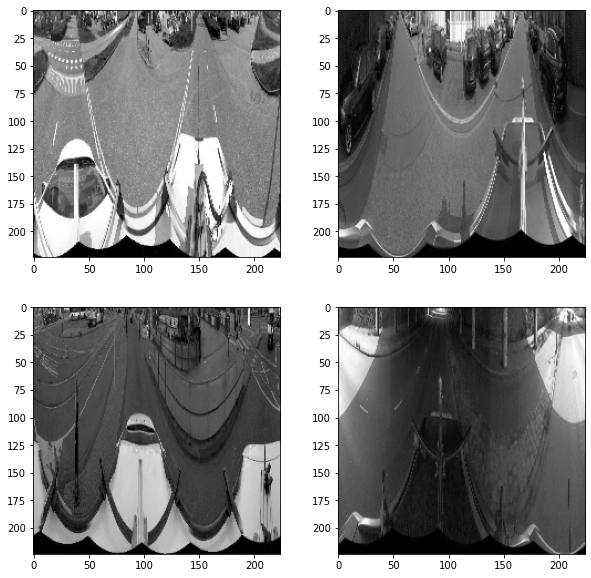

In [ ]:
# visualizing images
i = 50
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(train_data[i][0][2], cmap='gray')
plt.subplot(222), plt.imshow(train_data[i+25][0][2], cmap='gray')
plt.subplot(223), plt.imshow(train_data[i+50][0][2], cmap='gray')
plt.subplot(224), plt.imshow(train_data[i+75][0][2], cmap='gray')

In [ ]:
class final_layers(nn.Module):
    def __init__(self):
        super(final_layers, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layers(x)
        return x.squeeze()

In [ ]:
def set_parameter_requires_grad(model, layers_untrained):
  layers_untrained = min(layers_untrained,61)
  for i,param in enumerate(model.parameters()):
    if i<layers_untrained:
      param.requires_grad = False

In [ ]:
# defining the model
model = models.resnet34(pretrained=True)
#set_parameter_requires_grad(model,0)
model.fc = final_layers()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.0003)
# defining the loss function
criterion = BCELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

print(model)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [ ]:
''' SEED Everything '''
def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True 
SEED=42
seed_everything(SEED=SEED)
''' SEED Everything '''
# set computation device
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")

Computation device: cuda:0


In [ ]:
#validation function
def validate(model, test_dataloader):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_dataloader), total=int(len(test_data)/test_dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs.float(), target.float())
            val_running_loss += loss.item()
            preds = torch.round(outputs.data)
            val_running_correct += (preds == target).sum().item()
            true_positives += ((preds == 1)&(target == 1)).sum().item()
            true_negatives += ((preds == 0)&(target == 0)).sum().item()
            false_positives += ((preds == 1)&(target == 0)).sum().item()
            false_negatives += ((preds == 0)&(target == 1)).sum().item()
        
        if true_positives+false_positives>0:
          precision = true_positives/(true_positives+false_positives)
        else:
          precision = 0
        recall = true_positives/(true_positives+false_negatives)
        if ((precision>0)&(recall>0)):
          f1 = 2 * (precision*recall)/(precision+recall)
        else:
          f1 = 0
        val_loss = val_running_loss/max(int(len(test_data)/test_dataloader.batch_size),1)
        val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
        print(f"Recall: {recall:.4f}, Precision: {precision:.2f}, F1: {f1:.2f}")
        
        return val_loss, val_accuracy, f1

In [ ]:
# training function
def fit(model, train_dataloader):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    for i, data in tqdm(enumerate(train_dataloader), total=int(len(train_data)/train_dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs.float(), target.float())
        train_running_loss += loss.item()
        preds = torch.round(outputs.data)
        train_running_correct += (preds == target).sum().item()
        true_positives += ((preds == 1)&(target == 1)).sum().item()
        true_negatives += ((preds == 0)&(target == 0)).sum().item()
        false_positives += ((preds == 1)&(target == 0)).sum().item()
        false_negatives += ((preds == 0)&(target == 1)).sum().item()
        loss.backward()
        optimizer.step()
    
    if true_positives+false_positives>0:
      precision = true_positives/(true_positives+false_positives)
    else:
      precision = 0
    recall = true_positives/(true_positives+false_negatives)
    if ((precision>0)&(recall>0)):
      f1 = 2 * (precision*recall)/(precision+recall)
    else:
      f1 = 0
    train_loss = train_running_loss/int(len(train_data)/train_dataloader.batch_size)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
    print(f"Recall: {recall:.4f}, Precision: {precision:.2f}, F1: {f1:.2f}")
    
    return train_loss, train_accuracy, f1

In [ ]:
train_loss , train_accuracy , train_f1 = [], [], []
val_loss , val_accuracy, val_f1 = [], [], []
start = time.time()
epochs = 75
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy, train_epoch_f1 = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy, val_epoch_f1 = validate(model, testloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    train_f1.append(train_epoch_f1)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    val_f1.append(val_epoch_f1)
    path = "/content/drive/MyDrive/Owen/resnet_output/epoch" + str(epoch)
    torch.save(model.state_dict(), path)
end = time.time()
print(f"{(end-start)/60:.3f} minutes")

  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 1 of 75
Training


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
147it [17:28,  7.13s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.2829, Train Acc: 87.79
Recall: 0.7820, Precision: 0.85, F1: 0.82
Validating


18it [01:57,  6.54s/it]


Val Loss: 0.7857, Val Acc: 74.13
Recall: 0.9221, Precision: 0.55, F1: 0.69


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 2 of 75
Training


147it [16:55,  6.91s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.1075, Train Acc: 95.90
Recall: 0.9331, Precision: 0.95, F1: 0.94
Validating


18it [01:53,  6.31s/it]


Val Loss: 0.4887, Val Acc: 83.61
Recall: 0.7395, Precision: 0.73, F1: 0.74


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 3 of 75
Training


147it [17:00,  6.94s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0594, Train Acc: 97.97
Recall: 0.9678, Precision: 0.97, F1: 0.97
Validating


18it [01:54,  6.38s/it]


Val Loss: 0.6570, Val Acc: 84.14
Recall: 0.6606, Precision: 0.79, F1: 0.72


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 4 of 75
Training


147it [16:44,  6.83s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0402, Train Acc: 98.48
Recall: 0.9772, Precision: 0.98, F1: 0.98
Validating


18it [01:54,  6.36s/it]


Val Loss: 0.6790, Val Acc: 80.10
Recall: 0.7158, Precision: 0.66, F1: 0.69


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 5 of 75
Training


147it [16:24,  6.69s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0296, Train Acc: 98.95
Recall: 0.9842, Precision: 0.99, F1: 0.98
Validating


18it [01:57,  6.54s/it]


Val Loss: 0.5908, Val Acc: 85.57
Recall: 0.7177, Precision: 0.79, F1: 0.75


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 6 of 75
Training


147it [16:16,  6.64s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0233, Train Acc: 99.14
Recall: 0.9868, Precision: 0.99, F1: 0.99
Validating


18it [01:45,  5.84s/it]


Val Loss: 0.9655, Val Acc: 83.64
Recall: 0.5817, Precision: 0.84, F1: 0.69


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 7 of 75
Training


147it [16:15,  6.63s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0163, Train Acc: 99.43
Recall: 0.9915, Precision: 0.99, F1: 0.99
Validating


18it [01:53,  6.30s/it]


Val Loss: 0.9745, Val Acc: 82.03
Recall: 0.7091, Precision: 0.71, F1: 0.71


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 8 of 75
Training


147it [15:34,  6.36s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0219, Train Acc: 99.24
Recall: 0.9890, Precision: 0.99, F1: 0.99
Validating


18it [01:47,  5.98s/it]


Val Loss: 0.7372, Val Acc: 85.13
Recall: 0.6350, Precision: 0.84, F1: 0.72


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 9 of 75
Training


147it [16:04,  6.56s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0183, Train Acc: 99.34
Recall: 0.9894, Precision: 0.99, F1: 0.99
Validating


18it [01:53,  6.28s/it]


Val Loss: 0.8075, Val Acc: 81.71
Recall: 0.7605, Precision: 0.68, F1: 0.72


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 10 of 75
Training


147it [16:26,  6.71s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0119, Train Acc: 99.59
Recall: 0.9944, Precision: 0.99, F1: 0.99
Validating


18it [01:52,  6.23s/it]


Val Loss: 0.8751, Val Acc: 84.23
Recall: 0.6597, Precision: 0.79, F1: 0.72


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 11 of 75
Training


147it [16:38,  6.79s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0150, Train Acc: 99.48
Recall: 0.9921, Precision: 0.99, F1: 0.99
Validating


18it [01:53,  6.32s/it]


Val Loss: 0.9706, Val Acc: 83.93
Recall: 0.7015, Precision: 0.76, F1: 0.73


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 12 of 75
Training


147it [16:33,  6.76s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0166, Train Acc: 99.41
Recall: 0.9911, Precision: 0.99, F1: 0.99
Validating


18it [01:55,  6.40s/it]


Val Loss: 1.0464, Val Acc: 83.35
Recall: 0.6844, Precision: 0.75, F1: 0.72


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 13 of 75
Training


147it [16:36,  6.78s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0170, Train Acc: 99.40
Recall: 0.9907, Precision: 0.99, F1: 0.99
Validating


18it [01:51,  6.22s/it]


Val Loss: 0.9253, Val Acc: 81.91
Recall: 0.7205, Precision: 0.70, F1: 0.71


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 14 of 75
Training


147it [16:30,  6.74s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0112, Train Acc: 99.63
Recall: 0.9939, Precision: 1.00, F1: 0.99
Validating


18it [01:53,  6.30s/it]


Val Loss: 0.9245, Val Acc: 83.73
Recall: 0.7909, Precision: 0.71, F1: 0.75


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 15 of 75
Training


147it [16:18,  6.66s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0141, Train Acc: 99.54
Recall: 0.9940, Precision: 0.99, F1: 0.99
Validating


18it [01:50,  6.14s/it]


Val Loss: 0.9681, Val Acc: 84.11
Recall: 0.7643, Precision: 0.73, F1: 0.75


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 16 of 75
Training


147it [16:32,  6.75s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0053, Train Acc: 99.81
Recall: 0.9967, Precision: 1.00, F1: 1.00
Validating


18it [01:53,  6.30s/it]


Val Loss: 1.0147, Val Acc: 84.14
Recall: 0.7510, Precision: 0.74, F1: 0.74


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 17 of 75
Training


147it [16:52,  6.89s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0023, Train Acc: 99.89
Recall: 0.9983, Precision: 1.00, F1: 1.00
Validating


18it [01:54,  6.39s/it]


Val Loss: 1.0557, Val Acc: 83.52
Recall: 0.7348, Precision: 0.73, F1: 0.73


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 18 of 75
Training


147it [16:50,  6.88s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0017, Train Acc: 99.91
Recall: 0.9990, Precision: 1.00, F1: 1.00
Validating


18it [01:55,  6.44s/it]


Val Loss: 1.2360, Val Acc: 84.17
Recall: 0.7424, Precision: 0.74, F1: 0.74


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 19 of 75
Training


147it [16:36,  6.78s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0033, Train Acc: 99.86
Recall: 0.9975, Precision: 1.00, F1: 1.00
Validating


18it [01:53,  6.33s/it]


Val Loss: 2.0784, Val Acc: 76.91
Recall: 0.6730, Precision: 0.61, F1: 0.64


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 20 of 75
Training


147it [16:08,  6.59s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0346, Train Acc: 98.83
Recall: 0.9832, Precision: 0.98, F1: 0.98
Validating


18it [01:46,  5.93s/it]


Val Loss: 0.8405, Val Acc: 80.95
Recall: 0.6673, Precision: 0.70, F1: 0.68


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 21 of 75
Training


147it [16:15,  6.64s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0150, Train Acc: 99.47
Recall: 0.9919, Precision: 0.99, F1: 0.99
Validating


18it [01:52,  6.27s/it]


Val Loss: 0.8903, Val Acc: 81.71
Recall: 0.7899, Precision: 0.67, F1: 0.73


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 22 of 75
Training


147it [16:36,  6.78s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0103, Train Acc: 99.62
Recall: 0.9948, Precision: 0.99, F1: 0.99
Validating


18it [01:54,  6.36s/it]


Val Loss: 1.0284, Val Acc: 82.32
Recall: 0.7205, Precision: 0.71, F1: 0.72


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 23 of 75
Training


147it [16:32,  6.75s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0090, Train Acc: 99.67
Recall: 0.9948, Precision: 1.00, F1: 1.00
Validating


18it [01:51,  6.21s/it]


Val Loss: 0.9661, Val Acc: 83.52
Recall: 0.7253, Precision: 0.74, F1: 0.73


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 24 of 75
Training


147it [16:18,  6.65s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0092, Train Acc: 99.70
Recall: 0.9959, Precision: 1.00, F1: 1.00
Validating


18it [01:50,  6.13s/it]


Val Loss: 0.9640, Val Acc: 84.40
Recall: 0.6236, Precision: 0.83, F1: 0.71


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 25 of 75
Training


147it [15:54,  6.50s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0052, Train Acc: 99.83
Recall: 0.9971, Precision: 1.00, F1: 1.00
Validating


18it [01:45,  5.88s/it]


Val Loss: 0.8922, Val Acc: 84.02
Recall: 0.7395, Precision: 0.74, F1: 0.74


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 26 of 75
Training


147it [15:24,  6.29s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0041, Train Acc: 99.84
Recall: 0.9974, Precision: 1.00, F1: 1.00
Validating


18it [01:44,  5.82s/it]


Val Loss: 1.1634, Val Acc: 81.68
Recall: 0.7129, Precision: 0.70, F1: 0.71


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 27 of 75
Training


147it [15:17,  6.24s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0088, Train Acc: 99.69
Recall: 0.9953, Precision: 1.00, F1: 1.00
Validating


18it [01:47,  5.98s/it]


Val Loss: 1.1339, Val Acc: 78.46
Recall: 0.7006, Precision: 0.64, F1: 0.67


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 28 of 75
Training


147it [15:16,  6.23s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0212, Train Acc: 99.31
Recall: 0.9897, Precision: 0.99, F1: 0.99
Validating


18it [01:45,  5.86s/it]


Val Loss: 0.8720, Val Acc: 83.03
Recall: 0.6787, Precision: 0.75, F1: 0.71


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 29 of 75
Training


147it [15:49,  6.46s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0085, Train Acc: 99.69
Recall: 0.9956, Precision: 1.00, F1: 1.00
Validating


18it [01:51,  6.19s/it]


Val Loss: 1.1506, Val Acc: 83.00
Recall: 0.7405, Precision: 0.72, F1: 0.73


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 30 of 75
Training


147it [16:07,  6.58s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0030, Train Acc: 99.87
Recall: 0.9983, Precision: 1.00, F1: 1.00
Validating


18it [01:53,  6.31s/it]


Val Loss: 1.0355, Val Acc: 84.96
Recall: 0.7300, Precision: 0.77, F1: 0.75


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 31 of 75
Training


147it [16:15,  6.63s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0013, Train Acc: 99.90
Recall: 0.9988, Precision: 1.00, F1: 1.00
Validating


18it [01:56,  6.46s/it]


Val Loss: 1.0072, Val Acc: 83.55
Recall: 0.7376, Precision: 0.73, F1: 0.73


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 32 of 75
Training


147it [17:09,  7.01s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0199, Train Acc: 99.30
Recall: 0.9894, Precision: 0.99, F1: 0.99
Validating


18it [02:00,  6.70s/it]


Val Loss: 0.7653, Val Acc: 81.74
Recall: 0.6625, Precision: 0.72, F1: 0.69


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 33 of 75
Training


147it [16:49,  6.87s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0113, Train Acc: 99.59
Recall: 0.9933, Precision: 0.99, F1: 0.99
Validating


18it [01:52,  6.23s/it]


Val Loss: 1.0458, Val Acc: 85.22
Recall: 0.7405, Precision: 0.77, F1: 0.76


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 34 of 75
Training


147it [16:34,  6.76s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0057, Train Acc: 99.76
Recall: 0.9970, Precision: 1.00, F1: 1.00
Validating


18it [01:51,  6.21s/it]


Val Loss: 1.1792, Val Acc: 79.81
Recall: 0.7728, Precision: 0.64, F1: 0.70


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 35 of 75
Training


147it [16:23,  6.69s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0111, Train Acc: 99.65
Recall: 0.9941, Precision: 1.00, F1: 0.99
Validating


18it [01:53,  6.29s/it]


Val Loss: 1.1340, Val Acc: 81.91
Recall: 0.7567, Precision: 0.69, F1: 0.72


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 36 of 75
Training


147it [16:23,  6.69s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0079, Train Acc: 99.71
Recall: 0.9960, Precision: 1.00, F1: 1.00
Validating


18it [01:49,  6.10s/it]


Val Loss: 1.2196, Val Acc: 80.36
Recall: 0.7053, Precision: 0.67, F1: 0.69


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 37 of 75
Training


147it [16:09,  6.59s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0054, Train Acc: 99.80
Recall: 0.9978, Precision: 1.00, F1: 1.00
Validating


18it [01:50,  6.12s/it]


Val Loss: 0.9927, Val Acc: 83.99
Recall: 0.7529, Precision: 0.73, F1: 0.74


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 38 of 75
Training


147it [16:05,  6.56s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0041, Train Acc: 99.84
Recall: 0.9970, Precision: 1.00, F1: 1.00
Validating


18it [01:49,  6.06s/it]


Val Loss: 1.2167, Val Acc: 83.55
Recall: 0.7243, Precision: 0.74, F1: 0.73


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 39 of 75
Training


147it [16:12,  6.62s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0034, Train Acc: 99.85
Recall: 0.9979, Precision: 1.00, F1: 1.00
Validating


18it [01:53,  6.29s/it]


Val Loss: 1.1378, Val Acc: 82.91
Recall: 0.6654, Precision: 0.75, F1: 0.71


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 40 of 75
Training


147it [16:45,  6.84s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0067, Train Acc: 99.72
Recall: 0.9960, Precision: 1.00, F1: 1.00
Validating


18it [01:58,  6.56s/it]


Val Loss: 1.0689, Val Acc: 81.91
Recall: 0.7652, Precision: 0.68, F1: 0.72


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 41 of 75
Training


147it [16:33,  6.76s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0080, Train Acc: 99.73
Recall: 0.9960, Precision: 1.00, F1: 1.00
Validating


18it [01:51,  6.22s/it]


Val Loss: 1.2319, Val Acc: 83.14
Recall: 0.7205, Precision: 0.73, F1: 0.72


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 42 of 75
Training


147it [16:13,  6.62s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0100, Train Acc: 99.65
Recall: 0.9952, Precision: 0.99, F1: 0.99
Validating


18it [01:51,  6.19s/it]


Val Loss: 1.3471, Val Acc: 79.54
Recall: 0.7414, Precision: 0.65, F1: 0.69


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 43 of 75
Training


147it [16:20,  6.67s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0071, Train Acc: 99.72
Recall: 0.9963, Precision: 1.00, F1: 1.00
Validating


18it [01:49,  6.09s/it]


Val Loss: 0.9395, Val Acc: 82.82
Recall: 0.7139, Precision: 0.72, F1: 0.72


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 44 of 75
Training


  5%|▍         | 7/146 [00:46<15:19,  6.61s/it]

IndexError: ignored

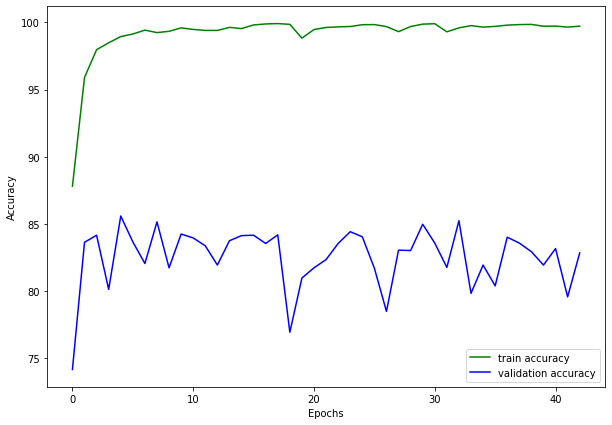

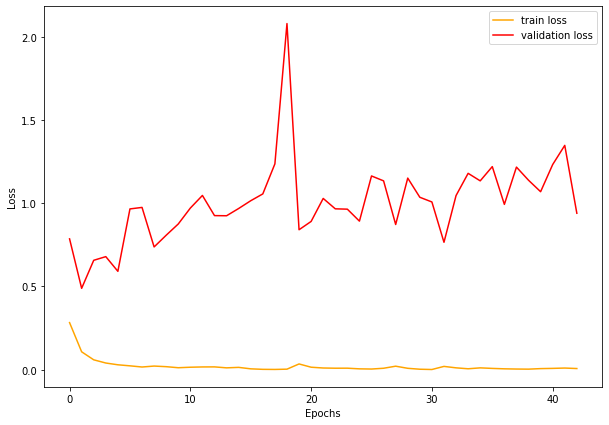

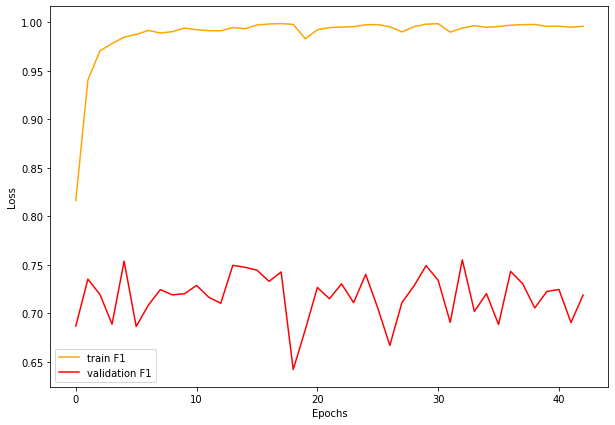

In [ ]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig('/content/drive/MyDrive/Owen/accuracy.png')
plt.show()
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('/content/drive/MyDrive/Owen/loss.png')
plt.show()
# F1 plots
plt.figure(figsize=(10, 7))
plt.plot(train_f1, color='orange', label='train F1')
plt.plot(val_f1, color='red', label='validation F1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('/content/drive/MyDrive/Owen/loss.png')
plt.show()

In [ ]:
for i,val in enumerate(val_f1):
  if val==max(val_f1):
    print(i)

32


In [ ]:
results = pd.DataFrame({'Train Accuracy':train_accuracy,
                        'Validation Accuracy':val_accuracy,
                        'Train Loss':train_loss, 
                        'Validation Loss':val_loss,
                        'Train F1':train_f1,
                        'Validation F1':val_f1}, 
                         columns=['Train Accuracy','Validation Accuracy', 'Train Loss', 'Validation Loss',
                                  'Train F1', "Validation F1"])

In [ ]:
results.to_csv("/content/drive/MyDrive/Owen/final_results/baseline.csv")

In [ ]:
labelled_data['inspection_id'] = labelled_data['road_id'] + labelled_data['inspection_date']

In [ ]:
fulltestloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
inspection_ids = labelled_data.iloc[test].inspection_id.unique()
inspections_x = labelled_data.iloc[test].inspection_id.values
inspections_y = labelled_data.loc[test,'cracking_binary'].groupby(by=inspections_x).max()

In [ ]:
from sklearn.metrics import f1_score
inspection_ids = labelled_data.iloc[test].inspection_id.unique()
inspections_x = labelled_data.iloc[test].inspection_id.values
inspections_y = labelled_data.loc[test,'cracking_binary'].groupby(by=inspections_x).max()
f1_scores_max = []
f1_scores_mean = []
f1_scores_majority = []
f1_scores_top2 = []
f1_scores_product = []
for a in range(6):
  path = "/content/drive/MyDrive/Owen/resnet_output/epoch" + str(a)
  model.load_state_dict(torch.load(path))
  model.eval
  road_truths = []
  max_preds = []
  mean_preds = []
  majority_preds = []
  toptwo_preds = []
  product_preds = []
  for i,inspection in tqdm(enumerate(inspection_ids), total=len(inspection_ids)):
      images_x = xtest[inspections_x==inspection]
      images_y = ytest[inspections_x==inspection]
      test_data = pano_images(images_x, images_y, tfms=0)
      with torch.no_grad():
        test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
        for i, data in enumerate(test_dataloader):
          data = data[0].to(device)
          outputs = model(data)
          road_truth = np.amax(images_y)
          max_pred = torch.round(torch.max(outputs.data)).item()
          mean_pred = torch.round(torch.mean(outputs.data)).item()
          majority_pred = torch.round(torch.mean(torch.round(outputs.data))).item()
          product_pred = torch.round(1-torch.prod(1-outputs.data)).item()
          if len(outputs.size())==0:
            top2_pred = torch.round(torch.max(outputs)).item()
          else:
            top2 = torch.topk(outputs, 2).values
            top2_pred = torch.round(torch.mean(top2)).item()
          road_truths.append(road_truth)
          max_preds.append(max_pred)
          mean_preds.append(mean_pred)
          majority_preds.append(majority_pred)
          toptwo_preds.append(top2_pred)
          product_preds.append(product_pred)
  f1_max = f1_score(road_truths, max_preds)
  f1_mean = f1_score(road_truths, mean_preds)
  f1_majority = f1_score(road_truths, majority_preds)
  f1_top2 = f1_score(road_truths, toptwo_preds)
  f1_product = f1_score(road_truths, product_preds)
  print(f1_max, f1_mean, f1_majority, f1_top2)
  f1_scores_max.append(f1_max)
  f1_scores_mean.append(f1_mean)
  f1_scores_majority.append(f1_majority)
  f1_scores_top2.append(f1_top2)
  f1_scores_product.append(f1_product)




  0%|          | 0/213 [00:00<?, ?it/s]


  0%|          | 1/213 [00:00<01:01,  3.42it/s]


  1%|          | 2/213 [00:00<01:22,  2.56it/s]


  1%|▏         | 3/213 [00:01<01:14,  2.83it/s]


  2%|▏         | 5/213 [00:02<01:19,  2.62it/s]


  3%|▎         | 6/213 [00:02<01:12,  2.84it/s]


  3%|▎         | 7/213 [00:03<02:07,  1.62it/s]


  4%|▍         | 9/213 [00:05<02:25,  1.41it/s]


  5%|▍         | 10/213 [00:08<04:28,  1.32s/it]


  5%|▌         | 11/213 [00:08<03:16,  1.03it/s]


  6%|▌         | 12/213 [00:08<02:53,  1.16it/s]


  6%|▌         | 13/213 [00:09<02:25,  1.37it/s]


  7%|▋         | 14/213 [00:09<02:01,  1.64it/s]


  7%|▋         | 15/213 [00:09<01:36,  2.06it/s]


  8%|▊         | 16/213 [00:10<01:32,  2.13it/s]


  8%|▊         | 17/213 [00:12<02:49,  1.16it/s]


  8%|▊         | 18/213 [00:12<02:22,  1.37it/s]


  9%|▉         | 19/213 [00:13<02:29,  1.30it/s]


  9%|▉         | 20/213 [00:13<02:00,  1.60it/s]


 10%|▉         | 21/213 [00:14<02:08,  1.49i

0.4705882352941176 0.0 0.0857142857142857 0.4675324675324675





  0%|          | 1/213 [00:00<00:59,  3.54it/s]


  1%|          | 2/213 [00:00<01:19,  2.66it/s]


  1%|▏         | 3/213 [00:01<01:11,  2.94it/s]


  2%|▏         | 5/213 [00:02<01:17,  2.69it/s]


  3%|▎         | 6/213 [00:02<01:10,  2.94it/s]


  3%|▎         | 7/213 [00:03<02:02,  1.68it/s]


  4%|▍         | 9/213 [00:05<02:18,  1.47it/s]


  5%|▍         | 10/213 [00:07<04:16,  1.27s/it]


  5%|▌         | 11/213 [00:08<03:07,  1.08it/s]


  6%|▌         | 12/213 [00:08<02:46,  1.21it/s]


  6%|▌         | 13/213 [00:09<02:20,  1.42it/s]


  7%|▋         | 14/213 [00:09<01:57,  1.70it/s]


  7%|▋         | 15/213 [00:09<01:32,  2.14it/s]


  8%|▊         | 16/213 [00:09<01:29,  2.21it/s]


  8%|▊         | 17/213 [00:11<02:43,  1.20it/s]


  8%|▊         | 18/213 [00:12<02:18,  1.41it/s]


  9%|▉         | 19/213 [00:12<02:24,  1.35it/s]


  9%|▉         | 20/213 [00:13<01:56,  1.65it/s]


 10%|▉         | 21/213 [00:13<02:04,  1.54it/s]


 10%|█         | 22/213 [00:15<03:0

0.4672131147540984 0.03125 0.03076923076923077 0.463519313304721





  0%|          | 1/213 [00:00<00:58,  3.60it/s]


  1%|          | 2/213 [00:00<01:16,  2.75it/s]


  1%|▏         | 3/213 [00:01<01:08,  3.06it/s]


  2%|▏         | 5/213 [00:01<01:13,  2.83it/s]


  3%|▎         | 6/213 [00:02<01:07,  3.06it/s]


  3%|▎         | 7/213 [00:03<01:55,  1.78it/s]


  4%|▍         | 9/213 [00:04<02:11,  1.55it/s]


  5%|▍         | 10/213 [00:07<04:06,  1.22s/it]


  5%|▌         | 11/213 [00:07<03:00,  1.12it/s]


  6%|▌         | 12/213 [00:08<02:40,  1.26it/s]


  6%|▌         | 13/213 [00:08<02:14,  1.49it/s]


  7%|▋         | 14/213 [00:08<01:52,  1.77it/s]


  7%|▋         | 15/213 [00:09<01:27,  2.25it/s]


  8%|▊         | 16/213 [00:09<01:24,  2.34it/s]


  8%|▊         | 17/213 [00:11<02:33,  1.27it/s]


  8%|▊         | 18/213 [00:11<02:09,  1.50it/s]


  9%|▉         | 19/213 [00:12<02:15,  1.43it/s]


  9%|▉         | 20/213 [00:12<01:49,  1.76it/s]


 10%|▉         | 21/213 [00:13<01:58,  1.63it/s]


 10%|█         | 22/213 [00:14<02:5

0.4666666666666667 0.0 0.1142857142857143 0.4655172413793104





  0%|          | 1/213 [00:00<00:58,  3.61it/s]


  1%|          | 2/213 [00:00<01:16,  2.76it/s]


  1%|▏         | 3/213 [00:01<01:08,  3.07it/s]


  2%|▏         | 5/213 [00:01<01:13,  2.82it/s]


  3%|▎         | 6/213 [00:02<01:08,  3.04it/s]


  3%|▎         | 7/213 [00:03<01:57,  1.75it/s]


  4%|▍         | 9/213 [00:05<02:13,  1.53it/s]


  5%|▍         | 10/213 [00:07<04:05,  1.21s/it]


  5%|▌         | 11/213 [00:07<02:58,  1.13it/s]


  6%|▌         | 12/213 [00:08<02:37,  1.28it/s]


  6%|▌         | 13/213 [00:08<02:13,  1.50it/s]


  7%|▋         | 14/213 [00:08<01:50,  1.80it/s]


  7%|▋         | 15/213 [00:09<01:27,  2.26it/s]


  8%|▊         | 16/213 [00:09<01:24,  2.34it/s]


  8%|▊         | 17/213 [00:11<02:33,  1.27it/s]


  8%|▊         | 18/213 [00:11<02:10,  1.49it/s]


  9%|▉         | 19/213 [00:12<02:17,  1.41it/s]


  9%|▉         | 20/213 [00:12<01:53,  1.71it/s]


 10%|▉         | 21/213 [00:13<02:02,  1.57it/s]


 10%|█         | 22/213 [00:14<02:5

0.47302904564315346 0.0 0.0625 0.47619047619047616





  0%|          | 1/213 [00:00<01:01,  3.47it/s]


  1%|          | 2/213 [00:00<01:18,  2.69it/s]


  1%|▏         | 3/213 [00:01<01:10,  2.98it/s]


  2%|▏         | 5/213 [00:01<01:15,  2.76it/s]


  3%|▎         | 6/213 [00:02<01:08,  3.00it/s]


  3%|▎         | 7/213 [00:03<01:59,  1.72it/s]


  4%|▍         | 9/213 [00:05<02:14,  1.51it/s]


  5%|▍         | 10/213 [00:07<04:05,  1.21s/it]


  5%|▌         | 11/213 [00:07<02:59,  1.13it/s]


  6%|▌         | 12/213 [00:08<02:37,  1.27it/s]


  6%|▌         | 13/213 [00:08<02:12,  1.51it/s]


  7%|▋         | 14/213 [00:08<01:50,  1.80it/s]


  7%|▋         | 15/213 [00:09<01:26,  2.28it/s]


  8%|▊         | 16/213 [00:09<01:24,  2.33it/s]


  8%|▊         | 17/213 [00:11<02:33,  1.28it/s]


  8%|▊         | 18/213 [00:11<02:10,  1.49it/s]


  9%|▉         | 19/213 [00:12<02:16,  1.43it/s]


  9%|▉         | 20/213 [00:12<01:50,  1.75it/s]


 10%|▉         | 21/213 [00:13<01:57,  1.63it/s]


 10%|█         | 22/213 [00:14<02:5

0.4769874476987448 0.0 0.031746031746031744 0.4736842105263158





  0%|          | 1/213 [00:00<00:59,  3.58it/s]


  1%|          | 2/213 [00:00<01:16,  2.75it/s]


  1%|▏         | 3/213 [00:01<01:09,  3.04it/s]


  2%|▏         | 5/213 [00:01<01:13,  2.84it/s]


  3%|▎         | 6/213 [00:02<01:07,  3.05it/s]


  3%|▎         | 7/213 [00:03<01:57,  1.75it/s]


  4%|▍         | 9/213 [00:04<02:12,  1.55it/s]


  5%|▍         | 10/213 [00:07<04:04,  1.21s/it]


  5%|▌         | 11/213 [00:07<02:59,  1.13it/s]


  6%|▌         | 12/213 [00:08<02:37,  1.28it/s]


  6%|▌         | 13/213 [00:08<02:13,  1.50it/s]


  7%|▋         | 14/213 [00:08<01:50,  1.79it/s]


  7%|▋         | 15/213 [00:09<01:27,  2.27it/s]


  8%|▊         | 16/213 [00:09<01:23,  2.35it/s]


  8%|▊         | 17/213 [00:11<02:32,  1.28it/s]


  8%|▊         | 18/213 [00:11<02:09,  1.50it/s]


  9%|▉         | 19/213 [00:12<02:14,  1.44it/s]


  9%|▉         | 20/213 [00:12<01:48,  1.77it/s]


 10%|▉         | 21/213 [00:13<01:56,  1.65it/s]


 10%|█         | 22/213 [00:14<02:5

0.47107438016528924 0.06153846153846154 0.05970149253731343 0.4615384615384615


In [ ]:
blind_test = pd.read_csv("/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/test.csv")

In [ ]:
blind_test = blind_test.drop("Unnamed: 0", axis="columns")
blind_test = blind_test.rename(columns={'Unnamed: 0.1':'image_name'})

In [ ]:
blind_test['image_path'] = "/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/" + blind_test['image_name'].astype("str") + ".jpeg"

In [ ]:
blind_test['inspection_id'] = blind_test['road_id'] + blind_test['inspection_date']

In [ ]:
inspection_ids = blind_test.inspection_id.unique()
x_blind = blind_test.image_path.values
y_blind = blind_test.cracking_binary.values
inspections_x = blind_test.inspection_id.values
inspections_y = blind_test['cracking_binary'].groupby(by=inspections_x).max()

In [ ]:
from sklearn.metrics import f1_score

model.load_state_dict(torch.load("/content/drive/MyDrive/Owen/resnet_output/epoch32"))
model.eval
road_truths = []
max_preds = []
mean_preds = []
majority_preds = []
toptwo_preds = []
product_preds = []
for i,inspection in tqdm(enumerate(inspection_ids), total=len(inspection_ids)):
    images_x = x_blind[inspections_x==inspection]
    images_y = y_blind[inspections_x==inspection]
    test_data = pano_images(images_x, images_y, tfms=0)
    with torch.no_grad():
       test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
       for i, data in enumerate(test_dataloader):
         data = data[0].to(device)
         outputs = model(data)
         road_truth = np.amax(images_y)
         max_pred = torch.round(torch.max(outputs.data)).item()
         mean_pred = torch.round(torch.mean(outputs.data)).item()
         majority_pred = torch.round(torch.mean(torch.round(outputs.data))).item()
         product_pred = torch.round(1-torch.prod(1-outputs.data)).item()
         if len(outputs.size())==0:
           top2_pred = torch.round(torch.max(outputs)).item()
         else:
           top2 = torch.topk(outputs, 2).values
           top2_pred = torch.round(torch.mean(top2)).item()
         road_truths.append(road_truth)
         max_preds.append(max_pred)
         mean_preds.append(mean_pred)
         majority_preds.append(majority_pred)
         toptwo_preds.append(top2_pred)
         product_preds.append(product_pred)
f1_max = f1_score(road_truths, max_preds)
f1_mean = f1_score(road_truths, mean_preds)
f1_majority = f1_score(road_truths, majority_preds)
f1_top2 = f1_score(road_truths, toptwo_preds)
f1_product = f1_score(road_truths, product_preds)
print(f1_max, f1_mean, f1_majority, f1_top2,f1_product)


100%|██████████| 213/213 [53:51<00:00, 15.17s/it]

0.4961832061068702 0.05333333333333333 0.027027027027027025 0.504 0.4961832061068702


In [ ]:
import sklearn.metrics as metric

print(metric.confusion_matrix(road_truths, max_preds))
print(metric.accuracy_score(road_truths, max_preds))
print(metric.recall_score(road_truths, max_preds))
print(metric.precision_score(road_truths, max_preds))

[[ 16 127]
 [  5  65]]
0.38028169014084506
0.9285714285714286
0.3385416666666667


In [ ]:
(65)/(5+65)

0.9285714285714286

In [ ]:
import sklearn.metrics as metric

print(metric.recall_score(road_truths,max_preds))

0.8857142857142857


# RESNET BASELINE WITH MASK

In [ ]:
!pip3 install torch==1.6.0 torchvision==0.7.0

     |████████████████████████████████| 748.8MB 23kB/s 
     |████████████████████████████████| 5.9MB 42.1MB/s 
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.6.0 which is incompatible.
  Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102


In [ ]:
# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.6.0 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
assert torch.__version__.startswith("1.6")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html


In [ ]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
from google.colab.patches import cv2_imshow
import requests
import cv2


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
# Load model cfg and weights
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)

In [ ]:
def get_road(path):
  im = cv2.imread(path)
  panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
  new_dict = {}
  id = 999
  for item in segments_info:
   category_id = item['category_id']
   if category_id == 21:
     id = item['id']
  if id==999:
    print(path)
  road = (panoptic_seg==id)
  return road

/usr/local/lib/python3.7/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:154: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  filter_inds = filter_mask.nonzero()


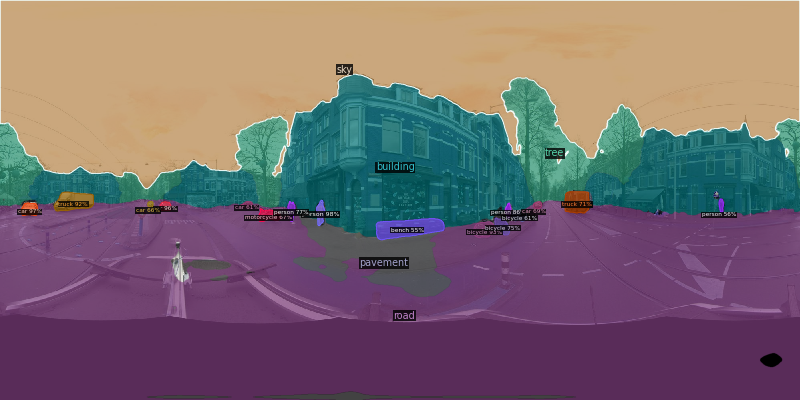

In [ ]:
im = cv2.imread("/content/train_set/2934.jpeg")
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.4)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(out.get_image())

(<matplotlib.axes._subplots.AxesSubplot at 0x7fb5ae4cf350>,
 <matplotlib.image.AxesImage at 0x7fb5ae3a52d0>)

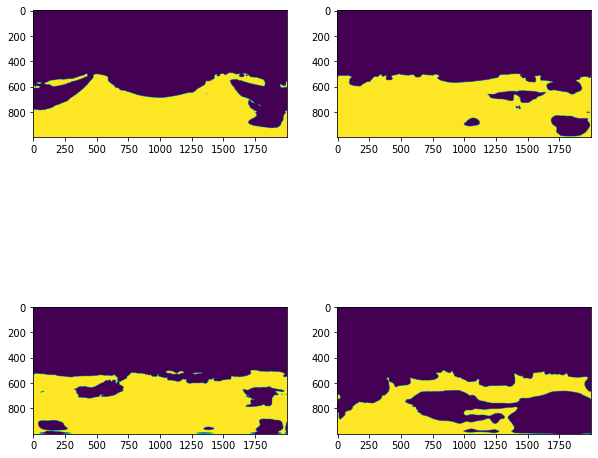

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(get_road("/content/train_set/1000.jpeg").cpu())
plt.subplot(222), plt.imshow(get_road("/content/train_set/1200.jpeg").cpu())
plt.subplot(223), plt.imshow(get_road("/content/train_set/1300.jpeg").cpu())
plt.subplot(224), plt.imshow(get_road("/content/train_set/1400.jpeg").cpu())

In [4]:
labelled_data = pd.read_csv("/content/train_set/train.csv")

In [5]:
labelled_data = labelled_data.drop("Unnamed: 0", axis="columns")
labelled_data = labelled_data.rename(columns={'Unnamed: 0.1':'image_name'})

In [6]:
gss = GroupShuffleSplit(n_splits=2, train_size=0.8/0.9, random_state=42)
gss.get_n_splits()
groups = np.array(labelled_data["road_id"])

In [7]:
train,test = next(gss.split(X = labelled_data, groups = groups))

In [8]:
labelled_data['image_path'] = "/content/train_set/" + labelled_data['image_name'].astype("str") + ".jpeg"

In [ ]:
i = -1
for image_number in tqdm(labelled_data['image_name']):
  i = i+1
  if i > 40000:
    folder = round((image_number+2500)/5000)
    oldpath = "/content/train_set/" + str(image_number) + ".jpeg"
    newpath = "/content/drive/MyDrive/Owen/segmented_images_multiplied/" + str(folder) + "/" + str(image_number) + ".jpeg"
    im = cv2.imread(oldpath)
    panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
    new_dict = {}
    id = 999
    for item in segments_info:
      category_id = item['category_id']
      if category_id == 21:
        id = item['id']
    if id==999:
      print(oldpath)
    road = (panoptic_seg==id)
    road = np.repeat(road.cpu()[:, :, np.newaxis], 3, axis=2)
    newimage = np.array(road)*np.array(im)
    cv2.imwrite(newpath,newimage)

Streaming output truncated to the last 5000 lines.

 42%|████▏     | 13842/32710 [02:30<1:24:50,  3.71it/s]


 42%|████▏     | 13843/32710 [02:31<1:24:31,  3.72it/s]


 42%|████▏     | 13844/32710 [02:31<1:25:53,  3.66it/s]


 42%|████▏     | 13845/32710 [02:31<1:25:52,  3.66it/s]


 42%|████▏     | 13846/32710 [02:32<1:26:25,  3.64it/s]


 42%|████▏     | 13847/32710 [02:32<1:26:03,  3.65it/s]


 42%|████▏     | 13848/32710 [02:32<1:27:57,  3.57it/s]


 42%|████▏     | 13849/32710 [02:32<1:26:04,  3.65it/s]


 42%|████▏     | 13850/32710 [02:33<1:27:43,  3.58it/s]


 42%|████▏     | 13851/32710 [02:33<1:25:33,  3.67it/s]


 42%|████▏     | 13852/32710 [02:33<1:25:07,  3.69it/s]


 42%|████▏     | 13853/32710 [02:33<1:24:51,  3.70it/s]


 42%|████▏     | 13854/32710 [02:34<1:24:56,  3.70it/s]


 42%|████▏     | 13855/32710 [02:34<1:23:45,  3.75it/s]


 42%|████▏     | 13856/32710 [02:34<1:23:40,  3.76it/s]


 42%|████▏     | 13857/32710 [02:35<1:26:01,  3.65it/s]


 42%|████▏     | 138

/content/train_set/16937.jpeg





 47%|████▋     | 15509/32710 [09:46<1:10:22,  4.07it/s]


 47%|████▋     | 15510/32710 [09:46<1:10:24,  4.07it/s]


 47%|████▋     | 15511/32710 [09:46<1:09:33,  4.12it/s]


 47%|████▋     | 15512/32710 [09:47<1:08:59,  4.15it/s]


 47%|████▋     | 15513/32710 [09:47<1:08:42,  4.17it/s]


 47%|████▋     | 15514/32710 [09:47<1:09:37,  4.12it/s]


 47%|████▋     | 15515/32710 [09:47<1:10:14,  4.08it/s]


 47%|████▋     | 15516/32710 [09:48<1:10:20,  4.07it/s]


 47%|████▋     | 15517/32710 [09:48<1:09:14,  4.14it/s]


 47%|████▋     | 15518/32710 [09:48<1:08:55,  4.16it/s]


 47%|████▋     | 15519/32710 [09:48<1:09:36,  4.12it/s]


 47%|████▋     | 15520/32710 [09:49<1:09:50,  4.10it/s]


 47%|████▋     | 15521/32710 [09:49<1:09:12,  4.14it/s]


 47%|████▋     | 15522/32710 [09:49<1:08:11,  4.20it/s]


 47%|████▋     | 15523/32710 [09:49<1:08:08,  4.20it/s]


 47%|████▋     | 15524/32710 [09:49<1:07:19,  4.25it/s]


 47%|████▋     | 15525/32710 [09:50<1:06:46,  4.29it/s]


 47%|████▋ 

/content/train_set/17278.jpeg





 48%|████▊     | 15827/32710 [11:09<1:13:01,  3.85it/s]


 48%|████▊     | 15828/32710 [11:09<1:12:04,  3.90it/s]


 48%|████▊     | 15829/32710 [11:09<1:11:48,  3.92it/s]


 48%|████▊     | 15830/32710 [11:09<1:11:15,  3.95it/s]


 48%|████▊     | 15831/32710 [11:10<1:10:38,  3.98it/s]


 48%|████▊     | 15832/32710 [11:10<1:11:49,  3.92it/s]


 48%|████▊     | 15833/32710 [11:10<1:10:46,  3.97it/s]


 48%|████▊     | 15834/32710 [11:10<1:12:09,  3.90it/s]


 48%|████▊     | 15835/32710 [11:11<1:13:34,  3.82it/s]


 48%|████▊     | 15836/32710 [11:11<1:13:43,  3.81it/s]


 48%|████▊     | 15837/32710 [11:11<1:12:16,  3.89it/s]


 48%|████▊     | 15838/32710 [11:11<1:12:14,  3.89it/s]


 48%|████▊     | 15839/32710 [11:12<1:11:33,  3.93it/s]


 48%|████▊     | 15840/32710 [11:12<1:12:14,  3.89it/s]


 48%|████▊     | 15841/32710 [11:12<1:11:13,  3.95it/s]


 48%|████▊     | 15842/32710 [11:12<1:11:52,  3.91it/s]


 48%|████▊     | 15843/32710 [11:13<1:12:23,  3.88it/s]


 48%|████▊ 

/content/train_set/18102.jpeg





 51%|█████     | 16587/32710 [14:28<1:06:24,  4.05it/s]


 51%|█████     | 16588/32710 [14:28<1:05:58,  4.07it/s]


 51%|█████     | 16589/32710 [14:28<1:05:34,  4.10it/s]


 51%|█████     | 16590/32710 [14:28<1:05:55,  4.07it/s]


 51%|█████     | 16591/32710 [14:29<1:06:18,  4.05it/s]


 51%|█████     | 16592/32710 [14:29<1:06:07,  4.06it/s]


 51%|█████     | 16593/32710 [14:29<1:05:31,  4.10it/s]


 51%|█████     | 16594/32710 [14:29<1:05:08,  4.12it/s]


 51%|█████     | 16595/32710 [14:30<1:06:49,  4.02it/s]


 51%|█████     | 16596/32710 [14:30<1:06:39,  4.03it/s]


 51%|█████     | 16597/32710 [14:30<1:06:11,  4.06it/s]


 51%|█████     | 16598/32710 [14:30<1:05:29,  4.10it/s]


 51%|█████     | 16599/32710 [14:31<1:05:58,  4.07it/s]


 51%|█████     | 16600/32710 [14:31<1:05:59,  4.07it/s]


 51%|█████     | 16601/32710 [14:31<1:05:26,  4.10it/s]


 51%|█████     | 16602/32710 [14:31<1:05:06,  4.12it/s]


 51%|█████     | 16603/32710 [14:32<1:06:34,  4.03it/s]


 51%|█████ 

/content/train_set/19100.jpeg





 53%|█████▎    | 17415/32710 [18:05<1:09:37,  3.66it/s]


 53%|█████▎    | 17416/32710 [18:05<1:09:59,  3.64it/s]

/content/train_set/19102.jpeg





 53%|█████▎    | 17417/32710 [18:05<1:11:32,  3.56it/s]


 53%|█████▎    | 17418/32710 [18:05<1:11:50,  3.55it/s]


 53%|█████▎    | 17419/32710 [18:06<1:11:44,  3.55it/s]


 53%|█████▎    | 17420/32710 [18:06<1:10:28,  3.62it/s]


 53%|█████▎    | 17421/32710 [18:06<1:09:43,  3.65it/s]


 53%|█████▎    | 17422/32710 [18:07<1:09:35,  3.66it/s]


 53%|█████▎    | 17423/32710 [18:07<1:10:00,  3.64it/s]


 53%|█████▎    | 17424/32710 [18:07<1:10:33,  3.61it/s]


 53%|█████▎    | 17425/32710 [18:07<1:10:26,  3.62it/s]


 53%|█████▎    | 17426/32710 [18:08<1:09:40,  3.66it/s]


 53%|█████▎    | 17427/32710 [18:08<1:10:12,  3.63it/s]


 53%|█████▎    | 17428/32710 [18:08<1:09:59,  3.64it/s]


 53%|█████▎    | 17429/32710 [18:08<1:09:08,  3.68it/s]


 53%|█████▎    | 17430/32710 [18:09<1:08:19,  3.73it/s]


 53%|█████▎    | 17431/32710 [18:09<1:08:17,  3.73it/s]


 53%|█████▎    | 17432/32710 [18:09<1:07:52,  3.75it/s]


 53%|█████▎    | 17433/32710 [18:10<1:07:50,  3.75it/s]


 53%|█████▎

/content/train_set/19209.jpeg





 54%|█████▎    | 17500/32710 [18:27<1:02:40,  4.05it/s]


 54%|█████▎    | 17501/32710 [18:27<1:01:18,  4.13it/s]

/content/train_set/19211.jpeg





 54%|█████▎    | 17502/32710 [18:27<1:03:36,  3.98it/s]


 54%|█████▎    | 17503/32710 [18:28<1:04:14,  3.95it/s]


 54%|█████▎    | 17504/32710 [18:28<1:02:47,  4.04it/s]


 54%|█████▎    | 17505/32710 [18:28<1:03:41,  3.98it/s]


 54%|█████▎    | 17506/32710 [18:28<1:03:27,  3.99it/s]


 54%|█████▎    | 17507/32710 [18:29<1:04:03,  3.96it/s]


 54%|█████▎    | 17508/32710 [18:29<1:05:40,  3.86it/s]


 54%|█████▎    | 17509/32710 [18:29<1:04:00,  3.96it/s]


 54%|█████▎    | 17510/32710 [18:30<1:05:59,  3.84it/s]


 54%|█████▎    | 17511/32710 [18:30<1:06:46,  3.79it/s]


 54%|█████▎    | 17512/32710 [18:30<1:04:56,  3.90it/s]


 54%|█████▎    | 17513/32710 [18:30<1:06:48,  3.79it/s]


 54%|█████▎    | 17514/32710 [18:31<1:07:15,  3.77it/s]


 54%|█████▎    | 17515/32710 [18:31<1:05:15,  3.88it/s]


 54%|█████▎    | 17516/32710 [18:31<1:06:12,  3.83it/s]


 54%|█████▎    | 17517/32710 [18:31<1:05:40,  3.86it/s]


 54%|█████▎    | 17518/32710 [18:32<1:05:29,  3.87it/s]


 54%|█████▎

/content/train_set/19928.jpeg





 55%|█████▌    | 18118/32710 [21:13<1:05:05,  3.74it/s]


 55%|█████▌    | 18119/32710 [21:13<1:05:52,  3.69it/s]


 55%|█████▌    | 18120/32710 [21:13<1:06:59,  3.63it/s]


 55%|█████▌    | 18121/32710 [21:13<1:08:29,  3.55it/s]


 55%|█████▌    | 18122/32710 [21:14<1:10:12,  3.46it/s]


 55%|█████▌    | 18123/32710 [21:14<1:10:00,  3.47it/s]


 55%|█████▌    | 18124/32710 [21:14<1:10:49,  3.43it/s]


 55%|█████▌    | 18125/32710 [21:15<1:09:28,  3.50it/s]


 55%|█████▌    | 18126/32710 [21:15<1:10:02,  3.47it/s]


 55%|█████▌    | 18127/32710 [21:15<1:09:54,  3.48it/s]


 55%|█████▌    | 18128/32710 [21:15<1:09:37,  3.49it/s]


 55%|█████▌    | 18129/32710 [21:16<1:09:54,  3.48it/s]


 55%|█████▌    | 18130/32710 [21:16<1:09:21,  3.50it/s]


 55%|█████▌    | 18131/32710 [21:16<1:10:55,  3.43it/s]


 55%|█████▌    | 18132/32710 [21:17<1:10:14,  3.46it/s]


 55%|█████▌    | 18133/32710 [21:17<1:11:05,  3.42it/s]


 55%|█████▌    | 18134/32710 [21:17<1:10:08,  3.46it/s]


 55%|█████▌

/content/train_set/20124.jpeg





 56%|█████▌    | 18289/32710 [21:59<58:03,  4.14it/s]


 56%|█████▌    | 18290/32710 [21:59<58:24,  4.12it/s]

/content/train_set/20126.jpeg





 56%|█████▌    | 18291/32710 [21:59<58:05,  4.14it/s]


 56%|█████▌    | 18292/32710 [22:00<58:34,  4.10it/s]


 56%|█████▌    | 18293/32710 [22:00<59:12,  4.06it/s]


 56%|█████▌    | 18294/32710 [22:00<1:01:39,  3.90it/s]


 56%|█████▌    | 18295/32710 [22:00<1:02:27,  3.85it/s]


 56%|█████▌    | 18296/32710 [22:01<1:02:48,  3.82it/s]


 56%|█████▌    | 18297/32710 [22:01<1:04:15,  3.74it/s]


 56%|█████▌    | 18298/32710 [22:01<1:03:59,  3.75it/s]


 56%|█████▌    | 18299/32710 [22:02<1:04:11,  3.74it/s]


 56%|█████▌    | 18300/32710 [22:02<1:06:28,  3.61it/s]


 56%|█████▌    | 18301/32710 [22:02<1:05:52,  3.65it/s]


 56%|█████▌    | 18302/32710 [22:02<1:06:36,  3.61it/s]


 56%|█████▌    | 18303/32710 [22:03<1:06:58,  3.58it/s]


 56%|█████▌    | 18304/32710 [22:03<1:07:01,  3.58it/s]


 56%|█████▌    | 18305/32710 [22:03<1:06:47,  3.59it/s]


 56%|█████▌    | 18306/32710 [22:04<1:05:40,  3.66it/s]


 56%|█████▌    | 18307/32710 [22:04<1:04:51,  3.70it/s]


 56%|█████▌    | 

/content/train_set/20605.jpeg





 57%|█████▋    | 18698/32710 [23:48<1:01:34,  3.79it/s]


 57%|█████▋    | 18699/32710 [23:48<59:35,  3.92it/s]  


 57%|█████▋    | 18700/32710 [23:48<58:08,  4.02it/s]


 57%|█████▋    | 18701/32710 [23:48<57:49,  4.04it/s]


 57%|█████▋    | 18702/32710 [23:49<57:01,  4.09it/s]


 57%|█████▋    | 18703/32710 [23:49<55:53,  4.18it/s]


 57%|█████▋    | 18704/32710 [23:49<55:20,  4.22it/s]


 57%|█████▋    | 18705/32710 [23:49<54:48,  4.26it/s]


 57%|█████▋    | 18706/32710 [23:50<55:07,  4.23it/s]


 57%|█████▋    | 18707/32710 [23:50<55:00,  4.24it/s]


 57%|█████▋    | 18708/32710 [23:50<55:21,  4.22it/s]


 57%|█████▋    | 18709/32710 [23:50<55:33,  4.20it/s]


 57%|█████▋    | 18710/32710 [23:51<55:10,  4.23it/s]


 57%|█████▋    | 18711/32710 [23:51<54:36,  4.27it/s]


 57%|█████▋    | 18712/32710 [23:51<54:36,  4.27it/s]


 57%|█████▋    | 18713/32710 [23:51<54:54,  4.25it/s]


 57%|█████▋    | 18714/32710 [23:51<54:29,  4.28it/s]


 57%|█████▋    | 18715/32710 [23:52<56:00

/content/train_set/22076.jpeg





 61%|██████▏   | 20067/32710 [29:51<57:11,  3.68it/s]


 61%|██████▏   | 20068/32710 [29:51<57:45,  3.65it/s]


 61%|██████▏   | 20069/32710 [29:51<58:47,  3.58it/s]


 61%|██████▏   | 20070/32710 [29:52<58:54,  3.58it/s]


 61%|██████▏   | 20071/32710 [29:52<59:18,  3.55it/s]


 61%|██████▏   | 20072/32710 [29:52<59:18,  3.55it/s]


 61%|██████▏   | 20073/32710 [29:52<58:30,  3.60it/s]


 61%|██████▏   | 20074/32710 [29:53<58:15,  3.61it/s]


 61%|██████▏   | 20075/32710 [29:53<59:20,  3.55it/s]


 61%|██████▏   | 20076/32710 [29:53<1:00:44,  3.47it/s]


 61%|██████▏   | 20077/32710 [29:54<1:01:32,  3.42it/s]


 61%|██████▏   | 20078/32710 [29:54<1:02:06,  3.39it/s]


 61%|██████▏   | 20079/32710 [29:54<1:01:05,  3.45it/s]


 61%|██████▏   | 20080/32710 [29:54<1:02:10,  3.39it/s]


 61%|██████▏   | 20081/32710 [29:55<1:01:38,  3.42it/s]


 61%|██████▏   | 20082/32710 [29:55<1:00:31,  3.48it/s]


 61%|██████▏   | 20083/32710 [29:55<1:00:35,  3.47it/s]


 61%|██████▏   | 20084/32710 

/content/train_set/22452.jpeg





 62%|██████▏   | 20419/32710 [31:25<51:09,  4.00it/s]


 62%|██████▏   | 20420/32710 [31:25<52:03,  3.93it/s]


 62%|██████▏   | 20421/32710 [31:25<52:05,  3.93it/s]


 62%|██████▏   | 20422/32710 [31:26<53:16,  3.84it/s]


 62%|██████▏   | 20423/32710 [31:26<52:11,  3.92it/s]


 62%|██████▏   | 20424/32710 [31:26<52:20,  3.91it/s]


 62%|██████▏   | 20425/32710 [31:26<51:44,  3.96it/s]


 62%|██████▏   | 20426/32710 [31:27<51:40,  3.96it/s]


 62%|██████▏   | 20427/32710 [31:27<51:02,  4.01it/s]


 62%|██████▏   | 20428/32710 [31:27<52:43,  3.88it/s]


 62%|██████▏   | 20429/32710 [31:27<51:50,  3.95it/s]


 62%|██████▏   | 20430/32710 [31:28<52:09,  3.92it/s]


 62%|██████▏   | 20431/32710 [31:28<52:57,  3.86it/s]


 62%|██████▏   | 20432/32710 [31:28<53:11,  3.85it/s]


 62%|██████▏   | 20433/32710 [31:28<53:49,  3.80it/s]


 62%|██████▏   | 20434/32710 [31:29<53:58,  3.79it/s]


 62%|██████▏   | 20435/32710 [31:29<53:56,  3.79it/s]


 62%|██████▏   | 20436/32710 [31:29<53:41,  3

/content/train_set/23516.jpeg





 65%|██████▌   | 21338/32710 [35:26<51:50,  3.66it/s]


 65%|██████▌   | 21339/32710 [35:26<51:28,  3.68it/s]


 65%|██████▌   | 21340/32710 [35:26<51:11,  3.70it/s]


 65%|██████▌   | 21341/32710 [35:27<50:57,  3.72it/s]


 65%|██████▌   | 21342/32710 [35:27<50:56,  3.72it/s]


 65%|██████▌   | 21343/32710 [35:27<50:29,  3.75it/s]


 65%|██████▌   | 21344/32710 [35:27<51:13,  3.70it/s]


 65%|██████▌   | 21345/32710 [35:28<51:35,  3.67it/s]


 65%|██████▌   | 21346/32710 [35:28<51:13,  3.70it/s]


 65%|██████▌   | 21347/32710 [35:28<50:20,  3.76it/s]


 65%|██████▌   | 21348/32710 [35:28<49:33,  3.82it/s]


 65%|██████▌   | 21349/32710 [35:29<48:59,  3.86it/s]


 65%|██████▌   | 21350/32710 [35:29<50:05,  3.78it/s]


 65%|██████▌   | 21351/32710 [35:29<50:41,  3.74it/s]


 65%|██████▌   | 21352/32710 [35:29<49:27,  3.83it/s]


 65%|██████▌   | 21353/32710 [35:30<50:09,  3.77it/s]


 65%|██████▌   | 21354/32710 [35:30<51:15,  3.69it/s]


 65%|██████▌   | 21355/32710 [35:30<50:22,  3

/content/train_set/23706.jpeg


Streaming output truncated to the last 5000 lines.

 67%|██████▋   | 21764/32710 [37:20<46:31,  3.92it/s]


 67%|██████▋   | 21765/32710 [37:20<45:46,  3.99it/s]


 67%|██████▋   | 21766/32710 [37:20<46:28,  3.92it/s]


 67%|██████▋   | 21767/32710 [37:20<47:44,  3.82it/s]


 67%|██████▋   | 21768/32710 [37:21<46:22,  3.93it/s]


 67%|██████▋   | 21769/32710 [37:21<45:22,  4.02it/s]


 67%|██████▋   | 21770/32710 [37:21<45:16,  4.03it/s]


 67%|██████▋   | 21771/32710 [37:21<46:17,  3.94it/s]


 67%|██████▋   | 21772/32710 [37:22<45:33,  4.00it/s]


 67%|██████▋   | 21773/32710 [37:22<45:04,  4.04it/s]


 67%|██████▋   | 21774/32710 [37:22<46:34,  3.91it/s]


 67%|██████▋   | 21775/32710 [37:23<47:46,  3.82it/s]


 67%|██████▋   | 21776/32710 [37:23<48:23,  3.77it/s]


 67%|██████▋   | 21777/32710 [37:23<48:49,  3.73it/s]


 67%|██████▋   | 21778/32710 [37:23<48:49,  3.73it/s]


 67%|██████▋   | 21779/32710 [37:24<49:23,  3.69it/s]


 67%|██████▋   | 21780/32710 [37:24<50:11,  3.63it/s

/content/train_set/25986.jpeg





 72%|███████▏  | 23431/32710 [44:36<40:35,  3.81it/s]


 72%|███████▏  | 23432/32710 [44:36<41:08,  3.76it/s]


 72%|███████▏  | 23433/32710 [44:37<41:05,  3.76it/s]


 72%|███████▏  | 23434/32710 [44:37<40:06,  3.86it/s]


 72%|███████▏  | 23435/32710 [44:37<40:14,  3.84it/s]


 72%|███████▏  | 23436/32710 [44:37<39:56,  3.87it/s]


 72%|███████▏  | 23437/32710 [44:38<39:25,  3.92it/s]


 72%|███████▏  | 23438/32710 [44:38<39:29,  3.91it/s]


 72%|███████▏  | 23439/32710 [44:38<39:20,  3.93it/s]


 72%|███████▏  | 23440/32710 [44:38<39:42,  3.89it/s]


 72%|███████▏  | 23441/32710 [44:39<40:45,  3.79it/s]


 72%|███████▏  | 23442/32710 [44:39<42:07,  3.67it/s]


 72%|███████▏  | 23443/32710 [44:39<42:55,  3.60it/s]


 72%|███████▏  | 23444/32710 [44:40<42:50,  3.60it/s]


 72%|███████▏  | 23445/32710 [44:40<43:26,  3.55it/s]


 72%|███████▏  | 23446/32710 [44:40<43:39,  3.54it/s]


 72%|███████▏  | 23447/32710 [44:40<43:17,  3.57it/s]


 72%|███████▏  | 23448/32710 [44:41<42:35,  3

/content/train_set/26108.jpeg





 72%|███████▏  | 23553/32710 [45:09<38:54,  3.92it/s]


 72%|███████▏  | 23554/32710 [45:09<37:41,  4.05it/s]

/content/train_set/26110.jpeg


Streaming output truncated to the last 5000 lines.

 75%|███████▌  | 24586/32710 [49:43<36:04,  3.75it/s]


 75%|███████▌  | 24587/32710 [49:44<37:07,  3.65it/s]


 75%|███████▌  | 24588/32710 [49:44<37:00,  3.66it/s]


 75%|███████▌  | 24589/32710 [49:44<37:03,  3.65it/s]


 75%|███████▌  | 24590/32710 [49:44<36:50,  3.67it/s]


 75%|███████▌  | 24591/32710 [49:45<36:40,  3.69it/s]


 75%|███████▌  | 24592/32710 [49:45<35:24,  3.82it/s]


 75%|███████▌  | 24593/32710 [49:45<36:19,  3.72it/s]


 75%|███████▌  | 24594/32710 [49:45<35:26,  3.82it/s]


 75%|███████▌  | 24595/32710 [49:46<34:57,  3.87it/s]


 75%|███████▌  | 24596/32710 [49:46<34:13,  3.95it/s]


 75%|███████▌  | 24597/32710 [49:46<34:04,  3.97it/s]


 75%|███████▌  | 24598/32710 [49:46<33:38,  4.02it/s]


 75%|███████▌  | 24599/32710 [49:47<33:34,  4.03it/s]


 75%|███████▌  | 24600/32710 [49:47<32:56,  4.10it/s]


 75%|███████▌  | 24601/32710 [49:47<33:13,  4.07it/s]


 75%|███████▌  | 24602/32710 [49:47<32:16,  4.19it/s

/content/train_set/29146.jpeg





 80%|████████  | 26253/32710 [57:02<26:49,  4.01it/s]


 80%|████████  | 26254/32710 [57:02<26:06,  4.12it/s]

/content/train_set/29148.jpeg





 80%|████████  | 26255/32710 [57:03<27:01,  3.98it/s]

/content/train_set/29149.jpeg





 80%|████████  | 26256/32710 [57:03<26:33,  4.05it/s]


 80%|████████  | 26257/32710 [57:03<26:17,  4.09it/s]


 80%|████████  | 26258/32710 [57:03<25:46,  4.17it/s]

/content/train_set/29152.jpeg





 80%|████████  | 26259/32710 [57:04<25:43,  4.18it/s]


 80%|████████  | 26260/32710 [57:04<25:16,  4.25it/s]

/content/train_set/29154.jpeg





 80%|████████  | 26261/32710 [57:04<25:06,  4.28it/s]

/content/train_set/29155.jpeg





 80%|████████  | 26262/32710 [57:04<26:41,  4.03it/s]


 80%|████████  | 26263/32710 [57:05<27:10,  3.95it/s]


 80%|████████  | 26264/32710 [57:05<27:47,  3.87it/s]


 80%|████████  | 26265/32710 [57:05<27:23,  3.92it/s]


 80%|████████  | 26266/32710 [57:05<26:42,  4.02it/s]


 80%|████████  | 26267/32710 [57:06<26:18,  4.08it/s]


 80%|████████  | 26268/32710 [57:06<26:33,  4.04it/s]


 80%|████████  | 26269/32710 [57:06<27:40,  3.88it/s]


 80%|████████  | 26270/32710 [57:06<26:56,  3.98it/s]


 80%|████████  | 26271/32710 [57:07<26:19,  4.08it/s]


 80%|████████  | 26272/32710 [57:07<26:11,  4.10it/s]


 80%|████████  | 26273/32710 [57:07<26:54,  3.99it/s]


 80%|████████  | 26274/32710 [57:07<27:17,  3.93it/s]


 80%|████████  | 26275/32710 [57:08<27:16,  3.93it/s]


 80%|████████  | 26276/32710 [57:08<27:29,  3.90it/s]


 80%|████████  | 26277/32710 [57:08<27:05,  3.96it/s]


 80%|████████  | 26278/32710 [57:08<27:02,  3.96it/s]


 80%|████████  | 26279/32710 [57:09<27:07,  3

/content/train_set/29832.jpeg





 82%|████████▏ | 26900/32710 [59:54<23:01,  4.21it/s]

/content/train_set/29833.jpeg





 82%|████████▏ | 26901/32710 [59:55<22:45,  4.25it/s]

/content/train_set/29834.jpeg





 82%|████████▏ | 26902/32710 [59:55<22:58,  4.21it/s]


 82%|████████▏ | 26903/32710 [59:55<23:33,  4.11it/s]


 82%|████████▏ | 26904/32710 [59:55<23:48,  4.06it/s]


 82%|████████▏ | 26905/32710 [59:56<23:53,  4.05it/s]


 82%|████████▏ | 26906/32710 [59:56<24:14,  3.99it/s]


 82%|████████▏ | 26907/32710 [59:56<24:10,  4.00it/s]


 82%|████████▏ | 26908/32710 [59:56<24:08,  4.01it/s]


 82%|████████▏ | 26909/32710 [59:57<24:19,  3.97it/s]


 82%|████████▏ | 26910/32710 [59:57<24:17,  3.98it/s]


 82%|████████▏ | 26911/32710 [59:57<24:23,  3.96it/s]


 82%|████████▏ | 26912/32710 [59:57<24:51,  3.89it/s]


 82%|████████▏ | 26913/32710 [59:58<24:54,  3.88it/s]


 82%|████████▏ | 26914/32710 [59:58<24:22,  3.96it/s]


 82%|████████▏ | 26915/32710 [59:58<24:42,  3.91it/s]


 82%|████████▏ | 26916/32710 [59:58<25:03,  3.85it/s]


 82%|████████▏ | 26917/32710 [59:59<25:08,  3.84it/s]


 82%|████████▏ | 26918/32710 [59:59<24:38,  3.92it/s]


 82%|████████▏ | 26919/32710 [59:59<25:17,  3

/content/train_set/30072.jpeg





 83%|████████▎ | 27093/32710 [1:00:46<21:59,  4.26it/s]

/content/train_set/30073.jpeg





 83%|████████▎ | 27094/32710 [1:00:46<21:51,  4.28it/s]


 83%|████████▎ | 27095/32710 [1:00:46<21:50,  4.29it/s]


 83%|████████▎ | 27096/32710 [1:00:47<21:51,  4.28it/s]


 83%|████████▎ | 27097/32710 [1:00:47<21:38,  4.32it/s]

/content/train_set/30077.jpeg





 83%|████████▎ | 27098/32710 [1:00:47<21:49,  4.28it/s]

/content/train_set/30078.jpeg





 83%|████████▎ | 27099/32710 [1:00:47<23:10,  4.04it/s]


 83%|████████▎ | 27100/32710 [1:00:48<23:36,  3.96it/s]


 83%|████████▎ | 27101/32710 [1:00:48<24:35,  3.80it/s]


 83%|████████▎ | 27102/32710 [1:00:48<25:06,  3.72it/s]


 83%|████████▎ | 27103/32710 [1:00:48<25:13,  3.71it/s]


 83%|████████▎ | 27104/32710 [1:00:49<25:31,  3.66it/s]


 83%|████████▎ | 27105/32710 [1:00:49<25:53,  3.61it/s]


 83%|████████▎ | 27106/32710 [1:00:49<26:07,  3.58it/s]


 83%|████████▎ | 27107/32710 [1:00:50<26:03,  3.58it/s]


 83%|████████▎ | 27108/32710 [1:00:50<25:59,  3.59it/s]


 83%|████████▎ | 27109/32710 [1:00:50<25:36,  3.65it/s]


 83%|████████▎ | 27110/32710 [1:00:50<25:53,  3.61it/s]


 83%|████████▎ | 27111/32710 [1:00:51<25:56,  3.60it/s]


 83%|████████▎ | 27112/32710 [1:00:51<25:19,  3.68it/s]


 83%|████████▎ | 27113/32710 [1:00:51<24:51,  3.75it/s]


 83%|████████▎ | 27114/32710 [1:00:51<24:27,  3.81it/s]


 83%|████████▎ | 27115/32710 [1:00:52<24:16,  3.84it/s]


 83%|██████

/content/train_set/30487.jpeg





 84%|████████▍ | 27486/32710 [1:02:30<21:39,  4.02it/s]


 84%|████████▍ | 27487/32710 [1:02:30<21:15,  4.10it/s]


 84%|████████▍ | 27488/32710 [1:02:31<21:30,  4.05it/s]


 84%|████████▍ | 27489/32710 [1:02:31<21:12,  4.10it/s]


 84%|████████▍ | 27490/32710 [1:02:31<21:13,  4.10it/s]


 84%|████████▍ | 27491/32710 [1:02:31<21:29,  4.05it/s]


 84%|████████▍ | 27492/32710 [1:02:32<21:45,  4.00it/s]


 84%|████████▍ | 27493/32710 [1:02:32<21:39,  4.02it/s]


 84%|████████▍ | 27494/32710 [1:02:32<21:21,  4.07it/s]


 84%|████████▍ | 27495/32710 [1:02:32<21:20,  4.07it/s]


 84%|████████▍ | 27496/32710 [1:02:33<20:57,  4.15it/s]


 84%|████████▍ | 27497/32710 [1:02:33<21:02,  4.13it/s]


 84%|████████▍ | 27498/32710 [1:02:33<20:58,  4.14it/s]


 84%|████████▍ | 27499/32710 [1:02:33<21:05,  4.12it/s]


 84%|████████▍ | 27500/32710 [1:02:34<21:31,  4.03it/s]


 84%|████████▍ | 27501/32710 [1:02:34<22:22,  3.88it/s]


 84%|████████▍ | 27502/32710 [1:02:34<22:37,  3.84it/s]


 84%|██████

/content/train_set/31149.jpeg





 86%|████████▌ | 28025/32710 [1:04:52<19:34,  3.99it/s]

/content/train_set/31150.jpeg





 86%|████████▌ | 28026/32710 [1:04:53<19:03,  4.10it/s]

/content/train_set/31151.jpeg





 86%|████████▌ | 28027/32710 [1:04:53<18:51,  4.14it/s]

/content/train_set/31152.jpeg





 86%|████████▌ | 28028/32710 [1:04:53<18:39,  4.18it/s]

/content/train_set/31153.jpeg





 86%|████████▌ | 28029/32710 [1:04:53<18:34,  4.20it/s]

/content/train_set/31154.jpeg





 86%|████████▌ | 28030/32710 [1:04:54<18:21,  4.25it/s]

/content/train_set/31155.jpeg





 86%|████████▌ | 28031/32710 [1:04:54<18:10,  4.29it/s]

/content/train_set/31156.jpeg





 86%|████████▌ | 28032/32710 [1:04:54<18:28,  4.22it/s]


 86%|████████▌ | 28033/32710 [1:04:54<18:16,  4.26it/s]


 86%|████████▌ | 28034/32710 [1:04:54<18:19,  4.25it/s]


 86%|████████▌ | 28035/32710 [1:04:55<18:09,  4.29it/s]


 86%|████████▌ | 28036/32710 [1:04:55<18:02,  4.32it/s]


 86%|████████▌ | 28037/32710 [1:04:55<18:10,  4.28it/s]


 86%|████████▌ | 28038/32710 [1:04:55<19:20,  4.03it/s]


 86%|████████▌ | 28039/32710 [1:04:56<20:22,  3.82it/s]


 86%|████████▌ | 28040/32710 [1:04:56<20:48,  3.74it/s]


 86%|████████▌ | 28041/32710 [1:04:56<20:53,  3.72it/s]


 86%|████████▌ | 28042/32710 [1:04:57<20:48,  3.74it/s]


 86%|████████▌ | 28043/32710 [1:04:57<21:14,  3.66it/s]


 86%|████████▌ | 28044/32710 [1:04:57<21:20,  3.64it/s]


 86%|████████▌ | 28045/32710 [1:04:57<21:18,  3.65it/s]


 86%|████████▌ | 28046/32710 [1:04:58<21:16,  3.65it/s]


 86%|████████▌ | 28047/32710 [1:04:58<21:20,  3.64it/s]


 86%|████████▌ | 28048/32710 [1:04:58<21:52,  3.55it/s]


 86%|██████

/content/train_set/31864.jpeg


Streaming output truncated to the last 5000 lines.

 95%|█████████▍| 31044/32710 [1:18:03<07:06,  3.91it/s]


 95%|█████████▍| 31045/32710 [1:18:03<06:55,  4.01it/s]


 95%|█████████▍| 31046/32710 [1:18:03<06:54,  4.01it/s]


 95%|█████████▍| 31047/32710 [1:18:04<06:46,  4.09it/s]


 95%|█████████▍| 31048/32710 [1:18:04<07:00,  3.95it/s]


 95%|█████████▍| 31049/32710 [1:18:04<07:09,  3.87it/s]


 95%|█████████▍| 31050/32710 [1:18:04<07:14,  3.82it/s]


 95%|█████████▍| 31051/32710 [1:18:05<07:21,  3.76it/s]


 95%|█████████▍| 31052/32710 [1:18:05<07:20,  3.77it/s]


 95%|█████████▍| 31053/32710 [1:18:05<07:23,  3.74it/s]


 95%|█████████▍| 31054/32710 [1:18:05<07:31,  3.66it/s]


 95%|█████████▍| 31055/32710 [1:18:06<07:35,  3.63it/s]


 95%|█████████▍| 31056/32710 [1:18:06<07:31,  3.67it/s]


 95%|█████████▍| 31057/32710 [1:18:06<07:29,  3.67it/s]


 95%|█████████▍| 31058/32710 [1:18:07<07:36,  3.62it/s]


 95%|█████████▍| 31059/32710 [1:18:07<07:34,  3.63it/s]


 95%|█████████▍| 310

In [9]:
labelled_data['segmented_image_path'] = "/content/drive/MyDrive/Owen/segmented_images_multiplied/" + round(((labelled_data['image_name']+2500)/5000)).astype("int").astype("str") + "/" + labelled_data['image_name'].astype("str") + ".jpeg"

In [10]:
xtrain = labelled_data.iloc[train].segmented_image_path.values
xtest = labelled_data.iloc[test].segmented_image_path.values
ytrain = labelled_data.iloc[train].cracking_binary.values
ytest = labelled_data.iloc[test].cracking_binary.values

In [11]:
# image dataset module
class pano_images(Dataset):
    def __init__(self, path, labels, tfms=None):
        self.X = path
        self.y = labels
        # apply augmentations
        if tfms == 0: # if validating
            self.aug = albumentations.Compose([
                albumentations.Crop(x_min=0, y_min=500, x_max=2000, y_max=817, always_apply=True),
                albumentations.Resize(224, 224, always_apply=True),
                albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225], always_apply=True)
            ])
        else: # if training
            self.aug = albumentations.Compose([
                albumentations.Crop(x_min=0, y_min=500, x_max=2000, y_max=817, always_apply=True),
                albumentations.Resize(224, 224, always_apply=True),
                albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225], always_apply=True)
            ])
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        image = Image.open(self.X[i])
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        label = self.y[i]
        return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)

In [12]:
train_data = pano_images(xtrain, ytrain, tfms=1)
test_data = pano_images(xtest, ytest, tfms=0)

trainloader = DataLoader(train_data, batch_size=200, shuffle=True)
testloader = DataLoader(test_data, batch_size=200, shuffle=False)

(<matplotlib.axes._subplots.AxesSubplot at 0x7fdf6ee62d50>,
 <matplotlib.image.AxesImage at 0x7fdf6ed928d0>)

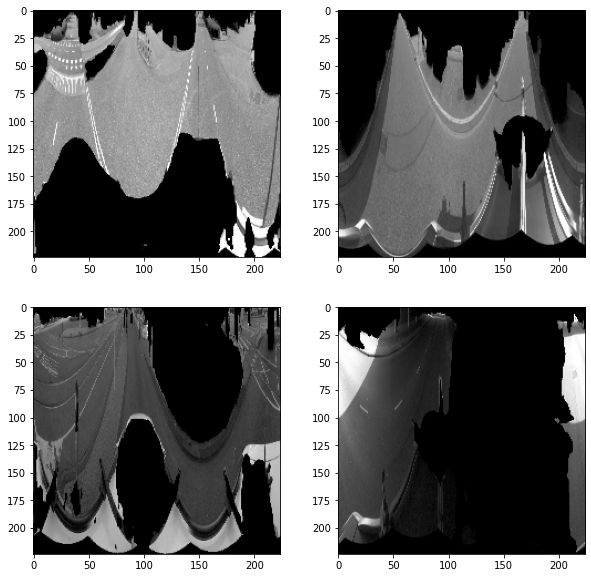

In [13]:
# visualizing images
i = 50
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(train_data[i][0][1], cmap='gray')
plt.subplot(222), plt.imshow(train_data[i+25][0][1], cmap='gray')
plt.subplot(223), plt.imshow(train_data[i+50][0][1], cmap='gray')
plt.subplot(224), plt.imshow(train_data[i+75][0][1], cmap='gray')

In [14]:
class final_layers(nn.Module):
    def __init__(self):
        super(final_layers, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layers(x)
        return x.squeeze()

In [15]:
# defining the model
model = models.resnet34(pretrained=True)
#set_parameter_requires_grad(model,0)
model.fc = final_layers()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.0003)
# defining the loss function
criterion = BCELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

print(model)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [16]:
''' SEED Everything '''
def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True 
SEED=42
seed_everything(SEED=SEED)
''' SEED Everything '''
# set computation device
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")

Computation device: cuda:0


In [17]:
#validation function
def validate(model, test_dataloader):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_dataloader), total=int(len(test_data)/test_dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs.float(), target.float())
            val_running_loss += loss.item()
            preds = torch.round(outputs.data)
            val_running_correct += (preds == target).sum().item()
            true_positives += ((preds == 1)&(target == 1)).sum().item()
            true_negatives += ((preds == 0)&(target == 0)).sum().item()
            false_positives += ((preds == 1)&(target == 0)).sum().item()
            false_negatives += ((preds == 0)&(target == 1)).sum().item()
        
        if true_positives+false_positives>0:
          precision = true_positives/(true_positives+false_positives)
        else:
          precision = 0
        recall = true_positives/(true_positives+false_negatives)
        if ((precision>0)&(recall>0)):
          f1 = 2 * (precision*recall)/(precision+recall)
        else:
          f1 = 0
        val_loss = val_running_loss/max(int(len(test_data)/test_dataloader.batch_size),1)
        val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
        print(f"Recall: {recall:.4f}, Precision: {precision:.2f}, F1: {f1:.2f}")
        
        return val_loss, val_accuracy, f1

In [18]:
# training function
def fit(model, train_dataloader):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    for i, data in tqdm(enumerate(train_dataloader), total=int(len(train_data)/train_dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs.float(), target.float())
        train_running_loss += loss.item()
        preds = torch.round(outputs.data)
        train_running_correct += (preds == target).sum().item()
        true_positives += ((preds == 1)&(target == 1)).sum().item()
        true_negatives += ((preds == 0)&(target == 0)).sum().item()
        false_positives += ((preds == 1)&(target == 0)).sum().item()
        false_negatives += ((preds == 0)&(target == 1)).sum().item()
        loss.backward()
        optimizer.step()
    
    if true_positives+false_positives>0:
      precision = true_positives/(true_positives+false_positives)
    else:
      precision = 0
    recall = true_positives/(true_positives+false_negatives)
    if ((precision>0)&(recall>0)):
      f1 = 2 * (precision*recall)/(precision+recall)
    else:
      f1 = 0
    train_loss = train_running_loss/int(len(train_data)/train_dataloader.batch_size)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
    print(f"Recall: {recall:.4f}, Precision: {precision:.2f}, F1: {f1:.2f}")
    
    return train_loss, train_accuracy, f1

In [19]:
train_loss , train_accuracy , train_f1 = [], [], []
val_loss , val_accuracy, val_f1 = [], [], []
start = time.time()
epochs = 75
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy, train_epoch_f1 = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy, val_epoch_f1 = validate(model, testloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    train_f1.append(train_epoch_f1)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    val_f1.append(val_epoch_f1)
    path = "/content/drive/MyDrive/Owen/resnet_mask_multiplied_output/epoch" + str(epoch)
    torch.save(model.state_dict(), path)
end = time.time()
print(f"{(end-start)/60:.3f} minutes")

  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 1 of 75
Training


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
147it [4:00:12, 98.05s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.4146, Train Acc: 80.46
Recall: 0.5888, Precision: 0.80, F1: 0.68
Validating


18it [26:53, 89.63s/it]


Val Loss: 0.8586, Val Acc: 66.78
Recall: 0.6578, Precision: 0.47, F1: 0.55


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 2 of 75
Training


147it [14:33,  5.94s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.2659, Train Acc: 87.98
Recall: 0.7134, Precision: 0.92, F1: 0.80
Validating


18it [01:39,  5.55s/it]


Val Loss: 0.9267, Val Acc: 77.58
Recall: 0.3251, Precision: 0.86, F1: 0.47


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 3 of 75
Training


147it [14:37,  5.97s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.2116, Train Acc: 90.28
Recall: 0.7527, Precision: 0.96, F1: 0.84
Validating


18it [01:39,  5.54s/it]


Val Loss: 0.9391, Val Acc: 74.16
Recall: 0.5352, Precision: 0.59, F1: 0.56


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 4 of 75
Training


147it [14:18,  5.84s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.1926, Train Acc: 90.99
Recall: 0.7645, Precision: 0.97, F1: 0.86
Validating


18it [01:35,  5.32s/it]


Val Loss: 1.1659, Val Acc: 77.44
Recall: 0.3850, Precision: 0.77, F1: 0.51


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 5 of 75
Training


147it [14:10,  5.79s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.1762, Train Acc: 91.62
Recall: 0.7739, Precision: 0.98, F1: 0.87
Validating


18it [01:39,  5.51s/it]


Val Loss: 0.8770, Val Acc: 72.23
Recall: 0.5380, Precision: 0.55, F1: 0.54


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 6 of 75
Training


147it [14:17,  5.83s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.1686, Train Acc: 91.89
Recall: 0.7789, Precision: 0.98, F1: 0.87
Validating


18it [01:39,  5.51s/it]


Val Loss: 1.4286, Val Acc: 76.27
Recall: 0.3964, Precision: 0.70, F1: 0.51


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 7 of 75
Training


147it [13:37,  5.56s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.1710, Train Acc: 91.81
Recall: 0.7770, Precision: 0.98, F1: 0.87
Validating


18it [01:32,  5.14s/it]


Val Loss: 1.1218, Val Acc: 77.23
Recall: 0.4040, Precision: 0.74, F1: 0.52


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 8 of 75
Training


147it [13:40,  5.58s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.1612, Train Acc: 92.18
Recall: 0.7825, Precision: 0.99, F1: 0.87
Validating


18it [01:30,  5.04s/it]


Val Loss: 0.8478, Val Acc: 79.31
Recall: 0.4952, Precision: 0.75, F1: 0.60


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 9 of 75
Training


147it [13:38,  5.57s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.1625, Train Acc: 92.11
Recall: 0.7818, Precision: 0.99, F1: 0.87
Validating


18it [01:32,  5.16s/it]


Val Loss: 1.7203, Val Acc: 75.24
Recall: 0.3907, Precision: 0.67, F1: 0.49


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 10 of 75
Training


147it [13:37,  5.56s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.1668, Train Acc: 91.97
Recall: 0.7794, Precision: 0.99, F1: 0.87
Validating


18it [01:31,  5.09s/it]


Val Loss: 0.8659, Val Acc: 79.16
Recall: 0.4743, Precision: 0.76, F1: 0.58


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 11 of 75
Training


147it [13:25,  5.48s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.1533, Train Acc: 92.52
Recall: 0.7879, Precision: 1.00, F1: 0.88
Validating


18it [01:31,  5.08s/it]


Val Loss: 1.2376, Val Acc: 78.67
Recall: 0.4857, Precision: 0.73, F1: 0.58


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 12 of 75
Training


147it [13:33,  5.53s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.1600, Train Acc: 92.26
Recall: 0.7840, Precision: 0.99, F1: 0.88
Validating


18it [01:36,  5.36s/it]


Val Loss: 1.2700, Val Acc: 74.83
Recall: 0.4791, Precision: 0.62, F1: 0.54


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 13 of 75
Training


147it [13:48,  5.64s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.1625, Train Acc: 92.13
Recall: 0.7822, Precision: 0.99, F1: 0.87
Validating


18it [01:33,  5.20s/it]


Val Loss: 1.0744, Val Acc: 75.42
Recall: 0.5846, Precision: 0.60, F1: 0.59


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 14 of 75
Training


147it [14:03,  5.74s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.1613, Train Acc: 92.21
Recall: 0.7829, Precision: 0.99, F1: 0.87
Validating


18it [01:33,  5.19s/it]


Val Loss: 1.0554, Val Acc: 74.92
Recall: 0.3793, Precision: 0.66, F1: 0.48


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 15 of 75
Training


147it [13:34,  5.54s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.1590, Train Acc: 92.32
Recall: 0.7855, Precision: 0.99, F1: 0.88
Validating


18it [01:33,  5.20s/it]


Val Loss: 1.4376, Val Acc: 77.96
Recall: 0.4544, Precision: 0.73, F1: 0.56


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 16 of 75
Training


147it [13:37,  5.56s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.1573, Train Acc: 92.34
Recall: 0.7847, Precision: 0.99, F1: 0.88
Validating


18it [01:33,  5.19s/it]


Val Loss: 1.1749, Val Acc: 75.07
Recall: 0.5361, Precision: 0.61, F1: 0.57


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 17 of 75
Training


147it [13:39,  5.58s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.1533, Train Acc: 92.46
Recall: 0.7874, Precision: 0.99, F1: 0.88
Validating


18it [01:34,  5.23s/it]


Val Loss: 1.1116, Val Acc: 79.48
Recall: 0.4439, Precision: 0.80, F1: 0.57


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 18 of 75
Training


  6%|▌         | 9/146 [00:49<12:22,  5.42s/it]

IndexError: ignored

In [20]:
for i,val in enumerate(val_f1):
  if val==max(val_f1):
    print(i)

7


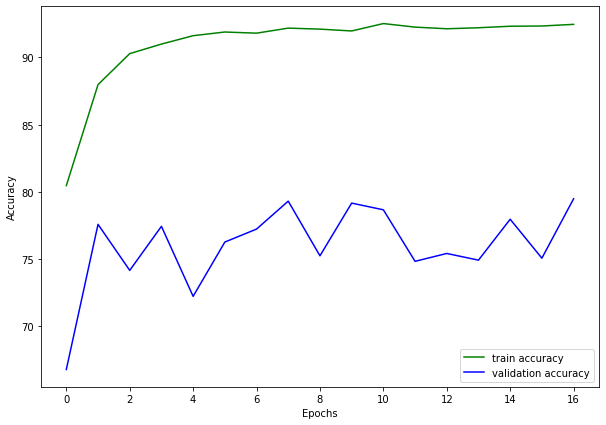

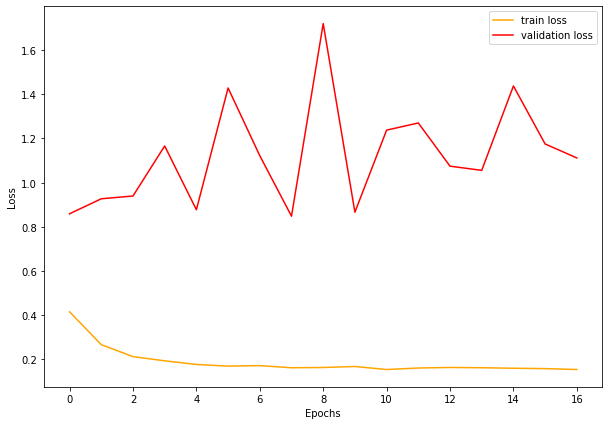

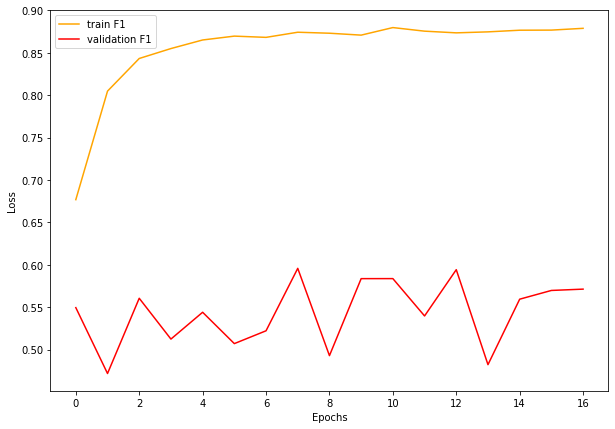

In [21]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig('/content/drive/MyDrive/Owen/accuracy.png')
plt.show()
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('/content/drive/MyDrive/Owen/loss.png')
plt.show()
# F1 plots
plt.figure(figsize=(10, 7))
plt.plot(train_f1, color='orange', label='train F1')
plt.plot(val_f1, color='red', label='validation F1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('/content/drive/MyDrive/Owen/loss.png')
plt.show()

In [22]:
blind_test = pd.read_csv("/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/test.csv")

In [23]:
blind_test = blind_test.drop("Unnamed: 0", axis="columns")
blind_test = blind_test.rename(columns={'Unnamed: 0.1':'image_name'})

In [24]:
blind_test['image_path'] = "/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/" + blind_test['image_name'].astype("str") + ".jpeg"

In [ ]:
i = -1
for image_number in tqdm(blind_test['image_name']):
  i = i+1
  if i > -1:
    oldpath = "/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/" + str(image_number) + ".jpeg"
    newpath = "/content/drive/MyDrive/Owen/segmented_images_blind_test/" + str(image_number) + ".jpeg"
    im = cv2.imread(oldpath)
    panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
    new_dict = {}
    id = 999
    for item in segments_info:
      category_id = item['category_id']
      if category_id == 21:
        id = item['id']
    if id==999:
      print(oldpath)
    road = (panoptic_seg==id)
    road = np.repeat(road.cpu()[:, :, np.newaxis], 3, axis=2)
    newimage = np.array(road)*np.array(im)
    cv2.imwrite(newpath,newimage)

Streaming output truncated to the last 5000 lines.



 12%|█▏        | 437/3736 [01:52<13:14,  4.15it/s]



 12%|█▏        | 438/3736 [01:52<12:56,  4.25it/s]



 12%|█▏        | 439/3736 [01:52<12:51,  4.28it/s]



 12%|█▏        | 440/3736 [01:52<13:04,  4.20it/s]



 12%|█▏        | 441/3736 [01:53<12:51,  4.27it/s]



 12%|█▏        | 442/3736 [01:53<12:51,  4.27it/s]



 12%|█▏        | 443/3736 [01:53<12:48,  4.29it/s]



 12%|█▏        | 444/3736 [01:53<12:50,  4.27it/s]



 12%|█▏        | 445/3736 [01:54<12:41,  4.32it/s]



 12%|█▏        | 446/3736 [01:54<12:45,  4.30it/s]



 12%|█▏        | 447/3736 [01:54<12:41,  4.32it/s]



 12%|█▏        | 448/3736 [01:54<12:47,  4.28it/s]



 12%|█▏        | 449/3736 [01:54<13:10,  4.16it/s]



 12%|█▏        | 450/3736 [01:55<13:23,  4.09it/s]



 12%|█▏        | 451/3736 [01:55<13:38,  4.01it/s]



 12%|█▏        | 452/3736 [01:55<13:48,  3.97it/s]



 12%|█▏        | 453/3736 [01:55<13:34,  4.03it/s]



 12%|█▏        | 454/3736 [0

/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/19105.jpeg






 45%|████▌     | 1687/3736 [07:22<08:20,  4.10it/s]



 45%|████▌     | 1688/3736 [07:22<08:18,  4.11it/s]

/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/19107.jpeg






 45%|████▌     | 1689/3736 [07:23<08:23,  4.07it/s]

/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/19108.jpeg






 45%|████▌     | 1690/3736 [07:23<08:13,  4.15it/s]



 45%|████▌     | 1691/3736 [07:23<08:09,  4.18it/s]



 45%|████▌     | 1692/3736 [07:23<08:04,  4.22it/s]



 45%|████▌     | 1693/3736 [07:24<07:57,  4.27it/s]

/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/19112.jpeg






 45%|████▌     | 1694/3736 [07:24<07:59,  4.26it/s]

/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/19113.jpeg






 45%|████▌     | 1695/3736 [07:24<07:59,  4.26it/s]



 45%|████▌     | 1696/3736 [07:24<07:58,  4.26it/s]



 45%|████▌     | 1697/3736 [07:25<08:05,  4.20it/s]



 45%|████▌     | 1698/3736 [07:25<07:59,  4.25it/s]

/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/19117.jpeg






 45%|████▌     | 1699/3736 [07:25<08:05,  4.20it/s]



 46%|████▌     | 1700/3736 [07:25<08:59,  3.78it/s]



 46%|████▌     | 1701/3736 [07:26<08:44,  3.88it/s]



 46%|████▌     | 1702/3736 [07:26<08:27,  4.01it/s]



 46%|████▌     | 1703/3736 [07:26<08:18,  4.08it/s]



 46%|████▌     | 1704/3736 [07:26<08:12,  4.13it/s]



 46%|████▌     | 1705/3736 [07:26<08:11,  4.13it/s]



 46%|████▌     | 1706/3736 [07:27<08:07,  4.16it/s]



 46%|████▌     | 1707/3736 [07:27<08:02,  4.21it/s]



 46%|████▌     | 1708/3736 [07:27<08:20,  4.05it/s]



 46%|████▌     | 1709/3736 [07:28<08:39,  3.90it/s]



 46%|████▌     | 1710/3736 [07:28<08:41,  3.89it/s]



 46%|████▌     | 1711/3736 [07:28<08:45,  3.85it/s]



 46%|████▌     | 1712/3736 [07:28<08:46,  3.84it/s]



 46%|████▌     | 1713/3736 [07:29<08:45,  3.85it/s]



 46%|████▌     | 1714/3736 [07:29<08:46,  3.84it/s]



 46%|████▌     | 1715/3736 [07:29<08:44,  3.85it/s]



 46%|████▌     | 1716/3736 [07:29<08:39,  3.89it/s]



 46%|█

/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/22613.jpeg






 55%|█████▌    | 2072/3736 [09:05<06:50,  4.05it/s]



 55%|█████▌    | 2073/3736 [09:05<06:47,  4.08it/s]

/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/22615.jpeg






 56%|█████▌    | 2074/3736 [09:05<06:50,  4.05it/s]



 56%|█████▌    | 2075/3736 [09:06<06:43,  4.11it/s]



 56%|█████▌    | 2076/3736 [09:06<06:46,  4.09it/s]



 56%|█████▌    | 2077/3736 [09:06<06:42,  4.12it/s]



 56%|█████▌    | 2078/3736 [09:06<06:43,  4.11it/s]



 56%|█████▌    | 2079/3736 [09:07<06:39,  4.15it/s]



 56%|█████▌    | 2080/3736 [09:07<06:40,  4.14it/s]



 56%|█████▌    | 2081/3736 [09:07<06:35,  4.19it/s]



 56%|█████▌    | 2082/3736 [09:07<06:38,  4.15it/s]



 56%|█████▌    | 2083/3736 [09:07<06:34,  4.19it/s]



 56%|█████▌    | 2084/3736 [09:08<06:39,  4.13it/s]



 56%|█████▌    | 2085/3736 [09:08<06:35,  4.17it/s]



 56%|█████▌    | 2086/3736 [09:08<06:47,  4.05it/s]



 56%|█████▌    | 2087/3736 [09:08<06:37,  4.14it/s]



 56%|█████▌    | 2088/3736 [09:09<06:40,  4.11it/s]



 56%|█████▌    | 2089/3736 [09:09<06:45,  4.06it/s]



 56%|█████▌    | 2090/3736 [09:09<06:45,  4.06it/s]



 56%|█████▌    | 2091/3736 [09:09<07:03,  3.89it/s]



 56%|█

/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/23908.jpeg






 60%|██████    | 2247/3736 [09:50<06:30,  3.81it/s]



 60%|██████    | 2248/3736 [09:50<06:33,  3.79it/s]



 60%|██████    | 2249/3736 [09:51<06:51,  3.62it/s]



 60%|██████    | 2250/3736 [09:51<06:45,  3.67it/s]



 60%|██████    | 2251/3736 [09:51<06:51,  3.61it/s]



 60%|██████    | 2252/3736 [09:52<06:43,  3.68it/s]



 60%|██████    | 2253/3736 [09:52<06:37,  3.73it/s]



 60%|██████    | 2254/3736 [09:52<06:26,  3.84it/s]



 60%|██████    | 2255/3736 [09:52<06:18,  3.91it/s]



 60%|██████    | 2256/3736 [09:52<06:09,  4.01it/s]



 60%|██████    | 2257/3736 [09:53<06:03,  4.07it/s]



 60%|██████    | 2258/3736 [09:53<06:14,  3.95it/s]



 60%|██████    | 2259/3736 [09:53<06:18,  3.90it/s]



 60%|██████    | 2260/3736 [09:54<06:25,  3.83it/s]



 61%|██████    | 2261/3736 [09:54<06:26,  3.82it/s]



 61%|██████    | 2262/3736 [09:54<06:24,  3.84it/s]



 61%|██████    | 2263/3736 [09:54<06:29,  3.78it/s]



 61%|██████    | 2264/3736 [09:55<06:27,  3.80it/s]



 61%|█

/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/28638.jpeg






 76%|███████▌  | 2821/3736 [12:21<03:55,  3.88it/s]



 76%|███████▌  | 2822/3736 [12:21<03:49,  3.99it/s]

/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/28640.jpeg






 76%|███████▌  | 2823/3736 [12:21<03:51,  3.94it/s]



 76%|███████▌  | 2824/3736 [12:21<03:46,  4.02it/s]

/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/28642.jpeg






 76%|███████▌  | 2825/3736 [12:22<03:48,  3.99it/s]



 76%|███████▌  | 2826/3736 [12:22<03:51,  3.93it/s]



 76%|███████▌  | 2827/3736 [12:22<03:45,  4.03it/s]



 76%|███████▌  | 2828/3736 [12:22<03:42,  4.09it/s]



 76%|███████▌  | 2829/3736 [12:23<03:41,  4.09it/s]



 76%|███████▌  | 2830/3736 [12:23<03:40,  4.11it/s]



 76%|███████▌  | 2831/3736 [12:23<03:39,  4.13it/s]



 76%|███████▌  | 2832/3736 [12:23<03:40,  4.11it/s]



 76%|███████▌  | 2833/3736 [12:24<03:37,  4.15it/s]



 76%|███████▌  | 2834/3736 [12:24<03:36,  4.17it/s]



 76%|███████▌  | 2835/3736 [12:24<03:35,  4.18it/s]



 76%|███████▌  | 2836/3736 [12:24<03:37,  4.14it/s]



 76%|███████▌  | 2837/3736 [12:25<03:44,  4.00it/s]



 76%|███████▌  | 2838/3736 [12:25<03:44,  4.00it/s]



 76%|███████▌  | 2839/3736 [12:25<03:41,  4.05it/s]



 76%|███████▌  | 2840/3736 [12:25<03:42,  4.03it/s]



 76%|███████▌  | 2841/3736 [12:26<03:43,  4.01it/s]



 76%|███████▌  | 2842/3736 [12:26<03:45,  3.97it/s]



 76%|█

/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/28665.jpeg






 76%|███████▌  | 2848/3736 [12:27<03:40,  4.02it/s]



 76%|███████▋  | 2849/3736 [12:27<03:35,  4.11it/s]

/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/28667.jpeg






 76%|███████▋  | 2850/3736 [12:28<03:39,  4.03it/s]



 76%|███████▋  | 2851/3736 [12:28<03:36,  4.09it/s]

/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/28669.jpeg






 76%|███████▋  | 2852/3736 [12:28<03:45,  3.93it/s]



 76%|███████▋  | 2853/3736 [12:29<03:42,  3.96it/s]



 76%|███████▋  | 2854/3736 [12:29<03:41,  3.99it/s]



 76%|███████▋  | 2855/3736 [12:29<03:38,  4.02it/s]



 76%|███████▋  | 2856/3736 [12:29<03:37,  4.04it/s]



 76%|███████▋  | 2857/3736 [12:29<03:34,  4.10it/s]



 76%|███████▋  | 2858/3736 [12:30<03:33,  4.12it/s]



 77%|███████▋  | 2859/3736 [12:30<03:31,  4.15it/s]



 77%|███████▋  | 2860/3736 [12:30<03:32,  4.12it/s]



 77%|███████▋  | 2861/3736 [12:30<03:31,  4.13it/s]



 77%|███████▋  | 2862/3736 [12:31<03:30,  4.15it/s]



 77%|███████▋  | 2863/3736 [12:31<03:27,  4.20it/s]



 77%|███████▋  | 2864/3736 [12:31<03:28,  4.18it/s]



 77%|███████▋  | 2865/3736 [12:31<03:28,  4.18it/s]



 77%|███████▋  | 2866/3736 [12:32<03:29,  4.15it/s]



 77%|███████▋  | 2867/3736 [12:32<03:26,  4.22it/s]



 77%|███████▋  | 2868/3736 [12:32<03:27,  4.19it/s]



 77%|███████▋  | 2869/3736 [12:32<03:31,  4.10it/s]



 77%|█

/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/32140.jpeg






 88%|████████▊ | 3275/3736 [14:17<01:49,  4.19it/s]



 88%|████████▊ | 3276/3736 [14:17<01:47,  4.29it/s]

/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/32142.jpeg






 88%|████████▊ | 3277/3736 [14:17<01:48,  4.22it/s]



 88%|████████▊ | 3278/3736 [14:17<01:47,  4.26it/s]

/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/32144.jpeg






 88%|████████▊ | 3279/3736 [14:18<01:49,  4.16it/s]



 88%|████████▊ | 3280/3736 [14:18<01:48,  4.21it/s]

/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/32146.jpeg






 88%|████████▊ | 3281/3736 [14:18<01:51,  4.08it/s]



 88%|████████▊ | 3282/3736 [14:18<01:48,  4.18it/s]

/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/32148.jpeg






 88%|████████▊ | 3283/3736 [14:19<01:48,  4.19it/s]



 88%|████████▊ | 3284/3736 [14:19<01:47,  4.20it/s]



 88%|████████▊ | 3285/3736 [14:19<01:45,  4.27it/s]



 88%|████████▊ | 3286/3736 [14:19<01:45,  4.25it/s]



 88%|████████▊ | 3287/3736 [14:20<01:45,  4.27it/s]



 88%|████████▊ | 3288/3736 [14:20<01:45,  4.26it/s]



 88%|████████▊ | 3289/3736 [14:20<01:46,  4.19it/s]



 88%|████████▊ | 3290/3736 [14:20<01:45,  4.21it/s]



 88%|████████▊ | 3291/3736 [14:21<01:44,  4.25it/s]



 88%|████████▊ | 3292/3736 [14:21<01:44,  4.24it/s]



 88%|████████▊ | 3293/3736 [14:21<01:43,  4.29it/s]



 88%|████████▊ | 3294/3736 [14:21<01:44,  4.24it/s]



 88%|████████▊ | 3295/3736 [14:21<01:42,  4.31it/s]



 88%|████████▊ | 3296/3736 [14:22<01:45,  4.16it/s]



 88%|████████▊ | 3297/3736 [14:22<01:43,  4.26it/s]



 88%|████████▊ | 3298/3736 [14:22<01:44,  4.21it/s]



 88%|████████▊ | 3299/3736 [14:22<01:41,  4.29it/s]

/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/32165.jpeg






 88%|████████▊ | 3300/3736 [14:23<01:43,  4.22it/s]



 88%|████████▊ | 3301/3736 [14:23<01:41,  4.28it/s]

/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/32167.jpeg






 88%|████████▊ | 3302/3736 [14:23<01:42,  4.22it/s]



 88%|████████▊ | 3303/3736 [14:23<01:44,  4.16it/s]

/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/32169.jpeg






 88%|████████▊ | 3304/3736 [14:24<01:46,  4.07it/s]



 88%|████████▊ | 3305/3736 [14:24<01:43,  4.15it/s]

/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/32171.jpeg






 88%|████████▊ | 3306/3736 [14:24<01:46,  4.04it/s]



 89%|████████▊ | 3307/3736 [14:24<01:44,  4.12it/s]

/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/32173.jpeg






 89%|████████▊ | 3308/3736 [14:25<01:46,  4.02it/s]



 89%|████████▊ | 3309/3736 [14:25<01:47,  3.97it/s]



 89%|████████▊ | 3310/3736 [14:25<01:51,  3.84it/s]



 89%|████████▊ | 3311/3736 [14:25<01:52,  3.77it/s]



 89%|████████▊ | 3312/3736 [14:26<01:54,  3.71it/s]



 89%|████████▊ | 3313/3736 [14:26<01:56,  3.64it/s]



 89%|████████▊ | 3314/3736 [14:26<01:58,  3.56it/s]



 89%|████████▊ | 3315/3736 [14:27<01:56,  3.63it/s]



 89%|████████▉ | 3316/3736 [14:27<01:55,  3.63it/s]



 89%|████████▉ | 3317/3736 [14:27<01:54,  3.65it/s]



 89%|████████▉ | 3318/3736 [14:27<01:56,  3.58it/s]



 89%|████████▉ | 3319/3736 [14:28<01:55,  3.60it/s]



 89%|████████▉ | 3320/3736 [14:28<01:57,  3.55it/s]



 89%|████████▉ | 3321/3736 [14:28<01:56,  3.57it/s]



 89%|████████▉ | 3322/3736 [14:29<01:54,  3.60it/s]



 89%|████████▉ | 3323/3736 [14:29<01:53,  3.63it/s]



 89%|████████▉ | 3324/3736 [14:29<01:55,  3.58it/s]



 89%|████████▉ | 3325/3736 [14:29<01:53,  3.63it/s]



 89%|█

/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/33501.jpeg






 91%|█████████ | 3408/3736 [14:52<01:25,  3.82it/s]



 91%|█████████ | 3409/3736 [14:52<01:24,  3.87it/s]

/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/33503.jpeg






 91%|█████████▏| 3410/3736 [14:52<01:24,  3.86it/s]



 91%|█████████▏| 3411/3736 [14:53<01:24,  3.87it/s]



 91%|█████████▏| 3412/3736 [14:53<01:23,  3.90it/s]



 91%|█████████▏| 3413/3736 [14:53<01:24,  3.81it/s]



 91%|█████████▏| 3414/3736 [14:53<01:23,  3.88it/s]



 91%|█████████▏| 3415/3736 [14:54<01:21,  3.93it/s]



 91%|█████████▏| 3416/3736 [14:54<01:19,  4.01it/s]



 91%|█████████▏| 3417/3736 [14:54<01:19,  4.02it/s]



 91%|█████████▏| 3418/3736 [14:54<01:19,  4.02it/s]



 92%|█████████▏| 3419/3736 [14:55<01:17,  4.10it/s]



 92%|█████████▏| 3420/3736 [14:55<01:17,  4.10it/s]



 92%|█████████▏| 3421/3736 [14:55<01:16,  4.14it/s]



 92%|█████████▏| 3422/3736 [14:55<01:16,  4.11it/s]

/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/33516.jpeg






 92%|█████████▏| 3423/3736 [14:56<01:15,  4.13it/s]



 92%|█████████▏| 3424/3736 [14:56<01:17,  4.02it/s]

/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/33518.jpeg






 92%|█████████▏| 3425/3736 [14:56<01:17,  4.04it/s]



 92%|█████████▏| 3426/3736 [14:56<01:18,  3.96it/s]



 92%|█████████▏| 3427/3736 [14:57<01:16,  4.02it/s]



 92%|█████████▏| 3428/3736 [14:57<01:17,  3.98it/s]



 92%|█████████▏| 3429/3736 [14:57<01:17,  3.98it/s]



 92%|█████████▏| 3430/3736 [14:57<01:15,  4.05it/s]



 92%|█████████▏| 3431/3736 [14:58<01:13,  4.14it/s]



 92%|█████████▏| 3432/3736 [14:58<01:14,  4.09it/s]



 92%|█████████▏| 3433/3736 [14:58<01:13,  4.12it/s]



 92%|█████████▏| 3434/3736 [14:58<01:14,  4.04it/s]



 92%|█████████▏| 3435/3736 [14:59<01:15,  3.97it/s]



 92%|█████████▏| 3436/3736 [14:59<01:15,  3.96it/s]



 92%|█████████▏| 3437/3736 [14:59<01:14,  4.04it/s]



 92%|█████████▏| 3438/3736 [14:59<01:13,  4.05it/s]



 92%|█████████▏| 3439/3736 [15:00<01:13,  4.07it/s]



 92%|█████████▏| 3440/3736 [15:00<01:14,  3.97it/s]



 92%|█████████▏| 3441/3736 [15:00<01:14,  3.94it/s]



 92%|█████████▏| 3442/3736 [15:00<01:16,  3.86it/s]



 92%|█

/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/34205.jpeg






 95%|█████████▌| 3560/3736 [15:31<00:41,  4.19it/s]



 95%|█████████▌| 3561/3736 [15:31<00:42,  4.16it/s]



 95%|█████████▌| 3562/3736 [15:31<00:42,  4.07it/s]



 95%|█████████▌| 3563/3736 [15:31<00:43,  3.94it/s]



 95%|█████████▌| 3564/3736 [15:32<00:46,  3.69it/s]



 95%|█████████▌| 3565/3736 [15:32<00:47,  3.61it/s]



 95%|█████████▌| 3566/3736 [15:32<00:46,  3.64it/s]



 95%|█████████▌| 3567/3736 [15:33<00:45,  3.71it/s]



 96%|█████████▌| 3568/3736 [15:33<00:44,  3.77it/s]



 96%|█████████▌| 3569/3736 [15:33<00:43,  3.81it/s]



 96%|█████████▌| 3570/3736 [15:33<00:43,  3.78it/s]



 96%|█████████▌| 3571/3736 [15:34<00:43,  3.79it/s]



 96%|█████████▌| 3572/3736 [15:34<00:42,  3.83it/s]



 96%|█████████▌| 3573/3736 [15:34<00:42,  3.86it/s]



 96%|█████████▌| 3574/3736 [15:34<00:42,  3.84it/s]



 96%|█████████▌| 3575/3736 [15:35<00:42,  3.80it/s]



 96%|█████████▌| 3576/3736 [15:35<00:41,  3.86it/s]



 96%|█████████▌| 3577/3736 [15:35<00:41,  3.83it/s]



 96%|█

In [25]:
blind_test['segmented_image_path'] = "/content/drive/MyDrive/Owen/segmented_images_blind_test/" + blind_test['image_name'].astype("str") + ".jpeg"

In [26]:
blind_test['inspection_id'] = blind_test['road_id'] + blind_test['inspection_date']

In [27]:
inspection_ids = blind_test.inspection_id.unique()
x_blind = blind_test.segmented_image_path.values
y_blind = blind_test.cracking_binary.values
inspections_x = blind_test.inspection_id.values
inspections_y = blind_test['cracking_binary'].groupby(by=inspections_x).max()

In [28]:
from sklearn.metrics import f1_score

for a in range(7,8):
  print(a)
  model.load_state_dict(torch.load("/content/drive/MyDrive/Owen/resnet_mask_multiplied_output/epoch" + str(a)))
  model.eval
  road_truths = []
  max_preds = []
  mean_preds = []
  majority_preds = []
  toptwo_preds = []
  product_preds = []
  probabilities = []
  for i,inspection in tqdm(enumerate(inspection_ids), total=len(inspection_ids)):
      images_x = x_blind[inspections_x==inspection]
      images_y = y_blind[inspections_x==inspection]
      test_data = pano_images(images_x, images_y, tfms=0)
      with torch.no_grad():
        test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
        for i, data in enumerate(test_dataloader):
          data = data[0].to(device)
          outputs = model(data)
          road_truth = np.amax(images_y)
          max_pred = torch.round(torch.max(outputs.data)).item()
          probability = torch.max(outputs.data).item()
          mean_pred = torch.round(torch.mean(outputs.data)).item()
          majority_pred = torch.round(torch.mean(torch.round(outputs.data))).item()
          product_pred = torch.round(1-torch.prod(1-outputs.data)).item()
          if len(outputs.size())==0:
            top2_pred = torch.round(torch.max(outputs)).item()
          else:
            top2 = torch.topk(outputs, 2).values
            top2_pred = torch.round(torch.mean(top2)).item()
          road_truths.append(road_truth)
          max_preds.append(max_pred)
          mean_preds.append(mean_pred)
          majority_preds.append(majority_pred)
          toptwo_preds.append(top2_pred)
          product_preds.append(product_pred)
          probabilities.append(probability)
  f1_max = f1_score(road_truths, max_preds)
  f1_mean = f1_score(road_truths, mean_preds)
  f1_majority = f1_score(road_truths, majority_preds)
  f1_top2 = f1_score(road_truths, toptwo_preds)
  f1_product = f1_score(road_truths, product_preds)
  print(f1_max, f1_mean, f1_majority, f1_top2,f1_product)


  0%|          | 0/213 [00:00<?, ?it/s]

7



100%|██████████| 213/213 [33:52<00:00,  9.54s/it]

0.49027237354085607 0.02777777777777778 0.0 0.5 0.48837209302325585


In [29]:
from sklearn import metrics

print(metrics.confusion_matrix(road_truths, max_preds))
print(metrics.f1_score(road_truths, max_preds))
print(metrics.precision_score(road_truths, max_preds))
print(metrics.recall_score(road_truths, max_preds))
print(metrics.accuracy_score(road_truths, max_preds))

[[ 19 124]
 [  7  63]]
0.49027237354085607
0.33689839572192515
0.9
0.38497652582159625


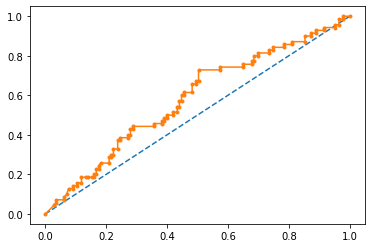

In [30]:
from matplotlib import pyplot
from sklearn import metrics as metric
ns_probs = [0 for _ in range(len(road_truths))]
ns_fpr, ns_tpr, _ = metric.roc_curve(road_truths, ns_probs)
lr_fpr, lr_tpr, _ = metric.roc_curve(road_truths, probabilities)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

In [31]:
ROC = pd.DataFrame({'FPR':lr_fpr,
                    'TPR':lr_tpr})

In [32]:
ROC.to_csv("/content/drive/MyDrive/Owen/final_results/baseline_masked.csv")

# ResNet Baseline Pretrained

In [ ]:
labelled_data = pd.read_csv("/content/train_set/train.csv")

In [ ]:
labelled_data = labelled_data.drop("Unnamed: 0", axis="columns")
labelled_data = labelled_data.rename(columns={'Unnamed: 0.1':'image_name'})

In [ ]:
gss = GroupShuffleSplit(n_splits=2, train_size=0.8/0.9, random_state=42)
gss.get_n_splits()
groups = np.array(labelled_data["road_id"])

In [ ]:
train,test = next(gss.split(X = labelled_data, groups = groups))

In [ ]:
labelled_data['image_path'] = "/content/train_set/" + labelled_data['image_name'].astype("str") + ".jpeg"

In [ ]:
xtrain = labelled_data.iloc[train].image_path.values
xtest = labelled_data.iloc[test].image_path.values
ytrain = labelled_data.iloc[train].cracking_binary.values
ytest = labelled_data.iloc[test].cracking_binary.values

In [ ]:
# image dataset module
class pano_images(Dataset):
    def __init__(self, path, labels, tfms=None):
        self.X = path
        self.y = labels
        # apply augmentations
        if tfms == 0: # if validating
            self.aug = albumentations.Compose([
                albumentations.Crop(x_min=0, y_min=500, x_max=2000, y_max=817, always_apply=True),
                albumentations.Resize(224, 224, always_apply=True),
                albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225], always_apply=True)
            ])
        else: # if training
            self.aug = albumentations.Compose([
                albumentations.Crop(x_min=0, y_min=500, x_max=2000, y_max=817, always_apply=True),
                albumentations.Resize(224, 224, always_apply=True),
                albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225], always_apply=True)
            ])
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        image = Image.open(self.X[i])
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        label = self.y[i]
        return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)

In [ ]:
train_data = pano_images(xtrain, ytrain, tfms=1)
test_data = pano_images(xtest, ytest, tfms=0)

trainloader = DataLoader(train_data, batch_size=200, shuffle=True)
testloader = DataLoader(test_data, batch_size=200, shuffle=False)

In [ ]:
print(max(ytest), min(ytest))
print(max(ytrain), min(ytrain))

1 0
1 0


(<matplotlib.axes._subplots.AxesSubplot at 0x7f1d7e6bb110>,
 <matplotlib.image.AxesImage at 0x7f1d7ea60450>)

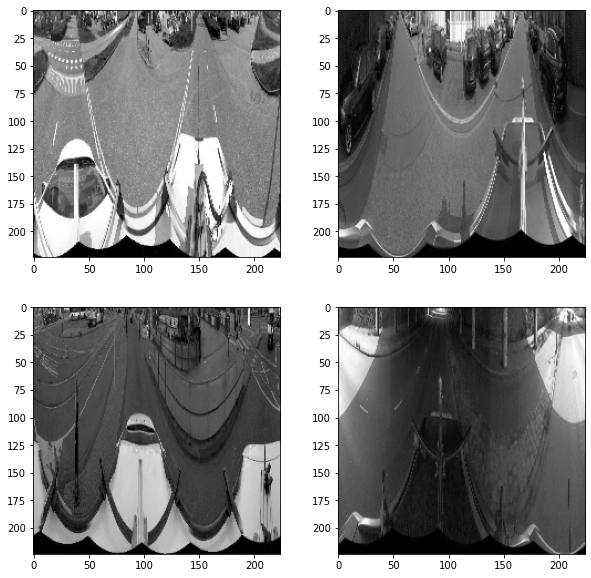

In [ ]:
# visualizing images
i = 50
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(train_data[i][0][2], cmap='gray')
plt.subplot(222), plt.imshow(train_data[i+25][0][2], cmap='gray')
plt.subplot(223), plt.imshow(train_data[i+50][0][2], cmap='gray')
plt.subplot(224), plt.imshow(train_data[i+75][0][2], cmap='gray')

In [ ]:
class final_layers(nn.Module):
    def __init__(self):
        super(final_layers, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layers(x)
        return x.squeeze()

In [ ]:
def set_parameter_requires_grad(model, layers_untrained):
  layers_untrained = min(layers_untrained,61)
  for i,param in enumerate(model.parameters()):
    if i<layers_untrained:
      param.requires_grad = False

In [ ]:
# defining the model
model = models.resnet34(pretrained=False)
#set_parameter_requires_grad(model,0)
model.fc = final_layers()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.0003)
# defining the loss function
criterion = BCELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Owen/resnet_output/epoch32",map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
set_parameter_requires_grad(model, 20)

In [ ]:
''' SEED Everything '''
def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True 
SEED=42
seed_everything(SEED=SEED)
''' SEED Everything '''
# set computation device
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")

Computation device: cuda:0


In [ ]:
#validation function
def validate(model, test_dataloader):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_dataloader), total=int(len(test_data)/test_dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs.float(), target.float())
            val_running_loss += loss.item()
            preds = torch.round(outputs.data)
            val_running_correct += (preds == target).sum().item()
            true_positives += ((preds == 1)&(target == 1)).sum().item()
            true_negatives += ((preds == 0)&(target == 0)).sum().item()
            false_positives += ((preds == 1)&(target == 0)).sum().item()
            false_negatives += ((preds == 0)&(target == 1)).sum().item()
        
        if true_positives+false_positives>0:
          precision = true_positives/(true_positives+false_positives)
        else:
          precision = 0
        recall = true_positives/(true_positives+false_negatives)
        if ((precision>0)&(recall>0)):
          f1 = 2 * (precision*recall)/(precision+recall)
        else:
          f1 = 0
        val_loss = val_running_loss/max(int(len(test_data)/test_dataloader.batch_size),1)
        val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
        print(f"Recall: {recall:.4f}, Precision: {precision:.2f}, F1: {f1:.2f}")
        
        return val_loss, val_accuracy, f1

In [ ]:
# training function
def fit(model, train_dataloader):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    for i, data in tqdm(enumerate(train_dataloader), total=int(len(train_data)/train_dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs.float(), target.float())
        train_running_loss += loss.item()
        preds = torch.round(outputs.data)
        train_running_correct += (preds == target).sum().item()
        true_positives += ((preds == 1)&(target == 1)).sum().item()
        true_negatives += ((preds == 0)&(target == 0)).sum().item()
        false_positives += ((preds == 1)&(target == 0)).sum().item()
        false_negatives += ((preds == 0)&(target == 1)).sum().item()
        loss.backward()
        optimizer.step()
    
    if true_positives+false_positives>0:
      precision = true_positives/(true_positives+false_positives)
    else:
      precision = 0
    recall = true_positives/(true_positives+false_negatives)
    if ((precision>0)&(recall>0)):
      f1 = 2 * (precision*recall)/(precision+recall)
    else:
      f1 = 0
    train_loss = train_running_loss/int(len(train_data)/train_dataloader.batch_size)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
    print(f"Recall: {recall:.4f}, Precision: {precision:.2f}, F1: {f1:.2f}")
    
    return train_loss, train_accuracy, f1

In [ ]:
train_loss , train_accuracy , train_f1 = [], [], []
val_loss , val_accuracy, val_f1 = [], [], []
start = time.time()
epochs = 75
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy, train_epoch_f1 = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy, val_epoch_f1 = validate(model, testloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    train_f1.append(train_epoch_f1)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    val_f1.append(val_epoch_f1)
    path = "/content/drive/MyDrive/Owen/pretrained_resnet_output/epoch" + str(epoch)
    torch.save(model.state_dict(), path)
end = time.time()
print(f"{(end-start)/60:.3f} minutes")


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 1 of 75
Training


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)

100%|██████████| 146/146 [16:07<00:00,  6.69s/it]
147it [16:11,  6.61s/it]

  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0072, Train Acc: 99.74
Recall: 0.9962, Precision: 1.00, F1: 1.00
Validating



100%|██████████| 17/17 [01:51<00:00,  6.50s/it]
18it [01:51,  6.22s/it]


Val Loss: 1.2320, Val Acc: 83.99
Recall: 0.6854, Precision: 0.77, F1: 0.72



  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 2 of 75
Training



100%|██████████| 146/146 [15:45<00:00,  6.53s/it]
147it [15:48,  6.45s/it]

  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0078, Train Acc: 99.73
Recall: 0.9964, Precision: 1.00, F1: 1.00
Validating



100%|██████████| 17/17 [01:50<00:00,  6.40s/it]
18it [01:50,  6.15s/it]


Val Loss: 1.5812, Val Acc: 79.54
Recall: 0.8099, Precision: 0.63, F1: 0.71



  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 3 of 75
Training



100%|██████████| 146/146 [15:28<00:00,  6.04s/it]
147it [15:31,  6.34s/it]

  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0107, Train Acc: 99.64
Recall: 0.9945, Precision: 1.00, F1: 0.99
Validating



100%|██████████| 17/17 [01:43<00:00,  6.18s/it]
18it [01:44,  5.81s/it]


Val Loss: 1.1502, Val Acc: 81.36
Recall: 0.7452, Precision: 0.68, F1: 0.71



  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 4 of 75
Training



100%|██████████| 146/146 [14:51<00:00,  6.06s/it]
147it [14:54,  6.08s/it]

  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0057, Train Acc: 99.78
Recall: 0.9971, Precision: 1.00, F1: 1.00
Validating



100%|██████████| 17/17 [01:44<00:00,  6.27s/it]
18it [01:45,  5.83s/it]


Val Loss: 1.1036, Val Acc: 84.72
Recall: 0.6511, Precision: 0.82, F1: 0.72



  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 5 of 75
Training



100%|██████████| 146/146 [15:00<00:00,  6.33s/it]
147it [15:02,  6.14s/it]

  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0049, Train Acc: 99.83
Recall: 0.9969, Precision: 1.00, F1: 1.00
Validating



100%|██████████| 17/17 [01:44<00:00,  6.13s/it]
18it [01:45,  5.84s/it]


Val Loss: 1.0289, Val Acc: 83.44
Recall: 0.7624, Precision: 0.72, F1: 0.74



  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 6 of 75
Training



100%|██████████| 146/146 [14:58<00:00,  6.28s/it]
147it [15:01,  6.13s/it]

  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0057, Train Acc: 99.78
Recall: 0.9975, Precision: 1.00, F1: 1.00
Validating



100%|██████████| 17/17 [01:45<00:00,  6.26s/it]
18it [01:46,  5.89s/it]


Val Loss: 1.1168, Val Acc: 83.17
Recall: 0.7548, Precision: 0.71, F1: 0.73



  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 7 of 75
Training



100%|██████████| 146/146 [14:49<00:00,  6.00s/it]
147it [14:52,  6.07s/it]

  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0073, Train Acc: 99.70
Recall: 0.9959, Precision: 1.00, F1: 1.00
Validating



100%|██████████| 17/17 [01:46<00:00,  6.10s/it]
18it [01:46,  5.94s/it]


Val Loss: 1.1520, Val Acc: 83.82
Recall: 0.6502, Precision: 0.79, F1: 0.71



  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 8 of 75
Training



100%|██████████| 146/146 [15:14<00:00,  6.39s/it]
147it [15:17,  6.24s/it]

  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0039, Train Acc: 99.86
Recall: 0.9976, Precision: 1.00, F1: 1.00
Validating



100%|██████████| 17/17 [01:46<00:00,  6.28s/it]
18it [01:47,  5.97s/it]


Val Loss: 1.1762, Val Acc: 81.36
Recall: 0.6901, Precision: 0.70, F1: 0.70



  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 9 of 75
Training



100%|██████████| 146/146 [15:21<00:00,  6.37s/it]
147it [15:24,  6.29s/it]

  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0085, Train Acc: 99.71
Recall: 0.9968, Precision: 0.99, F1: 1.00
Validating



100%|██████████| 17/17 [01:45<00:00,  6.16s/it]
18it [01:45,  5.87s/it]


Val Loss: 1.2201, Val Acc: 83.96
Recall: 0.7158, Precision: 0.75, F1: 0.73



  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 10 of 75
Training



100%|██████████| 146/146 [15:10<00:00,  6.32s/it]
147it [15:13,  6.21s/it]

  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0037, Train Acc: 99.85
Recall: 0.9978, Precision: 1.00, F1: 1.00
Validating



100%|██████████| 17/17 [01:42<00:00,  5.96s/it]
18it [01:43,  5.75s/it]


Val Loss: 1.1826, Val Acc: 84.52
Recall: 0.7044, Precision: 0.77, F1: 0.74



  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 11 of 75
Training



100%|██████████| 146/146 [14:55<00:00,  6.05s/it]
147it [14:58,  6.12s/it]

  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0046, Train Acc: 99.82
Recall: 0.9972, Precision: 1.00, F1: 1.00
Validating



100%|██████████| 17/17 [01:44<00:00,  6.03s/it]
18it [01:44,  5.81s/it]


Val Loss: 1.1784, Val Acc: 82.27
Recall: 0.7947, Precision: 0.68, F1: 0.73



  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 12 of 75
Training



100%|██████████| 146/146 [15:08<00:00,  6.37s/it]
147it [15:11,  6.20s/it]

  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0050, Train Acc: 99.80
Recall: 0.9970, Precision: 1.00, F1: 1.00
Validating



100%|██████████| 17/17 [01:49<00:00,  6.38s/it]
18it [01:50,  6.14s/it]


Val Loss: 1.2436, Val Acc: 82.15
Recall: 0.6939, Precision: 0.72, F1: 0.71



  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 13 of 75
Training



100%|██████████| 146/146 [15:46<00:00,  6.56s/it]
147it [15:49,  6.46s/it]

  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0067, Train Acc: 99.74
Recall: 0.9969, Precision: 1.00, F1: 1.00
Validating



100%|██████████| 17/17 [01:50<00:00,  6.37s/it]
18it [01:50,  6.15s/it]


Val Loss: 1.0336, Val Acc: 83.87
Recall: 0.7158, Precision: 0.75, F1: 0.73



  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 14 of 75
Training



100%|██████████| 146/146 [15:42<00:00,  6.38s/it]
147it [15:45,  6.44s/it]

  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0084, Train Acc: 99.69
Recall: 0.9955, Precision: 1.00, F1: 1.00
Validating



100%|██████████| 17/17 [01:50<00:00,  6.52s/it]
18it [01:51,  6.19s/it]


Val Loss: 0.9919, Val Acc: 84.26
Recall: 0.6968, Precision: 0.77, F1: 0.73



  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 15 of 75
Training



100%|██████████| 146/146 [15:47<00:00,  6.43s/it]
147it [15:50,  6.47s/it]

  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0040, Train Acc: 99.83
Recall: 0.9977, Precision: 1.00, F1: 1.00
Validating



100%|██████████| 17/17 [01:49<00:00,  6.27s/it]
18it [01:50,  6.13s/it]


Val Loss: 1.1050, Val Acc: 86.27
Recall: 0.7614, Precision: 0.79, F1: 0.77



  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 16 of 75
Training



100%|██████████| 146/146 [15:52<00:00,  6.42s/it]
147it [15:55,  6.50s/it]

  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0022, Train Acc: 99.88
Recall: 0.9982, Precision: 1.00, F1: 1.00
Validating



100%|██████████| 17/17 [01:50<00:00,  6.58s/it]
18it [01:51,  6.17s/it]


Val Loss: 1.5322, Val Acc: 82.94
Recall: 0.7329, Precision: 0.72, F1: 0.73



  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 17 of 75
Training



100%|██████████| 146/146 [15:47<00:00,  6.56s/it]
147it [15:50,  6.47s/it]

  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0085, Train Acc: 99.82
Recall: 0.9977, Precision: 1.00, F1: 1.00
Validating



100%|██████████| 17/17 [01:50<00:00,  6.56s/it]
18it [01:51,  6.19s/it]


Val Loss: 1.5498, Val Acc: 84.37
Recall: 0.7300, Precision: 0.75, F1: 0.74



  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 18 of 75
Training



100%|██████████| 146/146 [15:48<00:00,  6.69s/it]
147it [15:51,  6.47s/it]

  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0033, Train Acc: 99.87
Recall: 0.9983, Precision: 1.00, F1: 1.00
Validating



100%|██████████| 17/17 [01:48<00:00,  6.40s/it]
18it [01:49,  6.08s/it]


Val Loss: 1.6861, Val Acc: 83.52
Recall: 0.7310, Precision: 0.73, F1: 0.73



  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 19 of 75
Training



100%|██████████| 146/146 [15:51<00:00,  6.36s/it]
147it [15:54,  6.49s/it]

  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0019, Train Acc: 99.89
Recall: 0.9987, Precision: 1.00, F1: 1.00
Validating



100%|██████████| 17/17 [01:50<00:00,  6.43s/it]
18it [01:50,  6.16s/it]


Val Loss: 1.3608, Val Acc: 83.73
Recall: 0.7253, Precision: 0.74, F1: 0.73



  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 20 of 75
Training



100%|██████████| 146/146 [15:45<00:00,  6.50s/it]
147it [15:48,  6.46s/it]

  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0010, Train Acc: 99.93
Recall: 0.9982, Precision: 1.00, F1: 1.00
Validating



100%|██████████| 17/17 [01:49<00:00,  6.53s/it]
18it [01:49,  6.11s/it]


Val Loss: 1.2008, Val Acc: 84.90
Recall: 0.7281, Precision: 0.77, F1: 0.75



  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 21 of 75
Training



100%|██████████| 146/146 [15:44<00:00,  6.40s/it]
147it [15:47,  6.45s/it]

  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0009, Train Acc: 99.91
Recall: 0.9993, Precision: 1.00, F1: 1.00
Validating



100%|██████████| 17/17 [01:50<00:00,  6.61s/it]
18it [01:51,  6.19s/it]


Val Loss: 1.3242, Val Acc: 84.81
Recall: 0.7500, Precision: 0.76, F1: 0.75



  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 22 of 75
Training



100%|██████████| 146/146 [15:43<00:00,  6.57s/it]
147it [15:46,  6.44s/it]

  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0009, Train Acc: 99.92
Recall: 0.9990, Precision: 1.00, F1: 1.00
Validating



100%|██████████| 17/17 [01:49<00:00,  6.37s/it]
18it [01:50,  6.13s/it]


Val Loss: 1.2809, Val Acc: 84.81
Recall: 0.7405, Precision: 0.76, F1: 0.75



  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 23 of 75
Training



100%|██████████| 146/146 [15:39<00:00,  6.18s/it]
147it [15:42,  6.41s/it]

  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0009, Train Acc: 99.93
Recall: 0.9989, Precision: 1.00, F1: 1.00
Validating



100%|██████████| 17/17 [01:42<00:00,  6.02s/it]
18it [01:43,  5.75s/it]


Val Loss: 1.4002, Val Acc: 84.75
Recall: 0.7481, Precision: 0.75, F1: 0.75



  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 24 of 75
Training



100%|██████████| 146/146 [14:39<00:00,  5.89s/it]
147it [14:41,  6.00s/it]

  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0009, Train Acc: 99.91
Recall: 0.9984, Precision: 1.00, F1: 1.00
Validating



100%|██████████| 17/17 [01:43<00:00,  6.07s/it]
18it [01:43,  5.76s/it]


Val Loss: 1.4071, Val Acc: 84.49
Recall: 0.7548, Precision: 0.74, F1: 0.75



  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 25 of 75
Training



100%|██████████| 146/146 [14:44<00:00,  6.12s/it]
147it [14:47,  6.04s/it]

  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0009, Train Acc: 99.93
Recall: 0.9990, Precision: 1.00, F1: 1.00
Validating



100%|██████████| 17/17 [01:40<00:00,  5.82s/it]
18it [01:41,  5.63s/it]


Val Loss: 1.4170, Val Acc: 84.55
Recall: 0.7452, Precision: 0.75, F1: 0.75



  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 26 of 75
Training



100%|██████████| 146/146 [14:44<00:00,  5.90s/it]
147it [14:47,  6.04s/it]

  0%|          | 0/17 [00:00<?, ?it/s]

Train Loss: 0.0009, Train Acc: 99.92
Recall: 0.9988, Precision: 1.00, F1: 1.00
Validating



100%|██████████| 17/17 [01:43<00:00,  6.12s/it]
18it [01:43,  5.77s/it]


Val Loss: 1.4775, Val Acc: 84.55
Recall: 0.7471, Precision: 0.75, F1: 0.75



  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 27 of 75
Training



 92%|█████████▏| 134/146 [13:29<01:14,  6.18s/it]

IndexError: ignored

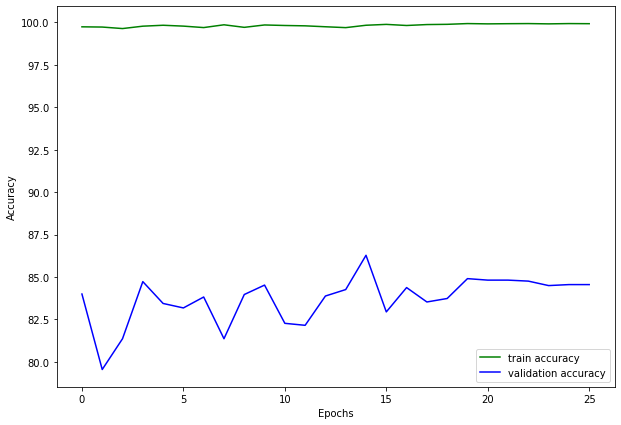

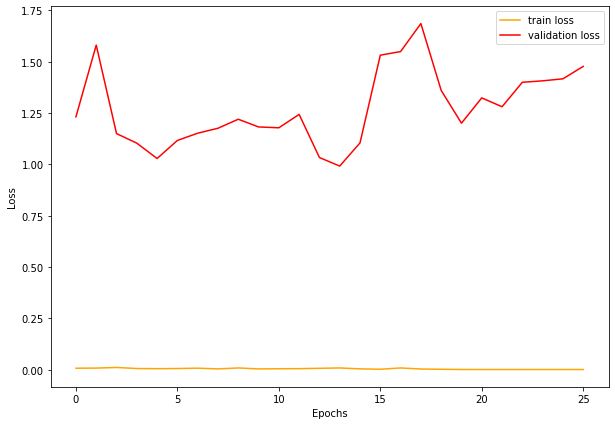

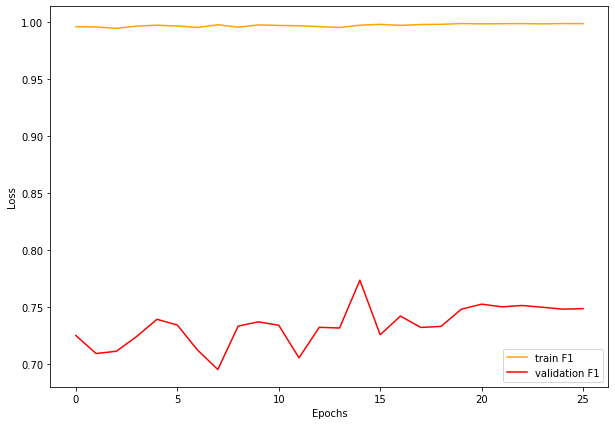

In [ ]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig('/content/drive/MyDrive/Owen/accuracy.png')
plt.show()
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('/content/drive/MyDrive/Owen/loss.png')
plt.show()
# F1 plots
plt.figure(figsize=(10, 7))
plt.plot(train_f1, color='orange', label='train F1')
plt.plot(val_f1, color='red', label='validation F1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('/content/drive/MyDrive/Owen/loss.png')
plt.show()

In [ ]:
for i,val in enumerate(val_f1):
  if val==max(val_f1):
    print(i)

14


In [ ]:
results = pd.DataFrame({'Train Accuracy':train_accuracy,
                        'Validation Accuracy':val_accuracy,
                        'Train Loss':train_loss, 
                        'Validation Loss':val_loss,
                        'Train F1':train_f1,
                        'Validation F1':val_f1}, 
                         columns=['Train Accuracy','Validation Accuracy', 'Train Loss', 'Validation Loss',
                                  'Train F1', "Validation F1"])

In [ ]:
results.to_csv("/content/drive/MyDrive/Owen/final_results/baseline.csv")

In [ ]:
labelled_data['inspection_id'] = labelled_data['road_id'] + labelled_data['inspection_date']

NameError: ignored

In [ ]:
fulltestloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
inspection_ids = labelled_data.iloc[test].inspection_id.unique()
inspections_x = labelled_data.iloc[test].inspection_id.values
inspections_y = labelled_data.loc[test,'cracking_binary'].groupby(by=inspections_x).max()

NameError: ignored

In [ ]:
from sklearn.metrics import f1_score
inspection_ids = labelled_data.iloc[test].inspection_id.unique()
inspections_x = labelled_data.iloc[test].inspection_id.values
inspections_y = labelled_data.loc[test,'cracking_binary'].groupby(by=inspections_x).max()
f1_scores_max = []
f1_scores_mean = []
f1_scores_majority = []
f1_scores_top2 = []
f1_scores_product = []
for a in range(6):
  path = "/content/drive/MyDrive/Owen/resnet_output/epoch" + str(a)
  model.load_state_dict(torch.load(path))
  model.eval
  road_truths = []
  max_preds = []
  mean_preds = []
  majority_preds = []
  toptwo_preds = []
  product_preds = []
  for i,inspection in tqdm(enumerate(inspection_ids), total=len(inspection_ids)):
      images_x = xtest[inspections_x==inspection]
      images_y = ytest[inspections_x==inspection]
      test_data = pano_images(images_x, images_y, tfms=0)
      with torch.no_grad():
        test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
        for i, data in enumerate(test_dataloader):
          data = data[0].to(device)
          outputs = model(data)
          road_truth = np.amax(images_y)
          max_pred = torch.round(torch.max(outputs.data)).item()
          mean_pred = torch.round(torch.mean(outputs.data)).item()
          majority_pred = torch.round(torch.mean(torch.round(outputs.data))).item()
          product_pred = torch.round(1-torch.prod(1-outputs.data)).item()
          if len(outputs.size())==0:
            top2_pred = torch.round(torch.max(outputs)).item()
          else:
            top2 = torch.topk(outputs, 2).values
            top2_pred = torch.round(torch.mean(top2)).item()
          road_truths.append(road_truth)
          max_preds.append(max_pred)
          mean_preds.append(mean_pred)
          majority_preds.append(majority_pred)
          toptwo_preds.append(top2_pred)
          product_preds.append(product_pred)
  f1_max = f1_score(road_truths, max_preds)
  f1_mean = f1_score(road_truths, mean_preds)
  f1_majority = f1_score(road_truths, majority_preds)
  f1_top2 = f1_score(road_truths, toptwo_preds)
  f1_product = f1_score(road_truths, product_preds)
  print(f1_max, f1_mean, f1_majority, f1_top2)
  f1_scores_max.append(f1_max)
  f1_scores_mean.append(f1_mean)
  f1_scores_majority.append(f1_majority)
  f1_scores_top2.append(f1_top2)
  f1_scores_product.append(f1_product)




  0%|          | 0/213 [00:00<?, ?it/s]


  0%|          | 1/213 [00:00<01:01,  3.42it/s]


  1%|          | 2/213 [00:00<01:22,  2.56it/s]


  1%|▏         | 3/213 [00:01<01:14,  2.83it/s]


  2%|▏         | 5/213 [00:02<01:19,  2.62it/s]


  3%|▎         | 6/213 [00:02<01:12,  2.84it/s]


  3%|▎         | 7/213 [00:03<02:07,  1.62it/s]


  4%|▍         | 9/213 [00:05<02:25,  1.41it/s]


  5%|▍         | 10/213 [00:08<04:28,  1.32s/it]


  5%|▌         | 11/213 [00:08<03:16,  1.03it/s]


  6%|▌         | 12/213 [00:08<02:53,  1.16it/s]


  6%|▌         | 13/213 [00:09<02:25,  1.37it/s]


  7%|▋         | 14/213 [00:09<02:01,  1.64it/s]


  7%|▋         | 15/213 [00:09<01:36,  2.06it/s]


  8%|▊         | 16/213 [00:10<01:32,  2.13it/s]


  8%|▊         | 17/213 [00:12<02:49,  1.16it/s]


  8%|▊         | 18/213 [00:12<02:22,  1.37it/s]


  9%|▉         | 19/213 [00:13<02:29,  1.30it/s]


  9%|▉         | 20/213 [00:13<02:00,  1.60it/s]


 10%|▉         | 21/213 [00:14<02:08,  1.49i

0.4705882352941176 0.0 0.0857142857142857 0.4675324675324675





  0%|          | 1/213 [00:00<00:59,  3.54it/s]


  1%|          | 2/213 [00:00<01:19,  2.66it/s]


  1%|▏         | 3/213 [00:01<01:11,  2.94it/s]


  2%|▏         | 5/213 [00:02<01:17,  2.69it/s]


  3%|▎         | 6/213 [00:02<01:10,  2.94it/s]


  3%|▎         | 7/213 [00:03<02:02,  1.68it/s]


  4%|▍         | 9/213 [00:05<02:18,  1.47it/s]


  5%|▍         | 10/213 [00:07<04:16,  1.27s/it]


  5%|▌         | 11/213 [00:08<03:07,  1.08it/s]


  6%|▌         | 12/213 [00:08<02:46,  1.21it/s]


  6%|▌         | 13/213 [00:09<02:20,  1.42it/s]


  7%|▋         | 14/213 [00:09<01:57,  1.70it/s]


  7%|▋         | 15/213 [00:09<01:32,  2.14it/s]


  8%|▊         | 16/213 [00:09<01:29,  2.21it/s]


  8%|▊         | 17/213 [00:11<02:43,  1.20it/s]


  8%|▊         | 18/213 [00:12<02:18,  1.41it/s]


  9%|▉         | 19/213 [00:12<02:24,  1.35it/s]


  9%|▉         | 20/213 [00:13<01:56,  1.65it/s]


 10%|▉         | 21/213 [00:13<02:04,  1.54it/s]


 10%|█         | 22/213 [00:15<03:0

0.4672131147540984 0.03125 0.03076923076923077 0.463519313304721





  0%|          | 1/213 [00:00<00:58,  3.60it/s]


  1%|          | 2/213 [00:00<01:16,  2.75it/s]


  1%|▏         | 3/213 [00:01<01:08,  3.06it/s]


  2%|▏         | 5/213 [00:01<01:13,  2.83it/s]


  3%|▎         | 6/213 [00:02<01:07,  3.06it/s]


  3%|▎         | 7/213 [00:03<01:55,  1.78it/s]


  4%|▍         | 9/213 [00:04<02:11,  1.55it/s]


  5%|▍         | 10/213 [00:07<04:06,  1.22s/it]


  5%|▌         | 11/213 [00:07<03:00,  1.12it/s]


  6%|▌         | 12/213 [00:08<02:40,  1.26it/s]


  6%|▌         | 13/213 [00:08<02:14,  1.49it/s]


  7%|▋         | 14/213 [00:08<01:52,  1.77it/s]


  7%|▋         | 15/213 [00:09<01:27,  2.25it/s]


  8%|▊         | 16/213 [00:09<01:24,  2.34it/s]


  8%|▊         | 17/213 [00:11<02:33,  1.27it/s]


  8%|▊         | 18/213 [00:11<02:09,  1.50it/s]


  9%|▉         | 19/213 [00:12<02:15,  1.43it/s]


  9%|▉         | 20/213 [00:12<01:49,  1.76it/s]


 10%|▉         | 21/213 [00:13<01:58,  1.63it/s]


 10%|█         | 22/213 [00:14<02:5

0.4666666666666667 0.0 0.1142857142857143 0.4655172413793104





  0%|          | 1/213 [00:00<00:58,  3.61it/s]


  1%|          | 2/213 [00:00<01:16,  2.76it/s]


  1%|▏         | 3/213 [00:01<01:08,  3.07it/s]


  2%|▏         | 5/213 [00:01<01:13,  2.82it/s]


  3%|▎         | 6/213 [00:02<01:08,  3.04it/s]


  3%|▎         | 7/213 [00:03<01:57,  1.75it/s]


  4%|▍         | 9/213 [00:05<02:13,  1.53it/s]


  5%|▍         | 10/213 [00:07<04:05,  1.21s/it]


  5%|▌         | 11/213 [00:07<02:58,  1.13it/s]


  6%|▌         | 12/213 [00:08<02:37,  1.28it/s]


  6%|▌         | 13/213 [00:08<02:13,  1.50it/s]


  7%|▋         | 14/213 [00:08<01:50,  1.80it/s]


  7%|▋         | 15/213 [00:09<01:27,  2.26it/s]


  8%|▊         | 16/213 [00:09<01:24,  2.34it/s]


  8%|▊         | 17/213 [00:11<02:33,  1.27it/s]


  8%|▊         | 18/213 [00:11<02:10,  1.49it/s]


  9%|▉         | 19/213 [00:12<02:17,  1.41it/s]


  9%|▉         | 20/213 [00:12<01:53,  1.71it/s]


 10%|▉         | 21/213 [00:13<02:02,  1.57it/s]


 10%|█         | 22/213 [00:14<02:5

0.47302904564315346 0.0 0.0625 0.47619047619047616





  0%|          | 1/213 [00:00<01:01,  3.47it/s]


  1%|          | 2/213 [00:00<01:18,  2.69it/s]


  1%|▏         | 3/213 [00:01<01:10,  2.98it/s]


  2%|▏         | 5/213 [00:01<01:15,  2.76it/s]


  3%|▎         | 6/213 [00:02<01:08,  3.00it/s]


  3%|▎         | 7/213 [00:03<01:59,  1.72it/s]


  4%|▍         | 9/213 [00:05<02:14,  1.51it/s]


  5%|▍         | 10/213 [00:07<04:05,  1.21s/it]


  5%|▌         | 11/213 [00:07<02:59,  1.13it/s]


  6%|▌         | 12/213 [00:08<02:37,  1.27it/s]


  6%|▌         | 13/213 [00:08<02:12,  1.51it/s]


  7%|▋         | 14/213 [00:08<01:50,  1.80it/s]


  7%|▋         | 15/213 [00:09<01:26,  2.28it/s]


  8%|▊         | 16/213 [00:09<01:24,  2.33it/s]


  8%|▊         | 17/213 [00:11<02:33,  1.28it/s]


  8%|▊         | 18/213 [00:11<02:10,  1.49it/s]


  9%|▉         | 19/213 [00:12<02:16,  1.43it/s]


  9%|▉         | 20/213 [00:12<01:50,  1.75it/s]


 10%|▉         | 21/213 [00:13<01:57,  1.63it/s]


 10%|█         | 22/213 [00:14<02:5

0.4769874476987448 0.0 0.031746031746031744 0.4736842105263158





  0%|          | 1/213 [00:00<00:59,  3.58it/s]


  1%|          | 2/213 [00:00<01:16,  2.75it/s]


  1%|▏         | 3/213 [00:01<01:09,  3.04it/s]


  2%|▏         | 5/213 [00:01<01:13,  2.84it/s]


  3%|▎         | 6/213 [00:02<01:07,  3.05it/s]


  3%|▎         | 7/213 [00:03<01:57,  1.75it/s]


  4%|▍         | 9/213 [00:04<02:12,  1.55it/s]


  5%|▍         | 10/213 [00:07<04:04,  1.21s/it]


  5%|▌         | 11/213 [00:07<02:59,  1.13it/s]


  6%|▌         | 12/213 [00:08<02:37,  1.28it/s]


  6%|▌         | 13/213 [00:08<02:13,  1.50it/s]


  7%|▋         | 14/213 [00:08<01:50,  1.79it/s]


  7%|▋         | 15/213 [00:09<01:27,  2.27it/s]


  8%|▊         | 16/213 [00:09<01:23,  2.35it/s]


  8%|▊         | 17/213 [00:11<02:32,  1.28it/s]


  8%|▊         | 18/213 [00:11<02:09,  1.50it/s]


  9%|▉         | 19/213 [00:12<02:14,  1.44it/s]


  9%|▉         | 20/213 [00:12<01:48,  1.77it/s]


 10%|▉         | 21/213 [00:13<01:56,  1.65it/s]


 10%|█         | 22/213 [00:14<02:5

0.47107438016528924 0.06153846153846154 0.05970149253731343 0.4615384615384615


In [ ]:
blind_test = pd.read_csv("/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/test.csv")

In [ ]:
blind_test = blind_test.drop("Unnamed: 0", axis="columns")
blind_test = blind_test.rename(columns={'Unnamed: 0.1':'image_name'})

In [ ]:
blind_test['image_path'] = "/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/" + blind_test['image_name'].astype("str") + ".jpeg"

In [ ]:
blind_test['inspection_id'] = blind_test['road_id'] + blind_test['inspection_date']

In [ ]:
inspection_ids = blind_test.inspection_id.unique()
x_blind = blind_test.image_path.values
y_blind = blind_test.cracking_binary.values
inspections_x = blind_test.inspection_id.values
inspections_y = blind_test['cracking_binary'].groupby(by=inspections_x).max()

In [ ]:
from sklearn.metrics import f1_score

model.load_state_dict(torch.load("/content/drive/MyDrive/Owen/pretrained_resnet_output/epoch14"))
model.eval
road_truths = []
max_preds = []
mean_preds = []
majority_preds = []
toptwo_preds = []
product_preds = []
probabilities = []
for i,inspection in tqdm(enumerate(inspection_ids), total=len(inspection_ids)):
    images_x = x_blind[inspections_x==inspection]
    images_y = y_blind[inspections_x==inspection]
    test_data = pano_images(images_x, images_y, tfms=0)
    with torch.no_grad():
       test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
       for i, data in enumerate(test_dataloader):
         data = data[0].to(device)
         outputs = model(data)
         road_truth = np.amax(images_y)
         max_pred = torch.round(torch.max(outputs.data)).item()
         probability = torch.max(outputs.data)
         mean_pred = torch.round(torch.mean(outputs.data)).item()
         majority_pred = torch.round(torch.mean(torch.round(outputs.data))).item()
         product_pred = torch.round(1-torch.prod(1-outputs.data)).item()
         if len(outputs.size())==0:
           top2_pred = torch.round(torch.max(outputs)).item()
         else:
           top2 = torch.topk(outputs, 2).values
           top2_pred = torch.round(torch.mean(top2)).item()
         road_truths.append(road_truth)
         max_preds.append(max_pred)
         mean_preds.append(mean_pred)
         majority_preds.append(majority_pred)
         toptwo_preds.append(top2_pred)
         product_preds.append(product_pred)
         probabilities.append(probability.item())
f1_max = f1_score(road_truths, max_preds)
f1_mean = f1_score(road_truths, mean_preds)
f1_majority = f1_score(road_truths, majority_preds)
f1_top2 = f1_score(road_truths, toptwo_preds)
f1_product = f1_score(road_truths, product_preds)
print(f1_max, f1_mean, f1_majority, f1_top2,f1_product)

  0%|          | 0/213 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
 83%|████████▎ | 177/213 [20:32<04:38,  7.75s/it]

KeyboardInterrupt: ignored

In [ ]:
import sklearn.metrics as metric

print(metric.confusion_matrix(road_truths, max_preds))
print(metric.accuracy_score(road_truths, max_preds))
print(metric.recall_score(road_truths, max_preds))
print(metric.precision_score(road_truths, max_preds))
print(metric.f1_score(road_truths, max_preds))

[[ 20 123]
 [  6  64]]
0.39436619718309857
0.9142857142857143
0.3422459893048128
0.4980544747081712


In [ ]:
metric.roc_curve(road_truths, probabilities)

(array([0.        , 0.16083916, 0.22377622, 0.25174825, 0.25874126,
        0.29370629, 0.32167832, 0.32867133, 0.33566434, 0.34265734,
        0.34265734, 0.34965035, 0.35664336, 0.37062937, 0.38461538,
        0.39160839, 0.41258741, 0.43356643, 0.43356643, 0.44755245,
        0.44755245, 0.45454545, 0.45454545, 0.48251748, 0.48251748,
        0.52447552, 0.52447552, 0.53146853, 0.53146853, 0.58041958,
        0.58041958, 0.6013986 , 0.6013986 , 0.63636364, 0.63636364,
        0.66433566, 0.66433566, 0.69230769, 0.69230769, 0.72027972,
        0.72027972, 0.74825175, 0.74825175, 0.75524476, 0.75524476,
        0.78321678, 0.78321678, 0.8041958 , 0.8041958 , 0.81818182,
        0.81818182, 0.84615385, 0.84615385, 0.88111888, 0.88111888,
        0.88811189, 0.88811189, 0.90909091, 0.90909091, 0.95104895,
        0.95104895, 0.97902098, 0.97902098, 0.98601399, 0.98601399,
        1.        ]),
 array([0.        , 0.14285714, 0.28571429, 0.31428571, 0.34285714,
        0.34285714, 0.3428

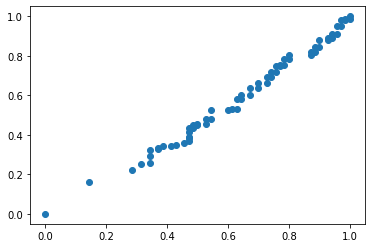

In [ ]:
plt.scatter(metric.roc_curve(road_truths, probabilities)[1],metric.roc_curve(road_truths, probabilities)[0])

In [ ]:
from matplotlib import pyplot
ns_probs = [0 for _ in range(len(road_truths))]
ns_fpr, ns_tpr, _ = metric.roc_curve(road_truths, ns_probs)
lr_fpr2, lr_tpr2, _ = metric.roc_curve(road_truths, probabilities)

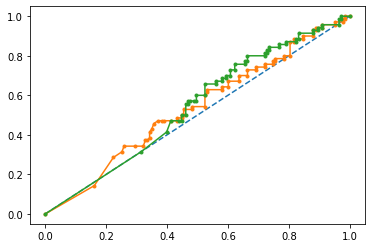

In [ ]:
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
pyplot.plot(lr_fpr2, lr_tpr2, marker='.', label='Logistic')

In [ ]:
ROC = pd.DataFrame({'FPR':lr_fpr2,
                        'TPR':lr_tpr2})

In [ ]:
ROC.to_csv("/content/drive/MyDrive/Owen/final_results/baseline_pretrained_ROC.csv")

# ResNet Pretrained With Mask



In [33]:
labelled_data = pd.read_csv("/content/train_set/train.csv")

In [34]:
labelled_data = labelled_data.drop("Unnamed: 0", axis="columns")
labelled_data = labelled_data.rename(columns={'Unnamed: 0.1':'image_name'})

In [35]:
gss = GroupShuffleSplit(n_splits=2, train_size=0.8/0.9, random_state=42)
gss.get_n_splits()
groups = np.array(labelled_data["road_id"])

In [36]:
train,test = next(gss.split(X = labelled_data, groups = groups))

In [37]:
labelled_data['image_path'] = "/content/train_set/" + labelled_data['image_name'].astype("str") + ".jpeg"

In [38]:
labelled_data['segmented_image_path'] = "/content/drive/MyDrive/Owen/segmented_images_multiplied/" + round(((labelled_data['image_name']+2500)/5000)).astype("int").astype("str") + "/" + labelled_data['image_name'].astype("str") + ".jpeg"

In [39]:
xtrain = labelled_data.iloc[train].segmented_image_path.values
xtest = labelled_data.iloc[test].segmented_image_path.values
ytrain = labelled_data.iloc[train].cracking_binary.values
ytest = labelled_data.iloc[test].cracking_binary.values

In [40]:
# image dataset module
class pano_images(Dataset):
    def __init__(self, path, labels, tfms=None):
        self.X = path
        self.y = labels
        # apply augmentations
        if tfms == 0: # if validating
            self.aug = albumentations.Compose([
                albumentations.Crop(x_min=0, y_min=500, x_max=2000, y_max=817, always_apply=True),
                albumentations.Resize(224, 224, always_apply=True),
                albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225], always_apply=True)
            ])
        else: # if training
            self.aug = albumentations.Compose([
                albumentations.Crop(x_min=0, y_min=500, x_max=2000, y_max=817, always_apply=True),
                albumentations.Resize(224, 224, always_apply=True),
                albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225], always_apply=True)
            ])
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        image = Image.open(self.X[i])
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        label = self.y[i]
        return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)

In [41]:
train_data = pano_images(xtrain, ytrain, tfms=1)
test_data = pano_images(xtest, ytest, tfms=0)

trainloader = DataLoader(train_data, batch_size=200, shuffle=True)
testloader = DataLoader(test_data, batch_size=200, shuffle=False)

(<matplotlib.axes._subplots.AxesSubplot at 0x7fdf71b3f650>,
 <matplotlib.image.AxesImage at 0x7fdf61129e10>)

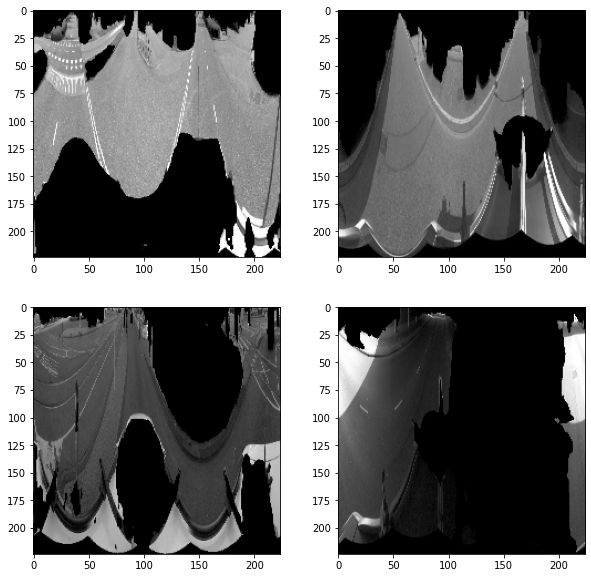

In [42]:
# visualizing images
i = 50
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(train_data[i][0][1], cmap='gray')
plt.subplot(222), plt.imshow(train_data[i+25][0][1], cmap='gray')
plt.subplot(223), plt.imshow(train_data[i+50][0][1], cmap='gray')
plt.subplot(224), plt.imshow(train_data[i+75][0][1], cmap='gray')

In [43]:
class final_layers(nn.Module):
    def __init__(self):
        super(final_layers, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layers(x)
        return x.squeeze()

In [45]:
# defining the model
model = models.resnet34(pretrained=True)
#set_parameter_requires_grad(model,0)
model.fc = final_layers()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.0003)
# defining the loss function
criterion = BCELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [46]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Owen/resnet_mask_multiplied_output_international/epoch0",map_location=torch.device('cpu')))

<All keys matched successfully>

In [48]:
def set_parameter_requires_grad(model, layers_untrained):
  layers_untrained = min(layers_untrained,61)
  for i,param in enumerate(model.parameters()):
    if i<layers_untrained:
      param.requires_grad = False

In [49]:
set_parameter_requires_grad(model, 20)

In [70]:
''' SEED Everything '''
def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True 
SEED=42
seed_everything(SEED=SEED)
''' SEED Everything '''
# set computation device
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")

Computation device: cuda:0


In [51]:
#validation function
def validate(model, test_dataloader):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_dataloader), total=int(len(test_data)/test_dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs.float(), target.float())
            val_running_loss += loss.item()
            preds = torch.round(outputs.data)
            val_running_correct += (preds == target).sum().item()
            true_positives += ((preds == 1)&(target == 1)).sum().item()
            true_negatives += ((preds == 0)&(target == 0)).sum().item()
            false_positives += ((preds == 1)&(target == 0)).sum().item()
            false_negatives += ((preds == 0)&(target == 1)).sum().item()
        
        if true_positives+false_positives>0:
          precision = true_positives/(true_positives+false_positives)
        else:
          precision = 0
        recall = true_positives/(true_positives+false_negatives)
        if ((precision>0)&(recall>0)):
          f1 = 2 * (precision*recall)/(precision+recall)
        else:
          f1 = 0
        val_loss = val_running_loss/max(int(len(test_data)/test_dataloader.batch_size),1)
        val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
        print(f"Recall: {recall:.4f}, Precision: {precision:.2f}, F1: {f1:.2f}")
        
        return val_loss, val_accuracy, f1

In [52]:
# training function
def fit(model, train_dataloader):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    for i, data in tqdm(enumerate(train_dataloader), total=int(len(train_data)/train_dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs.float(), target.float())
        train_running_loss += loss.item()
        preds = torch.round(outputs.data)
        train_running_correct += (preds == target).sum().item()
        true_positives += ((preds == 1)&(target == 1)).sum().item()
        true_negatives += ((preds == 0)&(target == 0)).sum().item()
        false_positives += ((preds == 1)&(target == 0)).sum().item()
        false_negatives += ((preds == 0)&(target == 1)).sum().item()
        loss.backward()
        optimizer.step()
    
    if true_positives+false_positives>0:
      precision = true_positives/(true_positives+false_positives)
    else:
      precision = 0
    recall = true_positives/(true_positives+false_negatives)
    if ((precision>0)&(recall>0)):
      f1 = 2 * (precision*recall)/(precision+recall)
    else:
      f1 = 0
    train_loss = train_running_loss/int(len(train_data)/train_dataloader.batch_size)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
    print(f"Recall: {recall:.4f}, Precision: {precision:.2f}, F1: {f1:.2f}")
    
    return train_loss, train_accuracy, f1

In [ ]:
train_loss , train_accuracy , train_f1 = [], [], []
val_loss , val_accuracy, val_f1 = [], [], []
start = time.time()
epochs = 75
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy, train_epoch_f1 = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy, val_epoch_f1 = validate(model, testloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    train_f1.append(train_epoch_f1)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    val_f1.append(val_epoch_f1)
    path = "/content/drive/MyDrive/Owen/pretrained_resnet_mask_output/epoch" + str(epoch)
    torch.save(model.state_dict(), path)
end = time.time()
print(f"{(end-start)/60:.3f} minutes")



  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 1 of 75
Training




  1%|          | 1/146 [00:05<13:57,  5.78s/it]

  1%|▏         | 2/146 [00:11<13:55,  5.80s/it]

  2%|▏         | 3/146 [00:17<13:54,  5.84s/it]

  3%|▎         | 4/146 [00:23<13:48,  5.84s/it]

  3%|▎         | 5/146 [00:29<13:41,  5.83s/it]

  4%|▍         | 6/146 [00:35<13:34,  5.82s/it]

  5%|▍         | 7/146 [00:41<13:40,  5.90s/it]

  5%|▌         | 8/146 [00:47<13:45,  5.98s/it]

  6%|▌         | 9/146 [00:53<13:49,  6.06s/it]

  7%|▋         | 10/146 [00:59<13:48,  6.09s/it]

  8%|▊         | 11/146 [01:05<13:38,  6.07s/it]

  8%|▊         | 12/146 [01:11<13:30,  6.05s/it]

  9%|▉         | 13/146 [01:17<13:22,  6.03s/it]

 10%|▉         | 14/146 [01:23<13:12,  6.01s/it]

 10%|█         | 15/146 [01:29<13:02,  5.97s/it]

 11%|█         | 16/146 [01:35<12:47,  5.91s/it]

 12%|█▏        | 17/146 [01:41<12:40,  5.90s/it]

 12%|█▏        | 18/146 [01:47<12:40,  5.94s/it]

 13%|█▎        | 19/146 [01:53<12:40,  5.99s/it]

 14%|█▎        | 20/146 [01:59<12:36,  6.01s/it]

 14%|█▍

Train Loss: 0.1559, Train Acc: 92.36
Recall: 0.7851, Precision: 0.99, F1: 0.88
Validating




1it [00:05,  5.97s/it]

2it [00:11,  5.89s/it]

3it [00:17,  5.79s/it]

4it [00:22,  5.72s/it]

5it [00:28,  5.65s/it]

6it [00:34,  5.72s/it]

7it [00:40,  5.81s/it]

8it [00:46,  5.86s/it]

9it [00:52,  5.92s/it]

10it [00:58,  6.04s/it]

11it [01:04,  6.11s/it]

12it [01:11,  6.18s/it]

13it [01:17,  6.19s/it]

14it [01:23,  6.13s/it]

15it [01:29,  6.08s/it]

16it [01:35,  6.03s/it]

17it [01:41,  6.01s/it]

18it [01:41,  5.65s/it]


Val Loss: 21.6784, Val Acc: 77.11
Recall: 0.5067, Precision: 0.67, F1: 0.58




  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 2 of 75
Training




  1%|          | 1/146 [00:05<14:12,  5.88s/it]

  1%|▏         | 2/146 [00:11<14:10,  5.91s/it]

  2%|▏         | 3/146 [00:17<14:06,  5.92s/it]

  3%|▎         | 4/146 [00:23<14:09,  5.98s/it]

  3%|▎         | 5/146 [00:30<14:08,  6.02s/it]

  4%|▍         | 6/146 [00:36<14:05,  6.04s/it]

  5%|▍         | 7/146 [00:42<13:53,  6.00s/it]

  5%|▌         | 8/146 [00:47<13:40,  5.95s/it]

  6%|▌         | 9/146 [00:53<13:32,  5.93s/it]

  7%|▋         | 10/146 [00:59<13:25,  5.92s/it]

  8%|▊         | 11/146 [01:05<13:13,  5.88s/it]

  8%|▊         | 12/146 [01:11<13:12,  5.91s/it]

  9%|▉         | 13/146 [01:17<13:09,  5.93s/it]

 10%|▉         | 14/146 [01:23<13:13,  6.01s/it]

 10%|█         | 15/146 [01:29<13:18,  6.09s/it]

 11%|█         | 16/146 [01:36<13:18,  6.15s/it]

 12%|█▏        | 17/146 [01:42<13:17,  6.18s/it]

 12%|█▏        | 18/146 [01:48<13:06,  6.15s/it]

 13%|█▎        | 19/146 [01:54<12:48,  6.05s/it]

 14%|█▎        | 20/146 [02:00<12:33,  5.98s/it]

 14%|█▍

Train Loss: 0.1613, Train Acc: 92.14
Recall: 0.7818, Precision: 0.99, F1: 0.87
Validating




1it [00:05,  5.56s/it]

2it [00:11,  5.56s/it]

3it [00:16,  5.58s/it]

4it [00:22,  5.61s/it]

5it [00:27,  5.59s/it]

6it [00:33,  5.69s/it]

7it [00:39,  5.81s/it]

8it [00:46,  5.92s/it]

9it [00:52,  5.99s/it]

10it [00:58,  6.04s/it]

11it [01:04,  6.07s/it]

12it [01:10,  6.04s/it]

13it [01:16,  6.00s/it]

14it [01:22,  5.95s/it]

15it [01:28,  5.91s/it]

16it [01:33,  5.88s/it]

17it [01:39,  5.87s/it]

18it [01:40,  5.57s/it]


Val Loss: 26.3680, Val Acc: 77.17
Recall: 0.3935, Precision: 0.74, F1: 0.51




  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 3 of 75
Training




  1%|          | 1/146 [00:05<13:53,  5.75s/it]

  1%|▏         | 2/146 [00:11<14:02,  5.85s/it]

  2%|▏         | 3/146 [00:17<14:08,  5.94s/it]

  3%|▎         | 4/146 [00:24<14:08,  5.97s/it]

  3%|▎         | 5/146 [00:30<14:05,  5.99s/it]

  4%|▍         | 6/146 [00:35<13:51,  5.94s/it]

  5%|▍         | 7/146 [00:41<13:37,  5.88s/it]

  5%|▌         | 8/146 [00:47<13:25,  5.84s/it]

  6%|▌         | 9/146 [00:53<13:17,  5.82s/it]

  7%|▋         | 10/146 [00:58<13:08,  5.80s/it]

  8%|▊         | 11/146 [01:04<12:57,  5.76s/it]

  8%|▊         | 12/146 [01:10<12:49,  5.74s/it]

  9%|▉         | 13/146 [01:16<12:46,  5.77s/it]

 10%|▉         | 14/146 [01:22<12:52,  5.85s/it]

 10%|█         | 15/146 [01:28<12:52,  5.90s/it]

 11%|█         | 16/146 [01:34<12:52,  5.94s/it]

 12%|█▏        | 17/146 [01:40<12:43,  5.92s/it]

 12%|█▏        | 18/146 [01:45<12:34,  5.89s/it]

 13%|█▎        | 19/146 [01:51<12:31,  5.92s/it]

 14%|█▎        | 20/146 [01:57<12:27,  5.93s/it]

 14%|█▍

Train Loss: 0.1619, Train Acc: 92.15
Recall: 0.7816, Precision: 0.99, F1: 0.87
Validating




1it [00:05,  5.38s/it]

2it [00:10,  5.38s/it]

3it [00:16,  5.38s/it]

4it [00:21,  5.36s/it]

5it [00:26,  5.33s/it]

6it [00:32,  5.44s/it]

7it [00:38,  5.58s/it]

8it [00:44,  5.75s/it]

9it [00:50,  5.91s/it]

10it [00:57,  6.06s/it]

11it [01:03,  6.13s/it]

12it [01:09,  6.11s/it]

13it [01:15,  6.12s/it]

14it [01:21,  6.10s/it]

15it [01:27,  6.02s/it]

16it [01:33,  5.95s/it]

17it [01:39,  5.90s/it]

18it [01:39,  5.54s/it]


Val Loss: 35.1989, Val Acc: 77.26
Recall: 0.4116, Precision: 0.73, F1: 0.53




  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 4 of 75
Training




  1%|          | 1/146 [00:05<14:17,  5.91s/it]

  1%|▏         | 2/146 [00:12<14:25,  6.01s/it]

  2%|▏         | 3/146 [00:18<14:21,  6.02s/it]

  3%|▎         | 4/146 [00:24<14:15,  6.03s/it]

  3%|▎         | 5/146 [00:30<14:01,  5.97s/it]

  4%|▍         | 6/146 [00:35<13:46,  5.91s/it]

  5%|▍         | 7/146 [00:41<13:34,  5.86s/it]

  5%|▌         | 8/146 [00:47<13:24,  5.83s/it]

  6%|▌         | 9/146 [00:53<13:14,  5.80s/it]

  7%|▋         | 10/146 [00:58<13:03,  5.76s/it]

  8%|▊         | 11/146 [01:04<12:55,  5.74s/it]

  8%|▊         | 12/146 [01:10<12:52,  5.77s/it]

  9%|▉         | 13/146 [01:16<13:01,  5.87s/it]

 10%|▉         | 14/146 [01:22<13:06,  5.96s/it]

 10%|█         | 15/146 [01:28<13:02,  5.98s/it]

 11%|█         | 16/146 [01:34<12:59,  6.00s/it]

 12%|█▏        | 17/146 [01:40<12:45,  5.94s/it]

 12%|█▏        | 18/146 [01:46<12:34,  5.89s/it]

 13%|█▎        | 19/146 [01:51<12:23,  5.85s/it]

 14%|█▎        | 20/146 [01:57<12:14,  5.83s/it]

 14%|█▍

Train Loss: 0.1664, Train Acc: 92.00
Recall: 0.7802, Precision: 0.99, F1: 0.87
Validating




1it [00:05,  5.83s/it]

2it [00:11,  5.78s/it]

3it [00:17,  5.75s/it]

4it [00:22,  5.68s/it]

5it [00:28,  5.58s/it]

6it [00:34,  5.73s/it]

7it [00:40,  5.88s/it]

8it [00:46,  5.94s/it]

9it [00:52,  5.97s/it]

10it [00:58,  5.95s/it]

11it [01:04,  5.92s/it]

12it [01:10,  5.92s/it]

13it [01:16,  5.93s/it]

14it [01:22,  5.95s/it]

15it [01:28,  5.98s/it]

16it [01:34,  6.02s/it]

17it [01:40,  6.13s/it]

18it [01:41,  5.62s/it]


Val Loss: 25.3001, Val Acc: 77.44
Recall: 0.4886, Precision: 0.69, F1: 0.57




  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 5 of 75
Training




  1%|          | 1/146 [00:06<15:20,  6.35s/it]

  1%|▏         | 2/146 [00:12<15:16,  6.37s/it]

  2%|▏         | 3/146 [00:18<15:01,  6.31s/it]

  3%|▎         | 4/146 [00:24<14:32,  6.14s/it]

  3%|▎         | 5/146 [00:30<14:12,  6.05s/it]

  4%|▍         | 6/146 [00:36<13:55,  5.96s/it]

  5%|▍         | 7/146 [00:42<13:44,  5.93s/it]

  5%|▌         | 8/146 [00:47<13:32,  5.88s/it]

  6%|▌         | 9/146 [00:53<13:20,  5.84s/it]

  7%|▋         | 10/146 [00:59<13:10,  5.81s/it]

  8%|▊         | 11/146 [01:05<13:14,  5.89s/it]

  8%|▊         | 12/146 [01:11<13:16,  5.94s/it]

  9%|▉         | 13/146 [01:17<13:15,  5.98s/it]

 10%|▉         | 14/146 [01:23<13:12,  6.01s/it]

 10%|█         | 15/146 [01:29<12:57,  5.94s/it]

 11%|█         | 16/146 [01:35<12:46,  5.89s/it]

 12%|█▏        | 17/146 [01:41<12:35,  5.86s/it]

 12%|█▏        | 18/146 [01:46<12:28,  5.84s/it]

 13%|█▎        | 19/146 [01:52<12:19,  5.82s/it]

 14%|█▎        | 20/146 [01:58<12:12,  5.81s/it]

 14%|█▍

Train Loss: 0.1504, Train Acc: 92.56
Recall: 0.7892, Precision: 1.00, F1: 0.88
Validating




1it [00:05,  5.81s/it]

2it [00:11,  5.73s/it]

3it [00:16,  5.64s/it]

4it [00:22,  5.59s/it]

5it [00:27,  5.60s/it]

6it [00:33,  5.72s/it]

7it [00:40,  5.87s/it]

8it [00:46,  5.93s/it]

9it [00:52,  5.98s/it]

10it [00:58,  6.03s/it]

11it [01:04,  6.07s/it]

12it [01:10,  6.06s/it]

13it [01:16,  6.08s/it]

14it [01:22,  6.01s/it]

15it [01:28,  5.97s/it]

16it [01:34,  5.97s/it]

17it [01:40,  6.01s/it]

18it [01:41,  5.61s/it]


Val Loss: 29.5943, Val Acc: 77.67
Recall: 0.4544, Precision: 0.72, F1: 0.56




  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 6 of 75
Training




  1%|          | 1/146 [00:06<14:59,  6.20s/it]

  1%|▏         | 2/146 [00:12<14:50,  6.18s/it]

  2%|▏         | 3/146 [00:18<14:24,  6.04s/it]

  3%|▎         | 4/146 [00:23<14:12,  6.00s/it]

  3%|▎         | 5/146 [00:29<13:57,  5.94s/it]

  4%|▍         | 6/146 [00:35<13:44,  5.89s/it]

  5%|▍         | 7/146 [00:41<13:31,  5.83s/it]

  5%|▌         | 8/146 [00:46<13:21,  5.81s/it]

  6%|▌         | 9/146 [00:52<13:19,  5.84s/it]

  7%|▋         | 10/146 [00:58<13:22,  5.90s/it]

  8%|▊         | 11/146 [01:05<13:24,  5.96s/it]

  8%|▊         | 12/146 [01:11<13:22,  5.99s/it]

  9%|▉         | 13/146 [01:16<13:12,  5.95s/it]

 10%|▉         | 14/146 [01:22<13:01,  5.92s/it]

 10%|█         | 15/146 [01:28<12:51,  5.89s/it]

 11%|█         | 16/146 [01:34<12:42,  5.87s/it]

 12%|█▏        | 17/146 [01:40<12:34,  5.85s/it]

 12%|█▏        | 18/146 [01:45<12:24,  5.81s/it]

 13%|█▎        | 19/146 [01:51<12:17,  5.80s/it]

 14%|█▎        | 20/146 [01:57<12:15,  5.83s/it]

 14%|█▍

Train Loss: 0.1471, Train Acc: 92.67
Recall: 0.7897, Precision: 1.00, F1: 0.88
Validating




1it [00:05,  5.46s/it]

2it [00:10,  5.43s/it]

3it [00:16,  5.41s/it]

4it [00:21,  5.41s/it]

5it [00:27,  5.41s/it]

6it [00:32,  5.51s/it]

7it [00:38,  5.59s/it]

8it [00:44,  5.74s/it]

9it [00:50,  5.86s/it]

10it [00:56,  5.96s/it]

11it [01:03,  6.02s/it]

12it [01:09,  5.99s/it]

13it [01:15,  6.02s/it]

14it [01:21,  6.06s/it]

15it [01:27,  6.09s/it]

16it [01:33,  6.10s/it]

17it [01:39,  6.10s/it]

18it [01:40,  5.57s/it]


Val Loss: 25.8712, Val Acc: 77.55
Recall: 0.4829, Precision: 0.69, F1: 0.57




  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 7 of 75
Training




  1%|          | 1/146 [00:06<14:38,  6.06s/it]

  1%|▏         | 2/146 [00:12<14:34,  6.07s/it]

  2%|▏         | 3/146 [00:18<14:26,  6.06s/it]

  3%|▎         | 4/146 [00:24<14:16,  6.03s/it]

  3%|▎         | 5/146 [00:30<14:08,  6.02s/it]

  4%|▍         | 6/146 [00:36<14:02,  6.02s/it]

  5%|▍         | 7/146 [00:42<14:00,  6.04s/it]

  5%|▌         | 8/146 [00:48<13:57,  6.07s/it]

  6%|▌         | 9/146 [00:54<13:50,  6.06s/it]

  7%|▋         | 10/146 [01:00<13:43,  6.05s/it]

  8%|▊         | 11/146 [01:06<13:28,  5.99s/it]

  8%|▊         | 12/146 [01:12<13:14,  5.93s/it]

  9%|▉         | 13/146 [01:17<13:03,  5.89s/it]

 10%|▉         | 14/146 [01:23<12:53,  5.86s/it]

 10%|█         | 15/146 [01:29<12:43,  5.83s/it]

 11%|█         | 16/146 [01:35<12:35,  5.81s/it]

 12%|█▏        | 17/146 [01:40<12:27,  5.79s/it]

 12%|█▏        | 18/146 [01:46<12:28,  5.84s/it]

 13%|█▎        | 19/146 [01:53<12:31,  5.92s/it]

 14%|█▎        | 20/146 [01:59<12:30,  5.95s/it]

 14%|█▍

Train Loss: 0.1470, Train Acc: 92.66
Recall: 0.7901, Precision: 1.00, F1: 0.88
Validating




1it [00:05,  5.48s/it]

2it [00:11,  5.49s/it]

3it [00:16,  5.59s/it]

4it [00:22,  5.64s/it]

5it [00:28,  5.68s/it]

6it [00:34,  5.81s/it]

7it [00:40,  5.87s/it]

8it [00:46,  5.91s/it]

9it [00:52,  6.02s/it]

10it [00:59,  6.12s/it]

11it [01:05,  6.21s/it]

12it [01:11,  6.21s/it]

13it [01:17,  6.19s/it]

14it [01:23,  6.15s/it]

15it [01:30,  6.17s/it]

16it [01:36,  6.13s/it]

17it [01:42,  6.07s/it]

18it [01:42,  5.70s/it]


Val Loss: 28.8005, Val Acc: 77.55
Recall: 0.4696, Precision: 0.70, F1: 0.56




  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 8 of 75
Training




  1%|          | 1/146 [00:05<14:04,  5.82s/it]

  1%|▏         | 2/146 [00:12<14:15,  5.94s/it]

  2%|▏         | 3/146 [00:18<14:14,  5.98s/it]

  3%|▎         | 4/146 [00:24<14:12,  6.00s/it]

  3%|▎         | 5/146 [00:30<14:10,  6.03s/it]

  4%|▍         | 6/146 [00:36<13:55,  5.97s/it]

  5%|▍         | 7/146 [00:41<13:40,  5.91s/it]

  5%|▌         | 8/146 [00:47<13:33,  5.89s/it]

  6%|▌         | 9/146 [00:53<13:24,  5.87s/it]

  7%|▋         | 10/146 [00:59<13:14,  5.84s/it]

  8%|▊         | 11/146 [01:05<13:07,  5.83s/it]

  8%|▊         | 12/146 [01:10<12:57,  5.80s/it]

  9%|▉         | 13/146 [01:16<13:02,  5.88s/it]

 10%|▉         | 14/146 [01:22<13:04,  5.94s/it]

 10%|█         | 15/146 [01:29<13:04,  5.99s/it]

 11%|█         | 16/146 [01:35<12:59,  6.00s/it]

 12%|█▏        | 17/146 [01:40<12:45,  5.93s/it]

 12%|█▏        | 18/146 [01:46<12:32,  5.88s/it]

 13%|█▎        | 19/146 [01:52<12:24,  5.86s/it]

 14%|█▎        | 20/146 [01:58<12:14,  5.83s/it]

 14%|█▍

Train Loss: 0.1468, Train Acc: 92.68
Recall: 0.7901, Precision: 1.00, F1: 0.88
Validating




1it [00:05,  5.88s/it]

2it [00:11,  5.82s/it]

3it [00:17,  5.73s/it]

4it [00:22,  5.74s/it]

5it [00:28,  5.75s/it]

6it [00:34,  5.88s/it]

7it [00:41,  5.99s/it]

8it [00:47,  6.00s/it]

9it [00:53,  5.99s/it]

10it [00:59,  6.02s/it]

11it [01:05,  6.01s/it]

12it [01:11,  6.03s/it]

13it [01:17,  6.02s/it]

14it [01:23,  6.07s/it]

15it [01:29,  6.17s/it]

16it [01:36,  6.26s/it]

17it [01:42,  6.34s/it]

18it [01:43,  5.74s/it]


Val Loss: 26.2508, Val Acc: 77.61
Recall: 0.4458, Precision: 0.72, F1: 0.55




  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 9 of 75
Training




  1%|          | 1/146 [00:06<15:17,  6.33s/it]

  1%|▏         | 2/146 [00:12<15:11,  6.33s/it]

  2%|▏         | 3/146 [00:18<15:03,  6.31s/it]

  3%|▎         | 4/146 [00:25<14:53,  6.29s/it]

  3%|▎         | 5/146 [00:31<14:49,  6.31s/it]

  4%|▍         | 6/146 [00:37<14:37,  6.27s/it]

  5%|▍         | 7/146 [00:43<14:30,  6.26s/it]

  5%|▌         | 8/146 [00:50<14:28,  6.29s/it]

  6%|▌         | 9/146 [00:56<14:26,  6.32s/it]

  7%|▋         | 10/146 [01:03<14:21,  6.34s/it]

  8%|▊         | 11/146 [01:09<14:15,  6.34s/it]

  8%|▊         | 12/146 [01:15<13:56,  6.24s/it]

  9%|▉         | 13/146 [01:21<13:38,  6.15s/it]

 10%|▉         | 14/146 [01:27<13:24,  6.10s/it]

 10%|█         | 15/146 [01:33<13:20,  6.11s/it]

 11%|█         | 16/146 [01:39<13:13,  6.10s/it]

 12%|█▏        | 17/146 [01:45<13:08,  6.11s/it]

 12%|█▏        | 18/146 [01:51<13:04,  6.13s/it]

 13%|█▎        | 19/146 [01:58<13:01,  6.15s/it]

 14%|█▎        | 20/146 [02:04<12:56,  6.16s/it]

 14%|█▍

Train Loss: 0.1468, Train Acc: 92.68
Recall: 0.7900, Precision: 1.00, F1: 0.88
Validating




1it [00:05,  5.90s/it]

2it [00:11,  5.86s/it]

3it [00:17,  5.85s/it]

4it [00:23,  5.84s/it]

5it [00:28,  5.77s/it]

6it [00:35,  5.90s/it]

7it [00:41,  6.03s/it]

8it [00:47,  6.10s/it]

9it [00:54,  6.15s/it]

10it [01:00,  6.15s/it]

11it [01:06,  6.10s/it]

12it [01:12,  6.07s/it]

13it [01:18,  6.14s/it]

14it [01:24,  6.15s/it]

15it [01:30,  6.20s/it]

16it [01:37,  6.22s/it]

17it [01:43,  6.30s/it]

18it [01:44,  5.79s/it]


Val Loss: 24.5982, Val Acc: 77.99
Recall: 0.4715, Precision: 0.72, F1: 0.57




  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 10 of 75
Training




  1%|          | 1/146 [00:06<15:35,  6.45s/it]

  1%|▏         | 2/146 [00:12<15:30,  6.46s/it]

  2%|▏         | 3/146 [00:19<15:12,  6.38s/it]

  3%|▎         | 4/146 [00:25<14:52,  6.29s/it]

  3%|▎         | 5/146 [00:31<14:38,  6.23s/it]

  4%|▍         | 6/146 [00:37<14:25,  6.18s/it]

  5%|▍         | 7/146 [00:43<14:16,  6.16s/it]

  5%|▌         | 8/146 [00:49<14:04,  6.12s/it]

  6%|▌         | 9/146 [00:55<13:54,  6.09s/it]

  7%|▋         | 10/146 [01:01<13:48,  6.09s/it]

  8%|▊         | 11/146 [01:07<13:46,  6.13s/it]

  8%|▊         | 12/146 [01:14<13:45,  6.16s/it]

  9%|▉         | 13/146 [01:20<13:42,  6.18s/it]

 10%|▉         | 14/146 [01:26<13:35,  6.18s/it]

 10%|█         | 15/146 [01:32<13:24,  6.14s/it]

 11%|█         | 16/146 [01:38<13:16,  6.12s/it]

 12%|█▏        | 17/146 [01:44<13:08,  6.11s/it]

 12%|█▏        | 18/146 [01:50<12:59,  6.09s/it]

 13%|█▎        | 19/146 [01:56<12:52,  6.08s/it]

 14%|█▎        | 20/146 [02:02<12:45,  6.07s/it]

 14%|█▍

Train Loss: 0.1627, Train Acc: 92.17
Recall: 0.7825, Precision: 0.99, F1: 0.87
Validating




1it [00:05,  5.84s/it]

2it [00:11,  5.79s/it]

3it [00:17,  5.73s/it]

4it [00:22,  5.71s/it]

5it [00:28,  5.70s/it]

6it [00:34,  5.82s/it]

7it [00:40,  5.94s/it]

8it [00:46,  6.00s/it]

9it [00:53,  6.08s/it]

10it [00:59,  6.19s/it]

11it [01:06,  6.26s/it]

12it [01:12,  6.31s/it]

13it [01:18,  6.33s/it]

14it [01:25,  6.33s/it]

15it [01:31,  6.34s/it]

16it [01:37,  6.36s/it]

17it [01:44,  6.35s/it]

18it [01:44,  5.82s/it]


Val Loss: 29.9422, Val Acc: 73.28
Recall: 0.4857, Precision: 0.58, F1: 0.53




  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 11 of 75
Training




  1%|          | 1/146 [00:06<15:13,  6.30s/it]

  1%|▏         | 2/146 [00:12<15:10,  6.33s/it]

  2%|▏         | 3/146 [00:19<15:07,  6.34s/it]

  3%|▎         | 4/146 [00:25<14:58,  6.33s/it]

  3%|▎         | 5/146 [00:31<14:50,  6.32s/it]

  4%|▍         | 6/146 [00:38<14:45,  6.33s/it]

  5%|▍         | 7/146 [00:44<14:29,  6.25s/it]

  5%|▌         | 8/146 [00:50<14:19,  6.23s/it]

  6%|▌         | 9/146 [00:56<14:08,  6.19s/it]

  7%|▋         | 10/146 [01:02<13:57,  6.15s/it]

  8%|▊         | 11/146 [01:08<13:49,  6.14s/it]

  8%|▊         | 12/146 [01:14<13:39,  6.11s/it]

  9%|▉         | 13/146 [01:20<13:37,  6.15s/it]

 10%|▉         | 14/146 [01:27<13:39,  6.21s/it]

 10%|█         | 15/146 [01:33<13:36,  6.23s/it]

 11%|█         | 16/146 [01:39<13:33,  6.26s/it]

 12%|█▏        | 17/146 [01:45<13:22,  6.22s/it]

 12%|█▏        | 18/146 [01:52<13:12,  6.19s/it]

 13%|█▎        | 19/146 [01:58<13:00,  6.15s/it]

 14%|█▎        | 20/146 [02:04<12:53,  6.14s/it]

 14%|█▍

Train Loss: 0.1695, Train Acc: 91.88
Recall: 0.7784, Precision: 0.98, F1: 0.87
Validating




1it [00:05,  5.96s/it]

2it [00:11,  5.92s/it]

3it [00:17,  5.92s/it]

4it [00:23,  5.90s/it]

5it [00:29,  5.84s/it]

6it [00:35,  5.90s/it]

7it [00:41,  5.96s/it]

8it [00:47,  6.01s/it]

9it [00:53,  6.04s/it]

10it [00:59,  6.07s/it]

11it [01:05,  6.08s/it]

12it [01:12,  6.14s/it]

13it [01:18,  6.27s/it]

14it [01:25,  6.33s/it]

15it [01:31,  6.37s/it]

16it [01:37,  6.35s/it]

17it [01:44,  6.34s/it]

18it [01:44,  5.82s/it]


Val Loss: 13.6336, Val Acc: 78.61
Recall: 0.4990, Precision: 0.72, F1: 0.59




  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 12 of 75
Training




  1%|          | 1/146 [00:06<15:01,  6.22s/it]

  1%|▏         | 2/146 [00:12<14:48,  6.17s/it]

  2%|▏         | 3/146 [00:18<14:31,  6.09s/it]

  3%|▎         | 4/146 [00:24<14:14,  6.02s/it]

  3%|▎         | 5/146 [00:30<14:06,  6.00s/it]

  4%|▍         | 6/146 [00:36<14:09,  6.07s/it]

  5%|▍         | 7/146 [00:42<14:08,  6.11s/it]

  5%|▌         | 8/146 [00:48<14:04,  6.12s/it]

  6%|▌         | 9/146 [00:54<13:57,  6.12s/it]

  7%|▋         | 10/146 [01:00<13:44,  6.06s/it]

  8%|▊         | 11/146 [01:06<13:34,  6.03s/it]

  8%|▊         | 12/146 [01:12<13:23,  5.99s/it]

  9%|▉         | 13/146 [01:18<13:13,  5.97s/it]

 10%|▉         | 14/146 [01:24<13:06,  5.96s/it]

 10%|█         | 15/146 [01:30<12:59,  5.95s/it]

 11%|█         | 16/146 [01:36<12:54,  5.96s/it]

 12%|█▏        | 17/146 [01:42<12:59,  6.04s/it]

 12%|█▏        | 18/146 [01:48<12:59,  6.09s/it]

 13%|█▎        | 19/146 [01:54<12:56,  6.11s/it]

 14%|█▎        | 20/146 [02:00<12:48,  6.10s/it]

 14%|█▍

Train Loss: 0.1590, Train Acc: 92.25
Recall: 0.7834, Precision: 0.99, F1: 0.88
Validating




1it [00:05,  5.53s/it]

2it [00:10,  5.48s/it]

3it [00:16,  5.46s/it]

4it [00:21,  5.45s/it]

5it [00:27,  5.44s/it]

6it [00:32,  5.53s/it]

7it [00:38,  5.67s/it]

8it [00:45,  5.82s/it]

9it [00:51,  5.92s/it]

10it [00:57,  6.00s/it]

11it [01:03,  6.01s/it]

12it [01:09,  5.98s/it]

13it [01:15,  5.96s/it]

14it [01:21,  5.96s/it]

15it [01:27,  5.93s/it]

16it [01:33,  5.98s/it]

17it [01:39,  6.01s/it]

18it [01:39,  5.54s/it]


Val Loss: 29.5182, Val Acc: 78.05
Recall: 0.3831, Precision: 0.80, F1: 0.52




  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 13 of 75
Training




  1%|          | 1/146 [00:06<15:01,  6.22s/it]

  1%|▏         | 2/146 [00:12<15:04,  6.28s/it]

  2%|▏         | 3/146 [00:19<15:01,  6.31s/it]

  3%|▎         | 4/146 [00:25<14:56,  6.31s/it]

  3%|▎         | 5/146 [00:31<14:36,  6.21s/it]

  4%|▍         | 6/146 [00:37<14:13,  6.09s/it]

  5%|▍         | 7/146 [00:42<13:56,  6.02s/it]

  5%|▌         | 8/146 [00:48<13:44,  5.97s/it]

  6%|▌         | 9/146 [00:54<13:31,  5.92s/it]

  7%|▋         | 10/146 [01:00<13:18,  5.87s/it]

  8%|▊         | 11/146 [01:06<13:07,  5.84s/it]

  8%|▊         | 12/146 [01:12<13:07,  5.88s/it]

  9%|▉         | 13/146 [01:18<13:10,  5.94s/it]

 10%|▉         | 14/146 [01:24<13:12,  6.01s/it]

 10%|█         | 15/146 [01:30<13:12,  6.05s/it]

 11%|█         | 16/146 [01:36<13:05,  6.04s/it]

 12%|█▏        | 17/146 [01:42<12:56,  6.02s/it]

 12%|█▏        | 18/146 [01:48<12:57,  6.07s/it]

 13%|█▎        | 19/146 [01:54<12:55,  6.10s/it]

 14%|█▎        | 20/146 [02:01<12:55,  6.16s/it]

 14%|█▍

Train Loss: 0.1493, Train Acc: 92.60
Recall: 0.7893, Precision: 1.00, F1: 0.88
Validating




1it [00:06,  6.04s/it]

2it [00:11,  6.01s/it]

3it [00:17,  5.96s/it]

4it [00:23,  5.89s/it]

5it [00:29,  5.84s/it]

6it [00:35,  5.94s/it]

7it [00:41,  6.00s/it]

8it [00:47,  6.02s/it]

9it [00:53,  5.99s/it]

10it [00:59,  6.03s/it]

11it [01:06,  6.16s/it]

12it [01:12,  6.26s/it]

13it [01:19,  6.32s/it]

14it [01:25,  6.30s/it]

15it [01:31,  6.27s/it]

16it [01:37,  6.24s/it]

17it [01:43,  6.23s/it]

18it [01:44,  5.81s/it]


Val Loss: 20.6217, Val Acc: 78.55
Recall: 0.4525, Precision: 0.75, F1: 0.56




  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 14 of 75
Training




  1%|          | 1/146 [00:06<14:40,  6.07s/it]

  1%|▏         | 2/146 [00:12<14:42,  6.13s/it]

  2%|▏         | 3/146 [00:18<14:38,  6.14s/it]

  3%|▎         | 4/146 [00:24<14:43,  6.22s/it]

  3%|▎         | 5/146 [00:31<14:43,  6.27s/it]

  4%|▍         | 6/146 [00:37<14:40,  6.29s/it]

  5%|▍         | 7/146 [00:43<14:33,  6.29s/it]

  5%|▌         | 8/146 [00:50<14:23,  6.25s/it]

  6%|▌         | 9/146 [00:56<14:14,  6.24s/it]

  7%|▋         | 10/146 [01:02<14:03,  6.20s/it]

  8%|▊         | 11/146 [01:08<13:54,  6.18s/it]

  8%|▊         | 12/146 [01:14<13:48,  6.19s/it]

  9%|▉         | 13/146 [01:20<13:39,  6.16s/it]

 10%|▉         | 14/146 [01:26<13:27,  6.12s/it]

 10%|█         | 15/146 [01:32<13:20,  6.11s/it]

 11%|█         | 16/146 [01:39<13:15,  6.12s/it]

 12%|█▏        | 17/146 [01:45<13:16,  6.18s/it]

 12%|█▏        | 18/146 [01:51<13:12,  6.19s/it]

 13%|█▎        | 19/146 [01:57<13:05,  6.18s/it]

 14%|█▎        | 20/146 [02:04<13:09,  6.27s/it]

 14%|█▍

Train Loss: 0.1469, Train Acc: 92.67
Recall: 0.7899, Precision: 1.00, F1: 0.88
Validating




1it [00:05,  5.77s/it]

2it [00:11,  5.80s/it]

3it [00:17,  5.82s/it]

4it [00:23,  5.83s/it]

5it [00:29,  5.83s/it]

6it [00:35,  5.88s/it]

7it [00:41,  5.90s/it]

8it [00:47,  5.90s/it]

9it [00:53,  5.93s/it]

10it [00:59,  5.99s/it]

11it [01:05,  6.01s/it]

12it [01:11,  6.07s/it]

13it [01:17,  6.17s/it]

14it [01:24,  6.23s/it]

15it [01:30,  6.28s/it]

16it [01:36,  6.30s/it]

17it [01:43,  6.29s/it]

18it [01:43,  5.76s/it]


Val Loss: 22.2609, Val Acc: 78.37
Recall: 0.4772, Precision: 0.73, F1: 0.58




  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 15 of 75
Training




  1%|          | 1/146 [00:06<14:43,  6.09s/it]

  1%|▏         | 2/146 [00:12<14:51,  6.19s/it]

  2%|▏         | 3/146 [00:18<14:40,  6.15s/it]

  3%|▎         | 4/146 [00:24<14:28,  6.12s/it]

  3%|▎         | 5/146 [00:30<14:17,  6.08s/it]

  4%|▍         | 6/146 [00:36<14:16,  6.12s/it]

  5%|▍         | 7/146 [00:43<14:20,  6.19s/it]

  5%|▌         | 8/146 [00:49<14:20,  6.24s/it]

  6%|▌         | 9/146 [00:55<14:18,  6.27s/it]

  7%|▋         | 10/146 [01:02<14:11,  6.26s/it]

  8%|▊         | 11/146 [01:08<13:54,  6.18s/it]

  8%|▊         | 12/146 [01:14<13:39,  6.12s/it]

  9%|▉         | 13/146 [01:19<13:21,  6.03s/it]

 10%|▉         | 14/146 [01:25<13:08,  5.97s/it]

 10%|█         | 15/146 [01:31<13:00,  5.96s/it]

 11%|█         | 16/146 [01:37<12:58,  5.99s/it]

 12%|█▏        | 17/146 [01:43<13:01,  6.06s/it]

 12%|█▏        | 18/146 [01:50<13:06,  6.14s/it]

 13%|█▎        | 19/146 [01:56<13:07,  6.20s/it]

 14%|█▎        | 20/146 [02:02<13:04,  6.22s/it]

 14%|█▍

Train Loss: 0.1466, Train Acc: 92.67
Recall: 0.7909, Precision: 1.00, F1: 0.88
Validating




1it [00:05,  5.51s/it]

2it [00:10,  5.47s/it]

3it [00:16,  5.44s/it]

4it [00:21,  5.36s/it]

5it [00:26,  5.28s/it]

6it [00:31,  5.33s/it]

7it [00:37,  5.40s/it]

8it [00:43,  5.44s/it]

9it [00:48,  5.48s/it]

10it [00:54,  5.50s/it]

11it [00:59,  5.53s/it]

12it [01:05,  5.65s/it]

13it [01:11,  5.76s/it]

14it [01:17,  5.79s/it]

15it [01:23,  5.81s/it]

16it [01:29,  5.74s/it]

17it [01:34,  5.70s/it]

18it [01:35,  5.29s/it]


Val Loss: 20.8658, Val Acc: 79.16
Recall: 0.4705, Precision: 0.76, F1: 0.58




  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 16 of 75
Training




  1%|          | 1/146 [00:05<13:24,  5.55s/it]

  1%|▏         | 2/146 [00:11<13:26,  5.60s/it]

  2%|▏         | 3/146 [00:16<13:16,  5.57s/it]

  3%|▎         | 4/146 [00:22<13:10,  5.56s/it]

  3%|▎         | 5/146 [00:27<13:00,  5.53s/it]

  4%|▍         | 6/146 [00:33<12:58,  5.56s/it]

  5%|▍         | 7/146 [00:39<13:04,  5.64s/it]

  5%|▌         | 8/146 [00:45<13:05,  5.69s/it]

  6%|▌         | 9/146 [00:50<13:04,  5.73s/it]

  7%|▋         | 10/146 [00:56<12:58,  5.72s/it]

  8%|▊         | 11/146 [01:02<12:45,  5.67s/it]

  8%|▊         | 12/146 [01:07<12:32,  5.62s/it]

  9%|▉         | 13/146 [01:13<12:23,  5.59s/it]

 10%|▉         | 14/146 [01:18<12:13,  5.56s/it]

 10%|█         | 15/146 [01:24<12:06,  5.55s/it]

 11%|█         | 16/146 [01:29<12:03,  5.57s/it]

 12%|█▏        | 17/146 [01:35<12:02,  5.60s/it]

 12%|█▏        | 18/146 [01:41<12:13,  5.73s/it]

 13%|█▎        | 19/146 [01:47<12:16,  5.80s/it]

 14%|█▎        | 20/146 [01:53<12:15,  5.84s/it]

 14%|█▍

Train Loss: 0.1600, Train Acc: 92.25
Recall: 0.7834, Precision: 0.99, F1: 0.88
Validating




1it [00:05,  5.84s/it]

2it [00:11,  5.82s/it]

3it [00:17,  5.81s/it]

4it [00:23,  5.81s/it]

5it [00:28,  5.73s/it]

6it [00:34,  5.79s/it]

7it [00:40,  5.85s/it]

8it [00:46,  5.83s/it]

9it [00:52,  5.80s/it]

10it [00:57,  5.79s/it]

11it [01:03,  5.78s/it]

12it [01:09,  5.84s/it]

13it [01:15,  5.92s/it]

14it [01:21,  5.97s/it]

15it [01:27,  6.00s/it]

16it [01:33,  5.98s/it]

17it [01:39,  5.96s/it]

18it [01:40,  5.57s/it]


Val Loss: 15.1779, Val Acc: 77.70
Recall: 0.4990, Precision: 0.69, F1: 0.58




  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 17 of 75
Training




  1%|          | 1/146 [00:05<13:48,  5.71s/it]

  1%|▏         | 2/146 [00:11<13:50,  5.77s/it]

  2%|▏         | 3/146 [00:17<13:42,  5.75s/it]

  3%|▎         | 4/146 [00:23<13:34,  5.74s/it]

  3%|▎         | 5/146 [00:28<13:31,  5.75s/it]

  4%|▍         | 6/146 [00:34<13:31,  5.79s/it]

  5%|▍         | 7/146 [00:40<13:36,  5.88s/it]

  5%|▌         | 8/146 [00:46<13:34,  5.91s/it]

  6%|▌         | 9/146 [00:52<13:32,  5.93s/it]

  7%|▋         | 10/146 [00:58<13:24,  5.92s/it]

  8%|▊         | 11/146 [01:04<13:09,  5.85s/it]

  8%|▊         | 12/146 [01:10<12:59,  5.82s/it]

  9%|▉         | 13/146 [01:15<12:51,  5.80s/it]

 10%|▉         | 14/146 [01:21<12:41,  5.77s/it]

 10%|█         | 15/146 [01:27<12:30,  5.73s/it]

 11%|█         | 16/146 [01:32<12:22,  5.71s/it]

 12%|█▏        | 17/146 [01:38<12:15,  5.70s/it]

 12%|█▏        | 18/146 [01:44<12:27,  5.84s/it]

 13%|█▎        | 19/146 [01:50<12:34,  5.94s/it]

 14%|█▎        | 20/146 [01:57<12:38,  6.02s/it]

 14%|█▍

Train Loss: 0.1581, Train Acc: 92.29
Recall: 0.7840, Precision: 0.99, F1: 0.88
Validating




1it [00:05,  5.71s/it]

2it [00:11,  5.67s/it]

3it [00:16,  5.65s/it]

4it [00:22,  5.61s/it]

5it [00:27,  5.52s/it]

6it [00:33,  5.59s/it]

7it [00:39,  5.65s/it]

8it [00:45,  5.72s/it]

9it [00:51,  5.78s/it]

10it [00:57,  5.86s/it]

11it [01:03,  5.90s/it]

12it [01:09,  6.03s/it]

13it [01:15,  6.13s/it]

14it [01:21,  6.15s/it]

15it [01:28,  6.13s/it]

16it [01:33,  6.05s/it]

17it [01:39,  5.96s/it]

18it [01:40,  5.57s/it]


Val Loss: 21.5178, Val Acc: 76.38
Recall: 0.5228, Precision: 0.64, F1: 0.58




  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 18 of 75
Training




  1%|          | 1/146 [00:05<13:45,  5.70s/it]

  1%|▏         | 2/146 [00:11<13:45,  5.73s/it]

  2%|▏         | 3/146 [00:17<13:37,  5.72s/it]

  3%|▎         | 4/146 [00:22<13:26,  5.68s/it]

  3%|▎         | 5/146 [00:28<13:20,  5.67s/it]

  4%|▍         | 6/146 [00:34<13:23,  5.74s/it]

  5%|▍         | 7/146 [00:40<13:25,  5.80s/it]

  5%|▌         | 8/146 [00:46<13:25,  5.84s/it]

  6%|▌         | 9/146 [00:52<13:24,  5.87s/it]

  7%|▋         | 10/146 [00:57<13:10,  5.81s/it]

  8%|▊         | 11/146 [01:03<12:54,  5.74s/it]

  8%|▊         | 12/146 [01:09<12:44,  5.70s/it]

  9%|▉         | 13/146 [01:14<12:37,  5.70s/it]

 10%|▉         | 14/146 [01:20<12:28,  5.67s/it]

 10%|█         | 15/146 [01:25<12:20,  5.66s/it]

 11%|█         | 16/146 [01:31<12:14,  5.65s/it]

 12%|█▏        | 17/146 [01:37<12:09,  5.66s/it]

 12%|█▏        | 18/146 [01:43<12:16,  5.75s/it]

 13%|█▎        | 19/146 [01:49<12:17,  5.80s/it]

 14%|█▎        | 20/146 [01:55<12:17,  5.86s/it]

 14%|█▍

Train Loss: 0.1538, Train Acc: 92.42
Recall: 0.7866, Precision: 0.99, F1: 0.88
Validating




1it [00:05,  5.42s/it]

2it [00:10,  5.45s/it]

3it [00:16,  5.47s/it]

4it [00:21,  5.48s/it]

5it [00:27,  5.48s/it]

6it [00:33,  5.55s/it]

7it [00:38,  5.59s/it]

8it [00:44,  5.65s/it]

9it [00:50,  5.71s/it]

10it [00:56,  5.73s/it]

11it [01:02,  5.73s/it]

12it [01:07,  5.74s/it]

13it [01:13,  5.84s/it]

14it [01:19,  5.92s/it]

15it [01:26,  5.97s/it]

16it [01:32,  6.04s/it]

17it [01:38,  6.05s/it]

18it [01:38,  5.49s/it]


Val Loss: 18.1313, Val Acc: 79.31
Recall: 0.4306, Precision: 0.81, F1: 0.56




  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 19 of 75
Training




  1%|          | 1/146 [00:05<14:23,  5.96s/it]

  1%|▏         | 2/146 [00:12<14:29,  6.04s/it]

  2%|▏         | 3/146 [00:18<14:21,  6.02s/it]

  3%|▎         | 4/146 [00:24<14:12,  6.00s/it]

  3%|▎         | 5/146 [00:30<14:02,  5.97s/it]

  4%|▍         | 6/146 [00:35<13:45,  5.90s/it]

  5%|▍         | 7/146 [00:41<13:39,  5.89s/it]

  5%|▌         | 8/146 [00:47<13:38,  5.93s/it]

  6%|▌         | 9/146 [00:53<13:35,  5.95s/it]

  7%|▋         | 10/146 [00:59<13:29,  5.96s/it]

  8%|▊         | 11/146 [01:05<13:20,  5.93s/it]

  8%|▊         | 12/146 [01:11<13:04,  5.85s/it]

  9%|▉         | 13/146 [01:16<12:52,  5.81s/it]

 10%|▉         | 14/146 [01:22<12:43,  5.78s/it]

 10%|█         | 15/146 [01:28<12:32,  5.74s/it]

 11%|█         | 16/146 [01:33<12:22,  5.71s/it]

 12%|█▏        | 17/146 [01:39<12:11,  5.67s/it]

 12%|█▏        | 18/146 [01:45<12:08,  5.69s/it]

 13%|█▎        | 19/146 [01:51<12:10,  5.75s/it]

 14%|█▎        | 20/146 [01:57<12:13,  5.82s/it]

 14%|█▍

Train Loss: 0.1516, Train Acc: 92.49
Recall: 0.7872, Precision: 1.00, F1: 0.88
Validating




1it [00:05,  5.63s/it]

2it [00:11,  5.60s/it]

3it [00:17,  5.68s/it]

4it [00:22,  5.73s/it]

5it [00:28,  5.75s/it]

6it [00:34,  5.90s/it]

7it [00:40,  5.88s/it]

8it [00:46,  5.84s/it]

9it [00:52,  5.79s/it]

10it [00:57,  5.79s/it]

11it [01:03,  5.76s/it]

12it [01:09,  5.76s/it]

13it [01:15,  5.76s/it]

14it [01:21,  5.82s/it]

15it [01:27,  5.89s/it]

16it [01:33,  5.93s/it]

17it [01:39,  5.96s/it]

18it [01:39,  5.54s/it]


Val Loss: 23.5165, Val Acc: 79.10
Recall: 0.4677, Precision: 0.76, F1: 0.58




  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 20 of 75
Training




  1%|          | 1/146 [00:05<13:37,  5.64s/it]

  1%|▏         | 2/146 [00:11<13:36,  5.67s/it]

  2%|▏         | 3/146 [00:17<13:29,  5.66s/it]

  3%|▎         | 4/146 [00:22<13:22,  5.65s/it]

  3%|▎         | 5/146 [00:28<13:17,  5.66s/it]

  4%|▍         | 6/146 [00:33<13:07,  5.62s/it]

  5%|▍         | 7/146 [00:39<13:12,  5.70s/it]

  5%|▌         | 8/146 [00:45<13:20,  5.80s/it]

  6%|▌         | 9/146 [00:51<13:31,  5.92s/it]

  7%|▋         | 10/146 [00:58<13:33,  5.98s/it]

  8%|▊         | 11/146 [01:04<13:35,  6.04s/it]

  8%|▊         | 12/146 [01:10<13:26,  6.02s/it]

  9%|▉         | 13/146 [01:16<13:15,  5.98s/it]

 10%|▉         | 14/146 [01:21<12:54,  5.87s/it]

 10%|█         | 15/146 [01:27<12:40,  5.81s/it]

 11%|█         | 16/146 [01:33<12:27,  5.75s/it]

 12%|█▏        | 17/146 [01:38<12:19,  5.73s/it]

 12%|█▏        | 18/146 [01:44<12:11,  5.71s/it]

 13%|█▎        | 19/146 [01:50<12:09,  5.74s/it]

 14%|█▎        | 20/146 [01:56<12:16,  5.85s/it]

 14%|█▍

Train Loss: 0.1517, Train Acc: 92.50
Recall: 0.7875, Precision: 1.00, F1: 0.88
Validating




1it [00:05,  5.55s/it]

2it [00:10,  5.51s/it]

3it [00:16,  5.50s/it]

4it [00:21,  5.43s/it]

5it [00:26,  5.35s/it]

6it [00:32,  5.43s/it]

7it [00:38,  5.52s/it]

8it [00:44,  5.62s/it]

9it [00:50,  5.74s/it]

10it [00:56,  5.85s/it]

11it [01:02,  5.92s/it]

12it [01:08,  5.94s/it]

13it [01:14,  5.90s/it]

14it [01:20,  5.95s/it]

15it [01:26,  5.97s/it]

16it [01:32,  5.98s/it]

17it [01:38,  6.01s/it]

18it [01:38,  5.49s/it]


Val Loss: 28.1281, Val Acc: 76.15
Recall: 0.5295, Precision: 0.64, F1: 0.58




  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 21 of 75
Training




  1%|          | 1/146 [00:05<13:43,  5.68s/it]

  1%|▏         | 2/146 [00:11<13:40,  5.70s/it]

  2%|▏         | 3/146 [00:17<13:32,  5.68s/it]

  3%|▎         | 4/146 [00:22<13:22,  5.65s/it]

  3%|▎         | 5/146 [00:28<13:12,  5.62s/it]

  4%|▍         | 6/146 [00:33<13:02,  5.59s/it]

  5%|▍         | 7/146 [00:39<12:57,  5.60s/it]

  5%|▌         | 8/146 [00:45<13:00,  5.65s/it]

  6%|▌         | 9/146 [00:51<13:06,  5.74s/it]

  7%|▋         | 10/146 [00:57<13:15,  5.85s/it]

  8%|▊         | 11/146 [01:03<13:20,  5.93s/it]

  8%|▊         | 12/146 [01:09<13:12,  5.91s/it]

  9%|▉         | 13/146 [01:15<13:06,  5.91s/it]

 10%|▉         | 14/146 [01:21<13:07,  5.97s/it]

 10%|█         | 15/146 [01:27<13:03,  5.98s/it]

 11%|█         | 16/146 [01:32<12:51,  5.94s/it]

 12%|█▏        | 17/146 [01:38<12:43,  5.92s/it]

 12%|█▏        | 18/146 [01:44<12:35,  5.90s/it]

 13%|█▎        | 19/146 [01:50<12:40,  5.99s/it]

 14%|█▎        | 20/146 [01:57<12:44,  6.07s/it]

 14%|█▍

Train Loss: 0.1512, Train Acc: 92.52
Recall: 0.7878, Precision: 1.00, F1: 0.88
Validating




1it [00:05,  5.46s/it]

2it [00:10,  5.41s/it]

3it [00:15,  5.32s/it]

4it [00:20,  5.27s/it]

5it [00:26,  5.32s/it]

6it [00:32,  5.48s/it]

7it [00:38,  5.62s/it]

8it [00:44,  5.74s/it]

9it [00:50,  5.92s/it]

10it [00:57,  6.08s/it]

11it [01:03,  6.19s/it]

12it [01:09,  6.20s/it]

13it [01:15,  6.22s/it]

14it [01:22,  6.17s/it]

15it [01:28,  6.23s/it]

16it [01:34,  6.27s/it]

17it [01:41,  6.27s/it]

18it [01:41,  5.64s/it]


Val Loss: 29.0002, Val Acc: 72.93
Recall: 0.5542, Precision: 0.56, F1: 0.56




  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 22 of 75
Training




  1%|          | 1/146 [00:06<14:45,  6.11s/it]

  1%|▏         | 2/146 [00:12<14:35,  6.08s/it]

  2%|▏         | 3/146 [00:18<14:21,  6.02s/it]

  3%|▎         | 4/146 [00:23<14:11,  6.00s/it]

  3%|▎         | 5/146 [00:29<14:01,  5.97s/it]

  4%|▍         | 6/146 [00:35<13:49,  5.93s/it]

  5%|▍         | 7/146 [00:41<13:31,  5.84s/it]

  5%|▌         | 8/146 [00:47<13:20,  5.80s/it]

  6%|▌         | 9/146 [00:52<13:21,  5.85s/it]

  7%|▋         | 10/146 [00:58<13:21,  5.89s/it]

  8%|▊         | 11/146 [01:04<13:18,  5.92s/it]

  8%|▊         | 12/146 [01:11<13:20,  5.97s/it]

  9%|▉         | 13/146 [01:16<13:08,  5.93s/it]

 10%|▉         | 14/146 [01:22<13:00,  5.91s/it]

 10%|█         | 15/146 [01:28<12:55,  5.92s/it]

 11%|█         | 16/146 [01:34<12:51,  5.93s/it]

 12%|█▏        | 17/146 [01:40<12:47,  5.95s/it]

 12%|█▏        | 18/146 [01:46<12:40,  5.94s/it]

 13%|█▎        | 19/146 [01:52<12:34,  5.94s/it]

 14%|█▎        | 20/146 [01:58<12:38,  6.02s/it]

 14%|█▍

Train Loss: 0.1540, Train Acc: 92.46
Recall: 0.7875, Precision: 0.99, F1: 0.88
Validating




1it [00:05,  5.35s/it]

2it [00:10,  5.31s/it]

3it [00:15,  5.34s/it]

4it [00:21,  5.36s/it]

5it [00:26,  5.43s/it]

6it [00:33,  5.63s/it]

7it [00:39,  5.81s/it]

8it [00:45,  5.92s/it]

9it [00:51,  5.94s/it]

10it [00:57,  5.95s/it]

11it [01:03,  6.05s/it]

12it [01:10,  6.13s/it]

13it [01:16,  6.19s/it]

14it [01:22,  6.18s/it]

15it [01:28,  6.11s/it]

16it [01:34,  6.06s/it]

17it [01:40,  6.06s/it]

18it [01:40,  5.61s/it]


Val Loss: 24.6965, Val Acc: 77.26
Recall: 0.4810, Precision: 0.69, F1: 0.57




  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 23 of 75
Training




  1%|          | 1/146 [00:05<14:21,  5.94s/it]

  1%|▏         | 2/146 [00:12<14:21,  5.98s/it]

  2%|▏         | 3/146 [00:17<14:12,  5.96s/it]

  3%|▎         | 4/146 [00:23<14:10,  5.99s/it]

  3%|▎         | 5/146 [00:30<14:13,  6.05s/it]

  4%|▍         | 6/146 [00:36<14:09,  6.07s/it]

  5%|▍         | 7/146 [00:42<13:57,  6.03s/it]

  5%|▌         | 8/146 [00:47<13:41,  5.95s/it]

  6%|▌         | 9/146 [00:53<13:27,  5.90s/it]

  7%|▋         | 10/146 [00:59<13:19,  5.88s/it]

  8%|▊         | 11/146 [01:05<13:12,  5.87s/it]

  8%|▊         | 12/146 [01:11<13:02,  5.84s/it]

  9%|▉         | 13/146 [01:17<12:55,  5.83s/it]

 10%|▉         | 14/146 [01:22<12:47,  5.81s/it]

 10%|█         | 15/146 [01:28<12:45,  5.84s/it]

 11%|█         | 16/146 [01:34<12:47,  5.90s/it]

 12%|█▏        | 17/146 [01:40<12:53,  5.99s/it]

 12%|█▏        | 18/146 [01:47<12:53,  6.05s/it]

 13%|█▎        | 19/146 [01:53<12:50,  6.07s/it]

 14%|█▎        | 20/146 [01:59<12:38,  6.02s/it]

 14%|█▍

Train Loss: 0.1508, Train Acc: 92.56
Recall: 0.7884, Precision: 1.00, F1: 0.88
Validating




1it [00:05,  5.52s/it]

2it [00:11,  5.52s/it]

3it [00:16,  5.49s/it]

4it [00:21,  5.47s/it]

5it [00:27,  5.45s/it]

6it [00:33,  5.65s/it]

7it [00:39,  5.73s/it]

8it [00:45,  5.77s/it]

9it [00:51,  5.84s/it]

10it [00:57,  5.90s/it]

11it [01:03,  5.90s/it]

12it [01:09,  5.91s/it]

13it [01:14,  5.92s/it]

14it [01:21,  6.01s/it]

15it [01:27,  6.08s/it]

16it [01:33,  6.12s/it]

17it [01:39,  6.15s/it]

18it [01:40,  5.58s/it]


Val Loss: 19.4834, Val Acc: 77.11
Recall: 0.4971, Precision: 0.67, F1: 0.57




  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 24 of 75
Training




  1%|          | 1/146 [00:05<14:13,  5.88s/it]

  1%|▏         | 2/146 [00:12<14:20,  5.98s/it]

  2%|▏         | 3/146 [00:18<14:23,  6.03s/it]

  3%|▎         | 4/146 [00:24<14:20,  6.06s/it]

  3%|▎         | 5/146 [00:30<14:19,  6.10s/it]

  4%|▍         | 6/146 [00:36<14:03,  6.03s/it]

  5%|▍         | 7/146 [00:42<13:49,  5.97s/it]

  5%|▌         | 8/146 [00:48<13:36,  5.92s/it]

  6%|▌         | 9/146 [00:53<13:25,  5.88s/it]

  7%|▋         | 10/146 [00:59<13:07,  5.79s/it]

  8%|▊         | 11/146 [01:05<12:55,  5.74s/it]

  8%|▊         | 12/146 [01:10<12:48,  5.73s/it]

  9%|▉         | 13/146 [01:16<12:54,  5.82s/it]

 10%|▉         | 14/146 [01:22<13:03,  5.94s/it]

 10%|█         | 15/146 [01:29<13:08,  6.02s/it]

 11%|█         | 16/146 [01:35<13:09,  6.08s/it]

 12%|█▏        | 17/146 [01:41<13:07,  6.10s/it]

 12%|█▏        | 18/146 [01:47<12:55,  6.06s/it]

 13%|█▎        | 19/146 [01:53<12:43,  6.01s/it]

 14%|█▎        | 20/146 [01:59<12:37,  6.01s/it]

 14%|█▍

In [54]:
for i,val in enumerate(val_f1):
  if val==max(val_f1):
    print(i)
    j = i

9


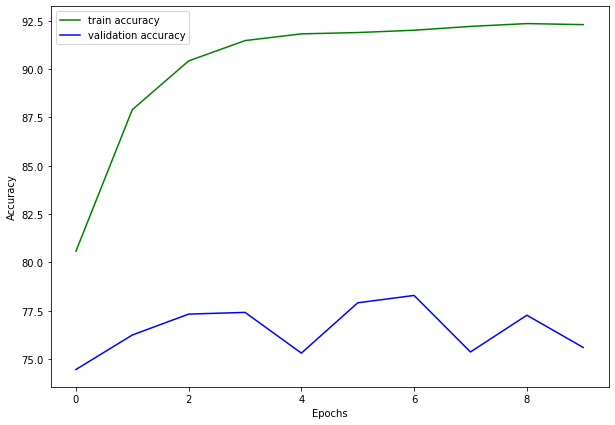

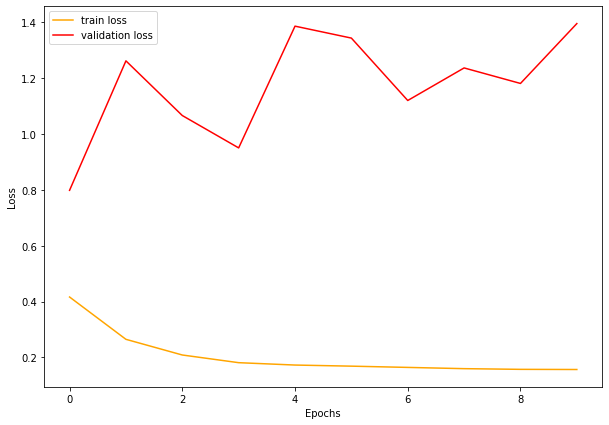

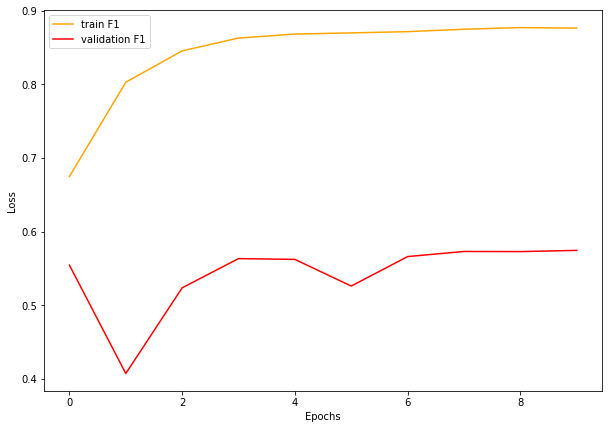

In [56]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig('/content/drive/MyDrive/Owen/accuracy.png')
plt.show()
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('/content/drive/MyDrive/Owen/loss.png')
plt.show()
# F1 plots
plt.figure(figsize=(10, 7))
plt.plot(train_f1, color='orange', label='train F1')
plt.plot(val_f1, color='red', label='validation F1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('/content/drive/MyDrive/Owen/loss.png')
plt.show()

In [57]:
blind_test = pd.read_csv("/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/test.csv")

In [58]:
blind_test = blind_test.drop("Unnamed: 0", axis="columns")
blind_test = blind_test.rename(columns={'Unnamed: 0.1':'image_name'})

In [59]:
blind_test['image_path'] = "/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/" + blind_test['image_name'].astype("str") + ".jpeg"

In [61]:
blind_test['segmented_image_path'] = "/content/drive/MyDrive/Owen/segmented_images_blind_test/" + blind_test['image_name'].astype("str") + ".jpeg"

In [60]:
blind_test['inspection_id'] = blind_test['road_id'] + blind_test['inspection_date']

In [62]:
inspection_ids = blind_test.inspection_id.unique()
x_blind = blind_test.segmented_image_path.values
y_blind = blind_test.cracking_binary.values
inspections_x = blind_test.inspection_id.values
inspections_y = blind_test['cracking_binary'].groupby(by=inspections_x).max()

In [65]:
from sklearn.metrics import f1_score

model.load_state_dict(torch.load("/content/drive/MyDrive/Owen/pretrained_resnet_mask_output/epoch" + str(j)))
model.eval
road_truths = []
max_preds = []
mean_preds = []
majority_preds = []
toptwo_preds = []
product_preds = []
probabilities = []
for i,inspection in tqdm(enumerate(inspection_ids), total=len(inspection_ids)):
    images_x = x_blind[inspections_x==inspection]
    images_y = y_blind[inspections_x==inspection]
    test_data = pano_images(images_x, images_y, tfms=0)
    with torch.no_grad():
      test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
      for i, data in enumerate(test_dataloader):
        data = data[0].to(device)
        outputs = model(data)
        road_truth = np.amax(images_y)
        max_pred = torch.round(torch.max(outputs.data)).item()
        probability = torch.max(outputs.data).item()
        mean_pred = torch.round(torch.mean(outputs.data)).item()
        majority_pred = torch.round(torch.mean(torch.round(outputs.data))).item()
        product_pred = torch.round(1-torch.prod(1-outputs.data)).item()
        if len(outputs.size())==0:
          top2_pred = torch.round(torch.max(outputs)).item()
        else:
          top2 = torch.topk(outputs, 2).values
          top2_pred = torch.round(torch.mean(top2)).item()
        road_truths.append(road_truth)
        max_preds.append(max_pred)
        mean_preds.append(mean_pred)
        majority_preds.append(majority_pred)
        toptwo_preds.append(top2_pred)
        product_preds.append(product_pred)
        probabilities.append(probability)
f1_max = f1_score(road_truths, max_preds)
f1_mean = f1_score(road_truths, mean_preds)
f1_majority = f1_score(road_truths, majority_preds)
f1_top2 = f1_score(road_truths, toptwo_preds)
f1_product = f1_score(road_truths, product_preds)
print(f1_max, f1_mean, f1_majority, f1_top2,f1_product)



  0%|          | 0/213 [00:00<?, ?it/s]

9




  0%|          | 1/213 [00:00<02:49,  1.25it/s]

  1%|          | 2/213 [00:02<03:19,  1.06it/s]

  2%|▏         | 4/213 [00:03<02:56,  1.18it/s]

  2%|▏         | 5/213 [00:04<02:50,  1.22it/s]

  3%|▎         | 6/213 [00:04<02:36,  1.32it/s]

  3%|▎         | 7/213 [00:05<02:45,  1.25it/s]

  4%|▍         | 8/213 [00:05<02:07,  1.61it/s]

  4%|▍         | 9/213 [00:06<02:01,  1.68it/s]

  5%|▍         | 10/213 [00:06<01:58,  1.71it/s]

  5%|▌         | 11/213 [00:08<02:43,  1.24it/s]

  6%|▌         | 12/213 [00:09<03:31,  1.05s/it]

  6%|▌         | 13/213 [00:10<02:58,  1.12it/s]

  7%|▋         | 14/213 [00:10<02:32,  1.31it/s]

  7%|▋         | 15/213 [00:11<02:36,  1.27it/s]

  8%|▊         | 16/213 [00:12<02:11,  1.49it/s]

  8%|▊         | 17/213 [00:12<02:05,  1.56it/s]

  9%|▉         | 19/213 [00:13<02:01,  1.59it/s]

  9%|▉         | 20/213 [00:14<01:43,  1.87it/s]

 10%|▉         | 21/213 [00:14<01:37,  1.96it/s]

 10%|█         | 22/213 [00:15<02:04,  1.53it/s]

 11%|█

0.5038759689922481 0.0 0.0 0.49193548387096775 0.5


In [66]:
from sklearn import metrics

print(metrics.confusion_matrix(road_truths, max_preds))
print(metrics.f1_score(road_truths, max_preds))
print(metrics.precision_score(road_truths, max_preds))
print(metrics.recall_score(road_truths, max_preds))
print(metrics.accuracy_score(road_truths, max_preds))

[[ 20 123]
 [  5  65]]
0.5038759689922481
0.34574468085106386
0.9285714285714286
0.39906103286384975


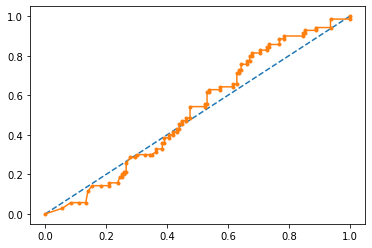

In [67]:
from matplotlib import pyplot
from sklearn import metrics as metric
ns_probs = [0 for _ in range(len(road_truths))]
ns_fpr, ns_tpr, _ = metric.roc_curve(road_truths, ns_probs)
lr_fpr, lr_tpr, _ = metric.roc_curve(road_truths, probabilities)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

In [68]:
ROC = pd.DataFrame({'FPR':lr_fpr,
                    'TPR':lr_tpr})

In [69]:
ROC.to_csv("/content/drive/MyDrive/Owen/final_results/baseline_masked.csv")